In [1]:
# Enable auto-reload of modified python files.
%load_ext autoreload
%autoreload 2

# Imports
from pprint import pprint 
from glob import glob
import sys, copy, os
import shlex, subprocess
sys.path.append('../')

import matplotlib
%matplotlib inline 
import matplotlib.image as mplimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns

import cv2

import numpy as np
import scipy
import pandas as pd
pd.set_eng_float_format(accuracy=3, use_eng_prefix=True)

from scipy import ndimage

import settings
import pickle as pck


# Helper functions
def cond_mkdir(path):
    '''Helper function to create a directory if it doesn't exist already.'''
    if not os.path.exists(path):
        os.makedirs(path)

def print_logfile_stats(log): 
    '''Prints the number of runs per viewpoint in this logfile.'''
    print("Total of %d runs."%len(log)) 
    for i in range(4): 
        print("Viewpoint %d: %d"%(i, len(log[log['viewpoint_idx']==i]))) 

def load_logfile(path): 
    '''
    Loads a logfile of eyetracking records from dist, given the path to the pickle file.
    '''
    with open(path, 'rb') as log_file: 
        log = pck.load(log_file, encoding='latin1') 
    print("Loaded %s."%path) 
    print_logfile_stats(log) 
    return log 


def gnomonic2lat_lon(x_y_coords, fov_vert_hor, center_lat_lon):
    '''
    Converts gnomonoic (x, y) coordinates to (latitude, longitude) coordinates.
    
    x_y_coords: numpy array of floats of shape (num_coords, 2) 
    fov_vert_hor: tuple of vertical, horizontal field of view in degree
    center_lat_lon: The (lat, lon) coordinates of the center of the viewport that the x_y_coords are referencing.
    '''
    sphere_radius_lon = 1. / (2.0 * np.tan(np.radians(fov_vert_hor[1] / 2.0)))
    sphere_radius_lat = 1. / (2.0 * np.tan(np.radians(fov_vert_hor[0] / 2.0)))

    x, y = x_y_coords[:,0], x_y_coords[:,1]

    x_y_hom = np.column_stack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))])

    K_inv = np.zeros((3, 3))
    K_inv[0, 0] = 1.0/sphere_radius_lon
    K_inv[1, 1] = 1.0/sphere_radius_lat
    K_inv[0, 2] = -1./(2.0*sphere_radius_lon)
    K_inv[1, 2] = -1./(2.0*sphere_radius_lat)
    K_inv[2, 2] = 1.0

    R_lat = np.zeros((3,3))
    R_lat[0,0] = 1.0
    R_lat[1,1] = np.cos(np.radians(-center_lat_lon[0]))
    R_lat[2,2] = R_lat[1,1]
    R_lat[1,2] = -1.0 * np.sin(np.radians(-center_lat_lon[0]))
    R_lat[2,1] = -1.0 * R_lat[1,2]

    R_lon = np.zeros((3,3))
    R_lon[2,2] = 1.0
    R_lon[0,0] = np.cos(np.radians(-center_lat_lon[1]))
    R_lon[1,1] = R_lon[0,0]
    R_lon[0,1] = - np.sin(np.radians(-center_lat_lon[1]))
    R_lon[1,0] = - R_lon[0,1]

    R_full = np.matmul(R_lon, R_lat)

    dot_prod = np.sum(np.matmul(R_full, K_inv).reshape(1,3,3) * x_y_hom.reshape(-1, 1, 3), axis=2)

    sphere_points = dot_prod/np.linalg.norm(dot_prod, axis=1, keepdims=True)

    lat = np.degrees(np.arccos(sphere_points[:, 2]))
    lon = np.degrees(np.arctan2(sphere_points[:, 0], sphere_points[:, 1]))

    lat_lon = np.column_stack([lat, lon])
    lat_lon = np.mod(lat_lon, np.array([180.0, 360.0]))

    return lat_lon

def angle2img(lat_lon_array, img_height_width):
    '''
    Convertes an array of latitude, longitude coordinates to image coordinates with range (0, height) x (0, width)
    '''
    return lat_lon_array / np.array([180., 360.]).reshape(1,2) * np.array(img_height_width).reshape(1,2)

def stitch2video(video_name, frame_dir, fps=30., print_output=False):
    '''
    Uses ffmpeg to stitch together a bunch of frames to a video. frame_dir has to be an absolute path. 
    '''
    framename_format_string = os.path.join(frame_dir, "%06d.png")
    ffmpeg_cmd = "ffmpeg -r %d -f image2 -s 1920x1080 -i %s -vcodec libx264 -crf 25  %s -y"%\
                    (fps, framename_format_string, video_name)
    args = shlex.split(ffmpeg_cmd)
    
    p = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
   
    if print_output:
        pprint(output)
        pprint(err)
        
def salmap_from_norm_coords(norm_coords, sigma, height_width):
    '''
    Base function to compute general saliency maps, given the normalized (from 0 to 1)
    fixation coordinates, the sigma of the gaussian blur, and the height and
    width of the saliency map in pixels.
    '''
    img_coords = np.mod(np.round(norm_coords * np.array(height_width)), np.array(height_width)-1.0).astype(int)

    gaze_counts = np.zeros((height_width[0], height_width[1]))
    for coord in img_coords:
        gaze_counts[coord[0], coord[1]] += 1.0

    gaze_counts[0, 0] = 0.0

    sigma_y = sigma
    salmap = ndimage.filters.gaussian_filter1d(gaze_counts, sigma=sigma_y, mode='wrap', axis=0)

    # In x-direction, we scale the radius of the gaussian kernel the closer we get to the pole
    for row in range(salmap.shape[0]):
        angle = (row/float(salmap.shape[0]) - 0.5) * np.pi
        sigma_x = sigma_y / (np.cos(angle) + 1e-3)
        salmap[row,:] = ndimage.filters.gaussian_filter1d(salmap[row,:], sigma=sigma_x, mode='wrap')

    salmap /= float(np.sum(salmap))
    return salmap

        
def get_gaze_salmap(list_of_runs, sigma_deg=1.0, height_width=(720, 1440)):
    '''Computes gaze saliency maps.'''
    fixation_coords = []

    for run in list_of_runs:
        relevant_fixations = run['gaze_fixations']

        if len(relevant_fixations.shape) > 1:
            _, unique_idcs = np.unique(relevant_fixations[:, 0], return_index=True)
            all_fixations = relevant_fixations[unique_idcs]
            fixation_coords.append(all_fixations)

    norm_coords = np.vstack(fixation_coords)[:,::-1]

    return salmap_from_norm_coords(norm_coords, sigma_deg * height_width[1]/360.0, height_width)

def get_head_salmap(list_of_runs, height_width=(720, 1440)):
    '''Computes head saliency maps.'''
    thresh=37.196
    all_head_velos = []
    all_head_lat_lons = []

    for run in list_of_runs:
        all_head_velos.append(run['ang_head_velo'])
        all_head_lat_lons.append(run['headLatLon'])

    head_velos = np.vstack(all_head_velos)
    head_lat_lons = np.vstack(all_head_lat_lons)

    fixation_idcs = head_velos[:, 1] < thresh
    fix_lat_lons = head_lat_lons[fixation_idcs]
    norm_fix_coords = fix_lat_lons / np.array([180, 360])

    # Get this cubemap's gaze salmap
    salmap = salmap_from_norm_coords(norm_fix_coords, sigma=19.0, height_width=height_width)

    return salmap

def overlay_image_salmap(img_path, salmap):
    '''Overlays an image with a saliency map.'''
    image = matplotlib.image.imread(img_path).astype(float)[:,:,:3]
    salmap_resized = cv2.resize(salmap, (image.shape[1], image.shape[0])).astype(float)

    fig,ax = plt.subplots(frameon=False)
    fig.set_size_inches(16,8)

    ax.imshow(image)
    ax.imshow(salmap_resized, cmap=plt.cm.jet, alpha=0.4)

    ax.axis('tight')
    ax.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    return fig, ax

def filter_starting_point(list_of_runs, threshold_deg=20.0):
    '''Filters all measurements of a run that are at the 
    beginning and in a vicinity of threshold_deg around the starting coordinates.'''
    cleaned_runs = []
    for run in list_of_runs:
        init_starting_point_lon = run['gaze_lat_lon'][0, 1]
        outside_bool = np.absolute(init_starting_point_lon - run['gaze_lat_lon'][:, 1])>threshold_deg
        if np.any(outside_bool):
            first_left = np.amin(np.where(outside_bool)[0])
            cleaned_runs.append({key:value[first_left:] for key, value in run.items()})
        else:
            cleaned_runs.append(run)
    return cleaned_runs

def get_data_matrix(list_of_runs, column_set='vr'):
    '''Joins specified columns of a list of runs to a single data matrix
    gaze_lat_lon_offset_lon'''
    if column_set=='vr':
        columns=['gaze_lat_lon_offset', 'gaze_fixations_single', 'ang_gaze_offset_velo', 'ang_head_velo', 'ang_gaze_velo', 'headTilt', 'gaze_fixations_ind']
    else:
        columns=['gaze_lat_lon_offset', 'gaze_fixations_single', 'ang_gaze_offset_velo', 'ang_head_velo', 'ang_gaze_velo', 'gaze_fixations_ind']
        
    data = []
    column_names =[]
    for column in columns:
        array_list = []

        for run in list_of_runs:
            array_list.append(np.squeeze(np.array(run[column])))

        if len(array_list[0].shape) == 1:
            joined_array = np.concatenate(array_list)

            data.append(joined_array)
            column_names.append(column)
        else:
            joined_array = np.vstack(array_list)

            data.append(joined_array[:, 0])
            data.append(joined_array[:, 1])
            column_names.append(column + '_lat')
            column_names.append(column + '_lon')

    return np.column_stack(data), column_names

def reject_gauss_outliers(data, column_names, m=2, take_absolute=True):
    '''Function to reject the outliers visible in above plot. Assumes a fundamentally normal distribution,
    which is close to what we see in the data.'''
    if take_absolute:
        data_ = np.absolute(data)
    else:
        data_ = np.copy(data)

    data_ = np.ma.masked_invalid(data_)

    col_means = np.nanmean(data_, axis=0, keepdims=True)
    centered_data = data_ - col_means
    column_stds = np.nanstd(data_, axis=0)

    bad_values_bool = np.absolute(centered_data) > m * column_stds
    bad_values = np.where(bad_values_bool)

    cleaned_data = np.copy(data)
    cleaned_data[bad_values] = np.take(col_means,bad_values[1])

    print("Rejection percentages:")
    for i in range(bad_values_bool.shape[1]):
        print("Column %s: %0.4f"%(column_names[i],
                               float(np.sum(bad_values_bool[:, i], axis=0))/bad_values_bool.shape[0]))

    return cleaned_data, col_means, column_stds

def plot_with_viewport(img, viewport_coords, out_path):
    viewport_coords_resh = viewport_coords.reshape(800,800,2)
    upper_line = viewport_coords_resh[0,:,:]
    lower_line = viewport_coords_resh[-1, :,:]
    right_line = viewport_coords_resh[:,-1, :]
    left_line=viewport_coords_resh[:,0,:]

    lines = [upper_line, lower_line, right_line, left_line]

    split_lines = []
    for line in lines:
        diff = np.diff(line, axis=0)
        wrap_idcs = np.where(np.abs(diff)>10)[0]
        if not len(wrap_idcs):
            split_lines.append(line)
        else:
            split_lines.append(line[:wrap_idcs[0]+1])
            split_lines.append(line[wrap_idcs[0]+1:])

    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(48,24)
    ax.imshow(img)
 
    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color='black', linewidth=10)
 
    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color='white',linewidth=8)
 
    ax.axis('tight')
    ax.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    fig.savefig(out_path, bbox_inches='tight', pad_inches=0)
    fig.clf()
    plt.close()

def get_gnomonic_hom(center_lat_lon, origin_image, height_width, fov_vert_hor=(60.0, 60.0) ):
    '''Extracts a gnomonic viewport with height_width from origin_image 
    at center_lat_lon with field of view fov_vert_hor.
    '''
    org_height_width, _ = origin_image.shape[:2], origin_image.shape[-1]
    height, width = height_width
    
    if len(origin_image.shape) == 3:
        result_image = np.zeros((height, width, 3))
    else:
        result_image = np.zeros((height, width))        

    sphere_radius_lon = width / (2.0 * np.tan(np.radians(fov_vert_hor[1] / 2.0)))
    sphere_radius_lat = height / (2.0 * np.tan(np.radians(fov_vert_hor[0] / 2.0)))

    y, x = np.mgrid[0:height, 0:width]
    x_y_hom = np.column_stack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))])

    K_inv = np.zeros((3, 3))
    K_inv[0, 0] = 1.0/sphere_radius_lon
    K_inv[1, 1] = 1.0/sphere_radius_lat
    K_inv[0, 2] = -width/(2.0*sphere_radius_lon)
    K_inv[1, 2] = -height/(2.0*sphere_radius_lat)
    K_inv[2, 2] = 1.0

    R_lat = np.zeros((3,3))
    R_lat[0,0] = 1.0
    R_lat[1,1] = np.cos(np.radians(-center_lat_lon[0]))
    R_lat[2,2] = R_lat[1,1]
    R_lat[1,2] = -1.0 * np.sin(np.radians(-center_lat_lon[0]))
    R_lat[2,1] = -1.0 * R_lat[1,2]

    R_lon = np.zeros((3,3))
    R_lon[2,2] = 1.0
    R_lon[0,0] = np.cos(np.radians(-center_lat_lon[1]))
    R_lon[1,1] = R_lon[0,0]
    R_lon[0,1] = - np.sin(np.radians(-center_lat_lon[1]))
    R_lon[1,0] = - R_lon[0,1]

    R_full = np.matmul(R_lon, R_lat)

    dot_prod = np.sum(np.matmul(R_full, K_inv).reshape(1,3,3) * x_y_hom.reshape(-1, 1, 3), axis=2)

    sphere_points = dot_prod/np.linalg.norm(dot_prod, axis=1, keepdims=True)

    lat = np.degrees(np.arccos(sphere_points[:, 2]))
    lon = np.degrees(np.arctan2(sphere_points[:, 0], sphere_points[:, 1]))

    lat_lon = np.column_stack([lat, lon])
    lat_lon = np.mod(lat_lon, np.array([180.0, 360.0]))

    org_img_y_x = lat_lon / np.array([180.0, 360.0]) * np.array(org_height_width)
    org_img_y_x = np.clip(org_img_y_x, 0.0, np.array(org_height_width).reshape(1, 2) - 1.0).astype(int)
    org_img_y_x = org_img_y_x.astype(int)
    
    if len(origin_image.shape) == 3:
        result_image[x_y_hom[:, 1].astype(int), x_y_hom[:, 0].astype(int), :] = origin_image[org_img_y_x[:, 0],
                                                                     org_img_y_x[:, 1], :]  
    else:
        result_image[x_y_hom[:, 1].astype(int), x_y_hom[:, 0].astype(int)] = origin_image[org_img_y_x[:, 0],
                                                                     org_img_y_x[:, 1]] 
    return result_image.astype(float), org_img_y_x

def get_pano_no(pano_no, undersample=3):
    '''Helper function to load the panorama oc scene pano_no and downsample it by a factor of undersample.'''
    path = os.path.join(settings.IMG_PATH, 'cubemap_%04d.png'%pano_no)
    pano = mplimg.imread(path)
    pano = pano[::undersample, ::undersample, :3]
    return pano

def extract_vid_frames(vid_path, target_dir, fps=15, print_output=False):
    '''Extract frames from a video, wrapping ffmpeg.'''
    vid_name = os.path.basename(vid_path)
    vid_name_no_ext = os.path.splitext(vid_name)[0]
    
    ffmpeg_template = 'ffmpeg -i {} -vf fps={} {}'

    ffmpeg_cmd = ffmpeg_template.format(vid_path, fps, os.path.join(target_dir, '%06d.png'))
    args = shlex.split(ffmpeg_cmd)
    
    p = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
   
    if print_output:
        pprint(output)
        pprint(err)
        
def interpolate_nan_rows(array, bad_rows_bool):
    '''Interpolates nan rows in an array.'''
    if True not in bad_rows_bool.astype(bool): return array

    good_rows = np.where(np.logical_not(bad_rows_bool))[0]

    # Since extrapolation is a bad idea, we identify the low-confidence indices that are outside the interpolatable range.
    low_non_nan, high_non_nan = np.amin(good_rows), np.amax(good_rows)
    interp_idcs = np.copy(bad_rows_bool)
    interp_idcs[high_non_nan:] = False
    interp_idcs[:low_non_nan] = False

    extra_idcs = np.logical_and(bad_rows_bool,
                             np.logical_or(np.arange(len(bad_rows_bool)) <= low_non_nan,
                                           np.arange(len(bad_rows_bool)) >= high_non_nan))

    interp_func = scipy.interpolate.interp1d(good_rows,
                                    np.take(array, good_rows, axis=0),
                                    kind='linear',
                                    axis=0)
    array[interp_idcs] = interp_func(np.where(interp_idcs)[0])
    # The indices outside the interpolatable range are set to the mean of the series.
    array[extra_idcs] = np.mean(array[good_rows], axis=0)

    return array
print("Done")

Done


## Preload files into memory

In [2]:
# Load runs for standing VR condition
all_files = sorted(glob(os.path.join(settings.DATASET_PATH_VR, '*.pck')))
runs_files = [load_logfile(logfile) for logfile in all_files]

# Also assemble all runs into a single list for analyses on all scenes.      
all_runs_list = []
for run in runs_files:
    all_runs_list.extend(run['data'])  
print(len(all_runs_list))

Loaded /home/lordgrim/vr-saliency/src/../data/vr/cubemap_0000.pck.
Total of 46 runs.
Viewpoint 0: 9
Viewpoint 1: 17
Viewpoint 2: 10
Viewpoint 3: 10
Loaded /home/lordgrim/vr-saliency/src/../data/vr/cubemap_0001.pck.
Total of 31 runs.
Viewpoint 0: 7
Viewpoint 1: 8
Viewpoint 2: 10
Viewpoint 3: 6
Loaded /home/lordgrim/vr-saliency/src/../data/vr/cubemap_0002.pck.
Total of 34 runs.
Viewpoint 0: 8
Viewpoint 1: 9
Viewpoint 2: 9
Viewpoint 3: 8
Loaded /home/lordgrim/vr-saliency/src/../data/vr/cubemap_0003.pck.
Total of 26 runs.
Viewpoint 0: 8
Viewpoint 1: 5
Viewpoint 2: 5
Viewpoint 3: 8
Loaded /home/lordgrim/vr-saliency/src/../data/vr/cubemap_0004.pck.
Total of 28 runs.
Viewpoint 0: 4
Viewpoint 1: 9
Viewpoint 2: 8
Viewpoint 3: 7
Loaded /home/lordgrim/vr-saliency/src/../data/vr/cubemap_0005.pck.
Total of 29 runs.
Viewpoint 0: 6
Viewpoint 1: 7
Viewpoint 2: 5
Viewpoint 3: 11
Loaded /home/lordgrim/vr-saliency/src/../data/vr/cubemap_0006.pck.
Total of 34 runs.
Viewpoint 0: 10
Viewpoint 1: 7
Viewpoint

In [3]:
# Load runs for browser condition
all_files_browser = sorted(glob(os.path.join(settings.DATASET_PATH_BROWSER, '*.pck')))
runs_files_browser = [load_logfile(logfile) for logfile in all_files_browser]
        
# Also assemble all runs into a single list for analyses on all scenes.      
all_runs_list_browser = []
for run in runs_files_browser:
    all_runs_list_browser.extend(run['data'])  
print(len(all_runs_list_browser))

Loaded /home/lordgrim/vr-saliency/src/../data/browser/0.pck.
Total of 44 runs.
Viewpoint 0: 10
Viewpoint 1: 12
Viewpoint 2: 12
Viewpoint 3: 10
Loaded /home/lordgrim/vr-saliency/src/../data/browser/1.pck.
Total of 42 runs.
Viewpoint 0: 10
Viewpoint 1: 10
Viewpoint 2: 12
Viewpoint 3: 10
Loaded /home/lordgrim/vr-saliency/src/../data/browser/10.pck.
Total of 41 runs.
Viewpoint 0: 10
Viewpoint 1: 11
Viewpoint 2: 11
Viewpoint 3: 9
Loaded /home/lordgrim/vr-saliency/src/../data/browser/11.pck.
Total of 39 runs.
Viewpoint 0: 10
Viewpoint 1: 10
Viewpoint 2: 9
Viewpoint 3: 10
Loaded /home/lordgrim/vr-saliency/src/../data/browser/12.pck.
Total of 40 runs.
Viewpoint 0: 11
Viewpoint 1: 11
Viewpoint 2: 9
Viewpoint 3: 9
Loaded /home/lordgrim/vr-saliency/src/../data/browser/13.pck.
Total of 40 runs.
Viewpoint 0: 11
Viewpoint 1: 10
Viewpoint 2: 10
Viewpoint 3: 9
Loaded /home/lordgrim/vr-saliency/src/../data/browser/14.pck.
Total of 41 runs.
Viewpoint 0: 11
Viewpoint 1: 11
Viewpoint 2: 10
Viewpoint 3: 9


# Animate runs in scene 0

In [4]:
def plot_fov(center_lat_lon, ax, color, fov_vert_hor, height_width):
    '''
    Plots the correctly warped FOV at a given center_lat_lon.
    center_lat_lon: Float tuple of latitude, longitude. Position where FOV is centered
    ax: The matplotlib axis object that should used for plotting.
    color: Color of the FOV box.
    height_width: Height and width of the image.
    '''
    # Coordinates for a rectangle.
    coords = []
    coords.append([np.linspace(0.0, 1.0, 100), [1.]*100])
    coords.append([[1.]*100, np.linspace(0.0, 1.0, 100)])
    coords.append([np.linspace(0.0, 1.0, 100), [0.]*100])
    coords.append([[0.]*100, np.linspace(0.0, 1.0, 100)])    

    lines = []
    for coord in coords:
        lat_lon_array = gnomonic2lat_lon(np.column_stack(coord), fov_vert_hor=fov_vert_hor, 
                                         center_lat_lon=center_lat_lon)
        img_coord_array = angle2img(lat_lon_array, height_width)
        lines.append(img_coord_array)
        
    split_lines = []
    for line in lines:
        diff = np.diff(line, axis=0)
        wrap_idcs = np.where(np.abs(diff)>np.amin(height_width))[0]
        
        if not len(wrap_idcs):
            split_lines.append(line)
        else:
            split_lines.append(line[:wrap_idcs[0]+1])
            split_lines.append(line[wrap_idcs[0]+1:])

    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color=color, linewidth=1.2, alpha=0.5)

In [5]:
def render_exploration_frames(scene_df, 
                              img_path,
                              target_dir='frames',
                              duration=30.,
                              fps=30.):
    '''
    Renders single frames of a video that visualizes scanpaths and FOV of users in the VR scene img_path.
    Frames can subsequently be stitched together with ffmpeg.
    
    scene_df: pandas Dataframe with all the runs for a specific scene.
    img_path: Path to the equirectangular scene file.
    duration: Duration of the animation in seconds.
    fps: Target fps.
    '''
    num_frames = fps * duration
    img_height, img_width = 2048, 4096
    image = cv2.resize(cv2.imread(img_path), (img_width, img_height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    frame_no = 0
    print(duration, num_frames) 
    for t in np.linspace(0.0, duration, int(num_frames)):
        print(t)
        plt.close('all')

        fig, ax = plt.subplots(frameon=False, figsize=(16,9))
        
        ax.grid(b=False)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.imshow(image)
        ax.axis('tight')
        ax.set_xlim([0,img_width])
        ax.set_ylim([img_height, 0])
        
        time_template = 'time %.1fs'
        time_text = ax.text(0.05, 0.9, '', size='large', transform=ax.transAxes)
        time_text.set_text(time_template % t)

        fov_vert = 106.188
        aspect_ratio = 0.82034051
        fov_hor = fov_vert * aspect_ratio
        fov_vert_hor = np.array([fov_vert, fov_hor])

        colors = cm.rainbow(np.linspace(0, 1, len(scene_df)))
                
        for color, log_df in zip(colors, scene_df['data']):
            time_filtered = np.where(log_df['timestamp']<=t)[0]
            if len(time_filtered):
                frame_idx = np.amax(time_filtered)
                
                if frame_idx >= len(log_df['timestamp']): 
                    continue
            else:
                continue
            gaze_coords = angle2img(log_df['gaze_lat_lon'][frame_idx, :], (img_height, img_width))
            print(gaze_coords)
            print(gaze_coords[0][0],gaze_coords[0][1])
            head_lat_lon = log_df['headLatLon'][frame_idx, :]
            ax.plot(gaze_coords[0][1], gaze_coords[0][0], marker='o', markersize=12., color=color, alpha=.8)
            
            plot_fov(head_lat_lon, ax, color, fov_vert_hor, height_width=np.array([img_height, img_width]))
        
        fig.savefig(os.path.join(target_dir, "%06d.png"%frame_no), bbox_inches='tight', pad_inches=0, dpi=160)
        frame_no += 1
        fig.clf()

In [10]:
if not os.path.exists('frames'):
    print(f"Made {os.getcwd()+'/frames'}")
    os.makedirs('frames')
animation = render_exploration_frames(runs_files[0], os.path.join(settings.IMG_PATH, 'cubemap_0000.png'), fps=24)

Made /home/lordgrim/vr-saliency/src/frames
30.0 720.0
0.0
0.04172461752433936
[[ 956.91291323 2032.98442795]]
956.9129132290278 2032.9844279518024
[[ 977.48825773 3078.26479616]]
977.4882577276603 3078.2647961585503
[[1019.93998816 4091.35640133]]
1019.9399881596099 4091.35640133302
[[1023.12183292 4083.61177963]]
1023.1218329198892 4083.6117796272956
[[1061.84534251 1003.83381639]]
1061.8453425100279 1003.8338163939405
[[1032.45861959 3038.97910497]]
1032.4586195873978 3038.9791049690098
[[ 958.27895614 3074.55432217]]
958.2789561352046 3074.554322173038
[[1126.15545725 2040.91591769]]
1126.1554572462667 2040.9159176911576
[[1013.88925136    3.18157748]]
1013.8892513570452 3.1815774794606235
[[1116.70594892 4010.72636003]]
1116.7059489205055 4010.726360030729
[[1015.18227964 1037.87954714]]
1015.1822796420162 1037.87954714429
[[1029.73495451 2043.10047673]]
1029.73495450561 2043.1004767305446
[[ 970.45304854 4095.08810599]]
970.4530485356858 4095.0881059893595
[[1016.86802713 4087.269

[[1085.46873688 1019.27755136]]
1085.4687368845237 1019.2775513601733
[[ 977.14681406 1058.70185099]]
977.1468140636435 1058.701850994153
[[1050.03460503 1035.04512021]]
1050.034605025263 1035.0451202072843
[[1001.24928107 3078.5595454 ]]
1001.2492810682938 3078.559545403481
0.16689847009735745
[[ 956.29867305 2035.14741848]]
956.2986730534548 2035.147418479328
[[ 976.80301908 3077.52775961]]
976.803019083231 3077.527759607678
[[1019.91190935 4092.6897976 ]]
1019.9119093549913 4092.689797598015
[[1021.89296554 4084.11915504]]
1021.8929655397429 4084.1191550368603
[[1059.09545734 1003.80628654]]
1059.0954573396148 1003.8062865386585
[[1032.8435996  3042.51908623]]
1032.8435995958848 3042.5190862337145
[[ 956.19669272 3075.59119078]]
956.1966927244328 3075.591190777806
[[1119.51162016 2041.82523387]]
1119.511620159412 2041.8252338747109
[[1014.05639103    3.94485537]]
1014.0563910319814 3.9448553652055645
[[1156.69089485 4012.21875707]]
1156.690894847005 4012.2187570720625
[[1016.1279464

[[ 973.29990045 3063.53954425]]
973.2999004473788 3063.539544251106
[[1151.12232508 2074.63310226]]
1151.122325078675 2074.633102260549
[[963.92105323   4.06547214]]
963.921053227806 4.065472139467605
[[998.7887624  807.47572968]]
998.7887623986752 807.4757296830642
[[938.68758423 935.3189306 ]]
938.6875842328975 935.3189306035392
[[ 929.9440588  1021.18778162]]
929.9440588043445 1021.1877816242064
[[1072.86724198 1023.28023417]]
1072.8672419766392 1023.2802341678544
[[1131.09155412 1010.08380769]]
1131.0915541212005 1010.0838076902605
[[1049.11028365 1025.58231353]]
1049.1102836506682 1025.5823135298203
[[1085.74902162 1019.63770804]]
1085.7490216232013 1019.6377080449716
[[ 976.06070531 1059.15368105]]
976.060705309241 1059.1536810533737
[[1052.30628713 1035.28092952]]
1052.3062871346697 1035.280929522274
[[1066.55996941 3130.24400819]]
1066.559969410394 3130.2440081897785
0.29207232267037553
[[1077.20164695 2057.55771172]]
1077.2016469454834 2057.5577117222983
[[ 977.61379653 3075.7

[[1270.2929416  1017.26812429]]
1270.2929416034394 1017.2681242880032
[[1109.05628842 1015.3753935 ]]
1109.0562884167982 1015.3753934998166
[[1240.47013364 1098.20826683]]
1240.47013364174 1098.2082668345759
[[1085.91300631 1096.98081256]]
1085.9130063052646 1096.9808125570871
[[1056.68306045 1034.68906227]]
1056.683060445354 1034.6890622744672
[[1097.27115993 3102.16996864]]
1097.271159932205 3102.1699686371876
0.41724617524339364
[[1076.94900883 2058.55281171]]
1076.949008825944 2058.5528117126964
[[1117.60741766 3049.74200329]]
1117.6074176587483 3049.742003293071
[[1092.03325911   65.45474088]]
1092.0332591106549 65.45474087858253
[[1024.31717681 4083.97867998]]
1024.3171768132752 4083.978679980338
[[1183.34676616 1057.02238541]]
1183.3467661593775 1057.022385409629
[[1035.82161939 3042.21257578]]
1035.8216193911271 3042.2125757792996
[[1005.11008981 3039.66348456]]
1005.1100898099646 3039.6634845595063
[[1220.38132684 2034.79952352]]
1220.3813268436281 2034.7995235160472
[[1012.26

[[1247.82950542 1040.71222667]]
1247.8295054159835 1040.7122266712415
[[1130.19914566 3049.82876838]]
1130.199145660406 3049.828768379293
0.5424200278164117
[[1121.09480911 1906.97865192]]
1121.0948091071464 1906.97865192472
[[1115.91000607 3050.03816307]]
1115.9100060676592 3050.0381630686757
[[1091.33085632   66.07787319]]
1091.3308563211708 66.07787318573243
[[1178.08649903 4003.28090766]]
1178.0864990298594 4003.280907661648
[[1212.50046081 1026.52404983]]
1212.5004608127883 1026.5240498329106
[[1036.77831965 3042.61010643]]
1036.7783196501598 3042.6101064339864
[[1026.03813233 2957.84686644]]
1026.038132331032 2957.846866442704
[[1214.38744697 2035.22497625]]
1214.3874469717073 2035.2249762475112
[[1130.32170987 3824.67370154]]
1130.3217098650694 3824.6737015369413
[[1082.66390878   30.27313009]]
1082.663908778867 30.273130092197057
[[1147.497217   1010.06412139]]
1147.4972169980915 1010.0641213858053
[[1082.11012341 1782.8622627 ]]
1082.1101234074342 1782.8622627036202
[[ 994.475

0.6675938803894298
[[1133.45211232 1708.20299519]]
1133.4521123197821 1708.2029951901395
[[1144.90764105 3061.99437459]]
1144.9076410524572 3061.9943745879314
[[1090.54076651   66.11747981]]
1090.5407665112996 66.1174798091825
[[1180.71751103 3998.15616416]]
1180.7175110276826 3998.1561641583457
[[1223.06174594 1022.43665412]]
1223.0617459403968 1022.4366541233574
[[1036.41176567 3042.720902  ]]
1036.4117656671742 3042.720902001955
[[ 987.07876131 2956.97308291]]
987.0787613112481 2956.973082912943
[[1218.65512341 2035.98281457]]
1218.655123413767 2035.9828145681731
[[1169.09501684 3745.23175427]]
1169.095016842943 3745.231754268801
[[1277.61610021 4016.87183604]]
1277.6161002065808 4016.87183603769
[[1148.32320705 1006.85478903]]
1148.3232070488427 1006.8547890331151
[[1079.29416542 1681.17342753]]
1079.2941654222986 1681.1734275317287
[[1134.05040878 3712.17131168]]
1134.0504087808492 3712.171311683188
[[1192.01053201 3741.02697774]]
1192.0105320145365 3741.0269777435465
[[1065.44510

0.7927677329624478
[[1213.92734419 1467.57324813]]
1213.9273441881362 1467.5732481262255
[[1037.50441097 3150.66346129]]
1037.5044109662033 3150.6634612933817
[[1173.67217836 3819.06917974]]
1173.6721783575217 3819.069179743998
[[1168.60222997 3720.95948681]]
1168.60222996588 3720.9594868121085
[[1192.09389445  732.17867203]]
1192.0938944451132 732.1786720346252
[[1040.73797482 3292.19574884]]
1040.7379748151134 3292.195748844239
[[1015.32085305 2973.80647684]]
1015.3208530455624 2973.8064768367617
[[1142.90632756 2058.60386594]]
1142.9063275575359 2058.6038659396822
[[1151.28688699 3687.65064769]]
1151.2868869944311 3687.6506476899012
[[933.38181629  92.10069939]]
933.3818162855279 92.10069938766115
[[1181.53084739 1004.98836664]]
1181.5308473888158 1004.9883666449073
[[1143.98912603 1424.93629201]]
1143.989126031371 1424.936292014693
[[1153.43817802 3668.10784269]]
1153.4381780242022 3668.107842688767
[[1184.25997649 3742.12660612]]
1184.259976491119 3742.126606122877
[[ 999.49079078

[[1527.17788871 1184.82271759]]
1527.177888712324 1184.8227175871161
[[1200.61124746 1055.75719287]]
1200.6112474579172 1055.7571928662558
[[1311.09171251  879.29607716]]
1311.091712505726 879.2960771582534
[[1221.1727353  3129.69108629]]
1221.1727352961352 3129.6910862895643
0.917941585535466
[[1220.11273356 1394.53225078]]
1220.112733555067 1394.53225078321
[[ 958.88115819 3254.81909557]]
958.8811581921116 3254.8190955658088
[[1175.36117579 3792.66484745]]
1175.3611757917163 3792.664847451998
[[1172.50962448 3717.19430037]]
1172.509624482256 3717.194300373246
[[1170.20896249  531.58028273]]
1170.2089624907417 531.5802827286002
[[1038.59965544 3299.89013082]]
1038.599655435206 3299.890130816065
[[1152.31597858 3035.92768796]]
1152.3159785834039 3035.92768795791
[[1143.46569338 2058.07094467]]
1143.4656933824613 2058.0709446749347
[[1038.13216005 3483.55460755]]
1038.1321600475794 3483.5546075528337
[[947.97431421  92.76708473]]
947.9743142105249 92.76708473207839
[[1144.12641607 1000.

[[1605.77848544 1148.26378717]]
1605.7784854409824 1148.2637871726247
[[1326.1835542 1073.238237 ]]
1326.183554202863 1073.238237002628
[[1305.88344706  857.45039472]]
1305.8834470567972 857.4503947167748
[[1057.29902851 2996.60324575]]
1057.2990285139767 2996.603245752936
1.043115438108484
[[1219.4489757  1393.82572687]]
1219.4489756992746 1393.8257268665163
[[ 966.1315449  3269.21385855]]
966.1315449043373 3269.2138585516104
[[1193.88477671 3748.92789447]]
1193.8847767056482 3748.9278944737634
[[1415.50417321 3884.9656853 ]]
1415.5041732076716 3884.9656852958115
[[1180.92326151  543.9840155 ]]
1180.9232615095002 543.9840155019664
[[1084.30270448 3516.00016549]]
1084.3027044769133 3516.0001654851644
[[1144.66865248 3035.93415142]]
1144.668652482517 3035.9341514215066
[[1139.63332726 2060.40941461]]
1139.6333272610718 2060.409414612806
[[1070.77071027 3280.06014688]]
1070.7707102704933 3280.0601468800205
[[959.8071764  115.13899179]]
959.8071763956927 115.13899178660651
[[1149.47800661

[[1027.61636654 1024.44982992]]
1027.6163665397044 1024.449829918846
[[1652.38509306 1152.37729054]]
1652.3850930581943 1152.3772905418743
[[1448.9113175  1087.90453711]]
1448.9113175019702 1087.904537108478
[[1346.25609057  851.11475177]]
1346.256090571476 851.1147517708612
[[1053.29693462 2982.50097719]]
1053.2969346227821 2982.5009771910063
1.1682892906815021
[[1219.39727992 1227.71085967]]
1219.3972799157034 1227.7108596732382
[[ 999.97977383 3435.49971051]]
999.9797738284657 3435.49971051241
[[1197.51634028 3752.35863027]]
1197.516340282428 3752.3586302737076
[[1413.09484898 3879.4761771 ]]
1413.0948489756188 3879.4761770993136
[[1177.09748144  538.93456448]]
1177.0974814356514 538.9345644774356
[[1079.20219278 3521.26284551]]
1079.2021927752428 3521.26284550772
[[1300.65787414 3136.52730262]]
1300.6578741433218 3136.5273026234695
[[1138.23188957 2060.81087731]]
1138.2318895654498 2060.81087731351
[[1106.69070632 3233.2629372 ]]
1106.690706322096 3233.2629371982066
[[1068.42384413

[[1467.92555872 1087.63382459]]
1467.9255587228445 1087.6338245904426
[[1200.26302274  590.64178372]]
1200.2630227399013 590.6417837246747
[[1012.15970196 2946.88776019]]
1012.1597019642771 2946.887760192696
1.2934631432545203
[[1106.29509966 1109.38349571]]
1106.2950996606185 1109.383495713114
[[1005.98487895 3564.84012363]]
1005.9848789465897 3564.840123632528
[[1141.21624734 3700.61597184]]
1141.2162473386995 3700.6159718421263
[[1545.41121838 3919.98368399]]
1545.411218382543 3919.983683988889
[[1271.04658829  605.77795313]]
1271.0465882877788 605.7779531319688
[[1220.48965661 3714.68582659]]
1220.4896566116258 3714.685826588492
[[1294.94773801 3136.77236493]]
1294.9477380111407 3136.772364925485
[[1153.00325261 2169.7330927 ]]
1153.0032526145797 2169.733092700674
[[1119.6188867  3227.66261533]]
1119.6188866953885 3227.6626153332477
[[1051.8739303  305.1659791]]
1051.8739302995905 305.16597910111574
[[819.66208666 918.76373768]]
819.6620866554628 918.7637376793375
[[1107.12435139 1

[[ 948.6494783  1019.33301899]]
948.6494782987713 1019.333018993301
[[1670.27793735 1119.99073811]]
1670.2779373482356 1119.9907381089943
[[1504.2240879   924.51834458]]
1504.2240879024912 924.5183445776197
[[1239.24279382  591.04630288]]
1239.2427938210158 591.0463028813813
[[1013.86512409 2946.9411953 ]]
1013.865124087873 2946.9411952972837
1.4186369958275382
[[1096.97353203 1090.71913459]]
1096.973532031607 1090.7191345876568
[[1006.98092083 3573.82991277]]
1006.980920827779 3573.8299127737782
[[1019.69177317 3576.63036098]]
1019.6917731673013 3576.630360979623
[[1540.12623807 3909.40802886]]
1540.1262380659127 3909.4080288569176
[[1323.16456704  711.43194034]]
1323.1645670443795 711.4319403421368
[[1214.98366991 3722.71563427]]
1214.983669907897 3722.7156342657477
[[1291.60912222 3141.63823786]]
1291.6091222245307 3141.638237863941
[[1188.68338873 2381.82479957]]
1188.6833887271937 2381.824799573344
[[1149.27733447 3035.04618505]]
1149.2773344713437 3035.0461850486295
[[1280.509899

[[1259.1045828   902.22063758]]
1259.104582804235 902.2206375810439
[[1218.44519483 1619.38731465]]
1218.4451948342216 1619.3873146474425
[[ 868.47052002 1014.70500285]]
868.4705200225853 1014.7050028459558
[[1688.02238467 1195.74495981]]
1688.0223846716553 1195.744959808166
[[1465.86670756  748.2423609 ]]
1465.8667075564308 748.2423609025377
[[1164.62496145  335.80776283]]
1164.6249614458584 335.8077628345818
[[1020.03598838 2947.2622297 ]]
1020.0359883835273 2947.2622297036946
1.5438108484005564
[[1095.35113103 1091.03666316]]
1095.3511310295423 1091.0366631566299
[[1053.46348691 3640.0476891 ]]
1053.463486905879 3640.047689103043
[[1020.69716746 3542.24186602]]
1020.6971674605497 3542.2418660178746
[[1538.08969448 3905.87294333]]
1538.089694481154 3905.872943333767
[[1329.65480721  831.73286236]]
1329.6548072124 831.7328623618534
[[1305.61560391 3995.93112054]]
1305.6156039106095 3995.931120539079
[[1257.54170248 3237.22166555]]
1257.5417024792469 3237.2216655494094
[[1172.95968488 

[[1245.78334071 1730.51213504]]
1245.7833407149076 1730.512135044131
[[ 868.11403471 1015.63294097]]
868.1140347137044 1015.6329409694923
[[1685.78256009 1200.54662961]]
1685.7825600932113 1200.5466296118004
[[1463.78558928  732.29071015]]
1463.785589284573 732.2907101484119
[[1185.9063081  335.4069124]]
1185.9063081038014 335.4069123976427
[[1021.39152655 2947.95531284]]
1021.3915265526941 2947.955312844588
1.6689847009735745
[[1094.38359909 1084.3279048 ]]
1094.3835990882499 1084.3279047992546
[[1150.32772474 3732.63519342]]
1150.3277247354588 3732.635193424924
[[1017.47444813 3369.10644737]]
1017.4744481348638 3369.106447374179
[[1538.01989314 3902.86406427]]
1538.0198931422744 3902.8640642714804
[[1300.25358001  996.79379312]]
1300.2535800122705 996.7937931240442
[[1302.57557111 4008.1392513 ]]
1302.5755711137283 4008.139251299645
[[1202.69035265 3309.98633103]]
1202.6903526452988 3309.9863310300875
[[1182.22630994 2448.78330809]]
1182.2263099382267 2448.783308090309
[[1114.6681622

[[1244.62640853 1736.00182201]]
1244.6264085255414 1736.0018220062361
[[1009.56026273 1010.78942866]]
1009.5602627288065 1010.7894286568154
[[1681.106572   1189.23753318]]
1681.106572003817 1189.2375331817398
[[1217.26834385  541.24586217]]
1217.2683438543584 541.2458621737279
[[1177.54489029  100.21679216]]
1177.54489029317 100.2167921649599
[[1146.42694384 3019.21270392]]
1146.426943844315 3019.21270391871
1.7941585535465925
[[1077.22363549 1096.76572048]]
1077.2236354945912 1096.765720477822
[[1155.30561817 3747.25667427]]
1155.30561816519 3747.2566742662643
[[1022.2171084  3344.22893944]]
1022.2171084008311 3344.228939435364
[[1388.2499139  3817.45361684]]
1388.2499138986116 3817.45361683669
[[1287.61906236 1004.86201453]]
1287.6190623582445 1004.8620145336356
[[1265.26705913   32.61259012]]
1265.2670591344925 32.612590121275154
[[1075.72218049 3465.03746455]]
1075.7221804914432 3465.0374645461548
[[1223.62630304 2518.54659141]]
1223.626303038082 2518.5465914101414
[[1117.04770779 

[[1185.15605332  500.38513033]]
1185.1560533237612 500.385130328773
[[1186.38502516   66.6350477 ]]
1186.3850251615315 66.63504769723541
[[1148.05899861 3024.51462296]]
1148.0589986116051 3024.514622957663
1.9193324061196106
[[1078.24939645 1089.17699871]]
1078.2493964451826 1089.1769987084338
[[1163.43312656 3760.50776255]]
1163.4331265613644 3760.5077625453187
[[1158.19202226 3212.00812447]]
1158.1920222617916 3212.0081244657404
[[1205.01389309 3714.77169001]]
1205.0138930920104 3714.7716900129144
[[1163.28573817 1325.19786129]]
1163.2857381665322 1325.1978612886794
[[1082.7219377   118.20149025]]
1082.7219376999221 118.2014902475573
[[1066.62736478 3511.58155722]]
1066.6273647808723 3511.581557215427
[[1159.39060657 2534.46557551]]
1159.390606573345 2534.465575508605
[[1121.09344323 2903.86342078]]
1121.0934432305387 2903.863420775188
[[1162.7477865   745.82059157]]
1162.7477864962234 745.8205915666557
[[ 939.70107937 1237.7789325 ]]
939.7010793735274 1237.7789325036103
[[1119.91533

[[1222.22585717 1928.63085778]]
1222.2258571726356 1928.6308577818415
[[1131.30304726 1071.77736681]]
1131.3030472641115 1071.7773668148284
[[1562.84630624  601.38808479]]
1562.846306242625 601.388084789233
[[1090.56793246  371.66618702]]
1090.5679324572477 371.666187018089
[[1124.85163895 3991.05880549]]
1124.8516389492581 3991.0588054864065
[[1208.20796645 3138.73757782]]
1208.207966450352 3138.737577822891
2.044506258692629
[[1195.13211562 1006.72986069]]
1195.1321156227905 1006.7298606872913
[[1164.13607744 3759.59729763]]
1164.1360774443851 3759.5972976306884
[[1160.20289946 3208.06091026]]
1160.2028994604116 3208.0609102629905
[[1211.80064122 3713.44330119]]
1211.8006412225568 3713.4433011911415
[[1164.75523051 1355.05956375]]
1164.7552305089314 1355.0595637523963
[[1098.44640586  121.53547883]]
1098.446405862742 121.53547883171882
[[1063.80986671 3519.37268123]]
1063.8098667082156 3519.3726812278974
[[1153.71079671 2537.5479624 ]]
1153.7107967102866 2537.547962401599
[[1194.5099

[[1098.15145765  355.54709654]]
1098.1514576457016 355.54709653848573
[[1144.06243932 3998.15909456]]
1144.0624393170117 3998.159094560403
[[1209.36834973 3138.1266189 ]]
1209.368349732715 3138.1266189007392
2.169680111265647
[[1195.80517682  998.09611587]]
1195.8051768183036 998.0961158663151
[[1174.80402008 3766.56926639]]
1174.8040200787186 3766.5692663906743
[[1159.30721437 3208.45629367]]
1159.3072143704946 3208.456293673544
[[1173.74423921 3726.33471082]]
1173.7442392120263 3726.3347108189128
[[1189.01419014 1613.28678285]]
1189.0141901397988 1613.2867828543988
[[1064.0922666   139.91090068]]
1064.0922665995345 139.91090068403116
[[1060.75638575 3520.49436023]]
1060.756385753607 3520.4943602307294
[[1122.2200076  2514.12504126]]
1122.22000759597 2514.1250412627815
[[1240.28512422 2635.38192435]]
1240.285124219558 2635.3819243450453
[[1196.2200502   927.04253385]]
1196.2200502008718 927.0425338476772
[[ 933.88692627 1241.63942194]]
933.8869262653418 1241.6394219431031
[[1100.34746

[[1165.01247751 1105.68179318]]
1165.0124775096492 1105.6817931835697
[[1491.94297819  440.13681901]]
1491.9429781899373 440.1368190122731
[[1041.53087244  159.20237487]]
1041.5308724369493 159.20237486925905
[[1266.92173488 3771.2221258 ]]
1266.9217348783675 3771.2221258037516
[[1309.10473673 3225.18789172]]
1309.10473672715 3225.187891718369
2.294853963838665
[[1197.14349081  997.13777623]]
1197.1434908110036 997.1377762339785
[[1171.38323225 3768.19301768]]
1171.3832322460994 3768.1930176776686
[[1164.3409439 3205.805505 ]]
1164.3409439009602 3205.8055050037906
[[1270.18733478 3578.50541124]]
1270.1873347820397 3578.505411237843
[[1187.3686315  1594.77386586]]
1187.3686315011187 1594.7738658597902
[[1067.07245658  148.4682903 ]]
1067.0724565755368 148.46829030022522
[[1068.70730564 3457.80551746]]
1068.7073056351517 3457.805517462445
[[1121.69572882 2516.13033806]]
1121.6957288198755 2516.130338064842
[[1240.19414604 2548.52218214]]
1240.1941460351488 2548.5221821435307
[[1165.16409

[[1487.14627955  435.65624697]]
1487.1462795501077 435.6562469659686
[[1040.96499984  147.09770759]]
1040.9649998355897 147.0977075873514
[[1326.79785399 3718.39397887]]
1326.7978539910166 3718.393978868787
[[1306.50395221 3224.5955524 ]]
1306.5039522068644 3224.595552398864
2.420027816411683
[[1240.49944599  979.75187116]]
1240.499445987325 979.7518711625224
[[1165.51780717 3765.18386326]]
1165.5178071684918 3765.183863257664
[[1073.21957659 2949.60787904]]
1073.2195765889844 2949.6078790411675
[[1164.42949039 3744.89475821]]
1164.4294903897387 3744.8947582127857
[[1151.00410787 1695.52999495]]
1151.0041078710908 1695.5299949549849
[[1058.03365425  312.64346949]]
1058.0336542527368 312.6434694862432
[[ 910.68830139 3342.4443218 ]]
910.6883013941973 3342.444321798488
[[1104.86411247 2522.72585036]]
1104.864112470886 2522.7258503627
[[1252.61219845 2540.35112074]]
1252.612198452714 2540.351120736645
[[1088.46772595  984.18576507]]
1088.4677259482435 984.1857650739131
[[1113.40923344 150

[[1129.38788476 1105.57849144]]
1129.3878847627025 1105.5784914350215
[[1485.60191449  438.00361871]]
1485.6019144912143 438.00361871389936
[[1044.78275744  144.98801398]]
1044.7827574365588 144.98801398270723
[[1331.63376712 3703.14015407]]
1331.633767121268 3703.1401540736724
[[1335.53517085 3255.34792705]]
1335.5351708474502 3255.3479270490625
2.545201668984701
[[1247.30899668  978.18430413]]
1247.3089966796456 978.1843041329817
[[1111.83720802 3982.46681633]]
1111.8372080224694 3982.466816327938
[[1051.70170507 2850.6242871 ]]
1051.7017050650702 2850.624287099135
[[1170.54275511 3742.52733549]]
1170.5427551115858 3742.5273354928086
[[1137.13052863 1864.73283288]]
1137.1305286255017 1864.7328328842966
[[1063.38318968  309.64442874]]
1063.383189679702 309.64442874161745
[[ 874.67598799 3279.18205371]]
874.675987991083 3279.1820537124954
[[1103.92868829 2523.94429756]]
1103.928688292383 2523.9442975608886
[[1037.71250204 2524.72151242]]
1037.7125020395538 2524.7215124223835
[[1071.434

[[945.75455014 919.04914148]]
945.7545501435445 919.0491414841237
[[1152.69987709   38.5690524 ]]
1152.6998770916214 38.56905239627787
[[1541.8785147  2403.54518304]]
1541.878514697785 2403.5451830446686
[[1173.65956421 1056.47618811]]
1173.6595642073132 1056.476188106643
[[1272.90029849  220.74421249]]
1272.9002984888045 220.7442124870239
[[1043.63100524    8.42206756]]
1043.6310052413307 8.422067559725624
[[1325.95148706 3652.98548419]]
1325.9514870597318 3652.9854841934193
[[1330.51658542 3253.6806053 ]]
1330.5165854231211 3253.6806052982365
2.670375521557719
[[1250.63969149  978.66480625]]
1250.6396914865895 978.6648062533442
[[1053.3599825    67.92412696]]
1053.3599825005365 67.92412696285396
[[1068.03246061 2860.59344285]]
1068.0324606064667 2860.5934428535875
[[1014.30370294 3580.73144815]]
1014.3037029406106 3580.731448152328
[[1118.18353943 1928.32259729]]
1118.1835394346308 1928.32259729284
[[1065.35348226  311.18501048]]
1065.3534822613458 311.1850104794872
[[ 895.90557666 3

[[1040.47633965    2.55064413]]
1040.4763396483945 2.5506441321993525
[[1288.51219117 3548.60339785]]
1288.5121911667607 3548.603397845645
[[1356.56656927 3194.70381716]]
1356.5665692697303 3194.7038171647273
2.7955493741307373
[[1251.33520147  979.96976136]]
1251.3352014681202 979.9697613602593
[[1050.54570254   78.96475811]]
1050.5457025365051 78.96475810842804
[[1101.20059451 2621.44372766]]
1101.2005945081057 2621.443727661594
[[1013.95787345 3573.87735292]]
1013.9578734467087 3573.8773529183436
[[1076.05308171 2022.22004251]]
1076.0530817103524 2022.220042506376
[[1075.30689093   96.45822917]]
1075.306890927847 96.45822917162019
[[ 966.91721892 2762.65198144]]
966.9172189189323 2762.65198143673
[[1106.25549416 2874.37768358]]
1106.2554941596543 2874.377683578541
[[1047.96410172 2514.27940781]]
1047.9641017162323 2514.27940781365
[[1033.99817149 1070.1292067 ]]
1033.9981714910436 1070.1292066958954
[[1119.4452209  1625.95282823]]
1119.445220903718 1625.9528282263261
[[1075.78652027

[[1536.59562879 2640.05882371]]
1536.5956287935312 2640.058823711637
[[1217.98735721  938.54261712]]
1217.9873572138026 938.542617119239
[[1130.07565735  104.39494651]]
1130.0756573505219 104.39494651041288
[[1045.81793366 4095.05681148]]
1045.8179336644337 4095.056811484331
[[1293.47905493 3543.12647923]]
1293.4790549337388 3543.1264792316238
[[1410.43882001 3396.73562501]]
1410.4388200143592 3396.7356250143152
2.9207232267037555
[[1251.56995637  981.86895286]]
1251.5699563656635 981.8689528630034
[[1061.58697091   88.84335732]]
1061.5869709072256 88.8433573178226
[[1099.89164919 2621.08079371]]
1099.891649192594 2621.0807937105346
[[ 996.87654619 3563.1286136 ]]
996.8765461936398 3563.1286135975406
[[1074.42658204 2026.96355643]]
1074.4265820440392 2026.9635564255593
[[1074.57362918   97.90483631]]
1074.5736291806015 97.9048363061452
[[ 968.33520413 2729.56053457]]
968.3352041339285 2729.560534565806
[[1088.00559734 2912.05259566]]
1088.005597336889 2912.052595661172
[[1066.11635702 

[[1218.47933692  934.60240805]]
1218.4793369241938 934.602408048117
[[1078.72844446   58.20009885]]
1078.7284444633285 58.20009884804165
[[1049.45050605 4095.33926386]]
1049.4505060545553 4095.3392638609207
[[1164.063826   3520.46397598]]
1164.063826004532 3520.463975979469
[[1447.26236287 3595.24783061]]
1447.2623628717809 3595.2478306118323
3.0458970792767732
[[1247.16297086  982.67699118]]
1247.1629708563278 982.6769911842146
[[1160.12012679  101.20720143]]
1160.1201267867955 101.20720142670895
[[1100.07587506 2620.81480342]]
1100.0758750583955 2620.814803418291
[[1002.24277178 3563.25614137]]
1002.2427717826622 3563.2561413653266
[[1146.91240114 2127.35284165]]
1146.912401138383 2127.352841648325
[[1072.34298171   97.75867295]]
1072.3429817076762 97.75867294628122
[[1058.31330407 2554.65374446]]
1058.3133040687815 2554.6537444603027
[[1100.29497229 2920.87093274]]
1100.2949722880458 2920.8709327413667
[[1084.97346297 2459.35902981]]
1084.9734629653133 2459.3590298084478
[[904.62085

[[1450.30929581 3682.92671492]]
1450.309295811731 3682.926714918018
3.1710709318497914
[[1165.71260046  982.79656579]]
1165.7126004593215 982.7965657880513
[[1162.9380445   123.06972339]]
1162.9380445036877 123.06972338932185
[[1093.27094399 2617.63203935]]
1093.2709439877335 2617.632039354896
[[1218.22170832 3867.37836028]]
1218.2217083187033 3867.3783602763956
[[1150.10383844 2140.49605073]]
1150.1038384375352 2140.4960507268083
[[1070.9764027    94.10578698]]
1070.9764026967216 94.1057869795767
[[1052.07351257 2542.48615807]]
1052.07351257326 2542.4861580726124
[[1103.65579505 2931.22721444]]
1103.655795051856 2931.2272144390204
[[1083.13453238 2249.93878718]]
1083.134532379177 2249.938787182121
[[ 828.09327353 1045.58617063]]
828.0932735314951 1045.586170625847
[[1088.97483882 1705.89626809]]
1088.9748388230105 1705.896268085192
[[1182.21615893  622.86978239]]
1182.2161589289685 622.869782386183
[[1022.0964692    39.36790059]]
1022.0964692031947 39.367900590145425
[[1038.61271002 3

[[1057.26581949  393.24683396]]
1057.2658194909188 393.2468339602421
[[1080.04163887  188.45205247]]
1080.0416388704916 188.452052465486
[[1460.53495203 2689.93913459]]
1460.5349520278992 2689.939134593188
[[1132.96590663  576.41380564]]
1132.965906632074 576.4138056420098
[[1053.27779539   23.77847629]]
1053.2777953859402 23.778476287827754
[[1135.48346971 3828.33155781]]
1135.4834697107449 3828.331557806536
[[1167.72150716 3518.21458557]]
1167.721507163637 3518.2145855728186
[[1413.52816212 3917.02695534]]
1413.5281621190338 3917.026955342983
3.2962447844228095
[[1164.41380242  982.17035174]]
1164.4138024234167 982.1703517398322
[[1164.77673103  324.14496498]]
1164.77673102944 324.1449649782871
[[1012.65609127 2585.4259276 ]]
1012.6560912737333 2585.4259276039065
[[1228.22735048 3900.01185589]]
1228.2273504823406 3900.0118558897993
[[1279.97015527 2350.48392987]]
1279.9701552739664 2350.4839298747734
[[1075.55875376   36.04785823]]
1075.5587537553529 36.04785822631275
[[1086.32354401

[[1241.97737523  102.05162121]]
1241.9773752311235 102.05162120821488
[[1374.5018321  2778.50369463]]
1374.5018321013652 2778.503694634075
[[1123.10561961  403.29789212]]
1123.105619612466 403.29789212038327
[[1055.44489927   14.86134418]]
1055.4448992675718 14.861344175467893
[[1132.61336885 3792.57273746]]
1132.6133688493549 3792.572737455411
[[1162.61702597 3518.33628764]]
1162.6170259712408 3518.3362876355527
[[1413.5288569  3914.90122706]]
1413.5288568970082 3914.9012270614926
3.4214186369958277
[[1166.87418838  983.5342113 ]]
1166.8741883840055 983.5342112986717
[[1113.16249879  423.949178  ]]
1113.1624987940586 423.94917799523853
[[1014.7223602  2582.02703552]]
1014.7223601968049 2582.027035522706
[[1258.28590644 3965.95274077]]
1258.285906442502 3965.952740769645
[[1304.19543788 2515.97093456]]
1304.1954378793412 2515.9709345647175
[[1074.90068137 4093.1761816 ]]
1074.9006813676508 4093.176181595575
[[1100.47833812 2193.0989368 ]]
1100.4783381158072 2193.0989367967595
[[1101.42

[[1117.42020273 3316.68247798]]
1117.4202027288934 3316.6824779836447
[[1278.91908415 3949.66902129]]
1278.919084153377 3949.6690212934964
3.546592489568846
[[1112.2010237   990.39045577]]
1112.2010236954493 990.390455765228
[[1120.67758945  434.18127721]]
1120.6775894495443 434.1812772094284
[[1017.64404424 2581.16455138]]
1017.6440442376107 2581.1645513814105
[[1255.66597935 3962.04053681]]
1255.6659793545646 3962.040536807509
[[1294.31725122 2569.05824384]]
1294.3172512185538 2569.0582438383267
[[1064.05406399 4049.65765654]]
1064.0540639871763 4049.657656543958
[[1094.97442936 2190.67788026]]
1094.9744293602441 2190.677880259255
[[1098.60957176 2948.15313926]]
1098.6095717636372 2948.153139261834
[[1062.71323737 2066.79173765]]
1062.7132373717702 2066.791737651206
[[1041.56778814 1536.71228871]]
1041.5677881374213 1536.7122887073092
[[ 864.06259544 1891.48479897]]
864.0625954374027 1891.484798966468
[[1102.57771016  975.35255671]]
1102.5777101582719 975.3525567067253
[[1040.2725488

[[1394.89156572 4053.11462289]]
1394.891565719448 4053.114622893489
[[1232.27167604 2674.37984908]]
1232.2716760406079 2674.3798490771287
[[1135.30148502  200.22674703]]
1135.3014850220686 200.2267470349204
[[1181.6597904   187.01086194]]
1181.659790396087 187.0108619424999
[[1141.84769595 3765.3493032 ]]
1141.8476959543862 3765.3493032003753
[[1125.13298477 3318.674169  ]]
1125.132984771408 3318.674169004043
[[1232.32137196 3756.97722374]]
1232.3213719554262 3756.9772237392103
3.671766342141864
[[1088.64944934  997.86707634]]
1088.6494493428463 997.8670763368174
[[1117.20714207  576.04915804]]
1117.2071420693153 576.0491580387767
[[1165.11568916 2333.92065382]]
1165.1156891572807 2333.9206538178164
[[1077.54876909 3952.64291909]]
1077.5487690921223 3952.642919093124
[[1204.14213889 2710.9167112 ]]
1204.1421388875613 2710.916711197965
[[1124.91348896 4062.60090107]]
1124.9134889596987 4062.6009010693097
[[1094.80678636 1903.00643708]]
1094.8067863596702 1903.0064370833181
[[1092.589931

[[1106.36242948   98.35561344]]
1106.3624294796164 98.35561343905843
[[1180.35928714  191.09497125]]
1180.359287143408 191.09497125152637
[[1149.52214355 3764.75414812]]
1149.522143547115 3764.754148118717
[[1118.123417   3323.82754488]]
1118.1234169981967 3323.8275448808345
[[1202.2526565  3765.57128648]]
1202.2526565008736 3765.571286479923
3.7969401947148818
[[1091.57453654  996.36161121]]
1091.5745365361 996.3616112100881
[[1125.81951666  607.63500259]]
1125.8195166644819 607.6350025881901
[[1165.55229006 2316.07504295]]
1165.552290060702 2316.075042945976
[[ 928.89638321 3908.71707388]]
928.8963832104162 3908.717073877818
[[1185.9313648  2738.53006028]]
1185.931364801917 2738.530060277304
[[1135.71961562 4044.41611836]]
1135.7196156172954 4044.4161183592664
[[1081.91578907 1875.22226517]]
1081.9157890736772 1875.2222651651016
[[1097.55241214 2970.82071016]]
1097.5524121399367 2970.8207101634252
[[1092.21275567 2594.66491935]]
1092.21275566707 2594.664919346757
[[1031.73027096 1602

[[1093.0066694    73.16992624]]
1093.0066693964175 73.16992623916187
[[1177.68011991  194.01786   ]]
1177.6801199137283 194.01785999714696
[[1163.62751215 3761.11116318]]
1163.6275121498443 3761.111163176337
[[1110.32475188 3327.05901472]]
1110.3247518781775 3327.0590147184416
[[1206.98158055 3767.2961507 ]]
1206.981580554978 3767.2961507029568
3.9221140472879
[[1093.54444284  958.01087834]]
1093.544442844579 958.0108783419123
[[1313.75492023  703.49326707]]
1313.754920232446 703.4932670723332
[[1108.64650762 2163.94721138]]
1108.6465076172985 2163.947211382001
[[ 935.85171294 3908.39700475]]
935.8517129406138 3908.397004748889
[[1164.98110352 2874.82706851]]
1164.9811035242558 2874.8270685092643
[[1200.79938145 3777.07804392]]
1200.7993814542947 3777.0780439158634
[[1086.91294527 1850.6278965 ]]
1086.912945273148 1850.6278964952862
[[1219.16920595 3062.75412727]]
1219.1692059460545 3062.754127270367
[[1091.50420186 2640.19283835]]
1091.5042018584825 2640.192838346138
[[1093.9636275  1

[[1058.71889488 2604.01880645]]
1058.7188948814373 2604.018806445178
[[1058.36528144  108.06508287]]
1058.3652814400402 108.06508287383336
[[1699.48066557 4083.70862626]]
1699.480665571601 4083.7086262576613
[[1193.71269295 2856.90044051]]
1193.7126929499132 2856.9004405120686
[[1058.68987425   25.98049803]]
1058.689874247959 25.980498028654925
[[1173.49760692  198.94395263]]
1173.4976069196534 198.94395263398835
[[1162.82955159 3754.48560831]]
1162.82955159307 3754.485608308247
[[1174.98732686 3482.33596499]]
1174.987326861983 3482.335964985441
[[1207.55548388 3767.34007551]]
1207.5554838752826 3767.340075513311
4.047287899860918
[[1103.85996585  571.91494985]]
1103.8599658548353 571.9149498537655
[[1415.28938246  690.74382595]]
1415.2893824573553 690.7438259529607
[[1028.68281261 2144.72090116]]
1028.6828126142916 2144.720901158996
[[ 940.85701375 3905.88904485]]
940.8570137487602 3905.8890448518096
[[1159.95592442 2889.50973911]]
1159.9559244196842 2889.509739114819
[[1196.64192798 

4.172461752433936
[[1109.22648937  527.22448312]]
1109.226489368593 527.2244831242762
[[1415.07298679  691.55630682]]
1415.0729867921834 691.5563068160693
[[1031.51843148 2140.09883451]]
1031.5184314777339 2140.0988345134538
[[1007.68897359   58.99728856]]
1007.6889735892508 58.99728856086006
[[1181.46361111 3040.75722304]]
1181.4636111140226 3040.757223039005
[[1416.30289304 3947.69943406]]
1416.3028930439216 3947.6994340606925
[[1205.25450199 1637.34708745]]
1205.2545019872255 1637.3470874537074
[[1301.60602459 3055.2669564 ]]
1301.6060245904084 3055.266956399801
[[1094.64531801 2948.29828495]]
1094.6453180095007 2948.298284947434
[[1081.80529607 1942.54140517]]
1081.8052960696245 1942.5414051743712
[[1136.22937859 2042.32285818]]
1136.229378591308 2042.3228581840683
[[1188.1617543  1637.70560398]]
1188.1617543039508 1637.7056039793472
[[1033.12925725  341.22311766]]
1033.1292572452585 341.2231176595614
[[1182.85228026 2958.8692265 ]]
1182.8522802576365 2958.8692265023997
[[1255.9513

[[1203.91181471 3490.71026606]]
1203.9118147141105 3490.710266064524
[[1005.12654018 3630.84684356]]
1005.126540180876 3630.8468435613618
4.297635605006954
[[1100.87554555  407.97177212]]
1100.875545549706 407.9717721220132
[[1226.44940848  977.32305585]]
1226.4494084847227 977.323055846197
[[1030.71731878 2142.11931962]]
1030.7173187758858 2142.1193196248255
[[1010.06919898   63.59043531]]
1010.0691989769838 63.59043530691299
[[1186.21916326 3050.70162864]]
1186.2191632581887 3050.7016286421026
[[1409.21256716 3941.86639169]]
1409.2125671617403 3941.866391689293
[[1332.34338806 1494.84233208]]
1332.3433880606342 1494.8423320811035
[[1281.48576867 3068.33741344]]
1281.485768672551 3068.3374134398628
[[1174.46916924 3112.01522691]]
1174.46916924052 3112.0152269084474
[[1055.74990202 1980.50971099]]
1055.7499020156797 1980.5097109874846
[[1066.25165806 2023.75195565]]
1066.2516580607344 2023.7519556457387
[[1191.49759414 1652.2156571 ]]
1191.4975941377193 1652.2156571033056
[[1031.902555

[[1204.39007284 3489.29287091]]
1204.3900728384344 3489.292870912874
[[ 961.92444906 3566.94903734]]
961.9244490601048 3566.9490373401536
4.422809457579972
[[1095.25158631  393.90506571]]
1095.25158631267 393.9050657060623
[[1178.00470616 1007.2205275 ]]
1178.0047061631687 1007.2205275010144
[[1031.56188205 2152.36397092]]
1031.5618820524435 2152.3639709185836
[[ 941.243744   3936.15599155]]
941.243744004317 3936.155991548691
[[1185.08295669 3059.40115505]]
1185.0829566858238 3059.4011550457926
[[1406.14635296 3939.07078316]]
1406.1463529630225 3939.070783160241
[[1327.28233042 1494.09022738]]
1327.2823304151643 1494.0902273781012
[[1320.76752197 3108.36531368]]
1320.7675219698847 3108.365313684952
[[1172.33042301 3214.60530843]]
1172.3304230063736 3214.6053084304444
[[1057.14887346 2130.59239688]]
1057.1488734628856 2130.5923968801512
[[1061.1963214  2020.53675954]]
1061.1963214044229 2020.536759539079
[[1127.30791852 1821.92084675]]
1127.3079185196113 1821.9208467524745
[[1029.589092

[[ 903.39944405 3534.61829437]]
903.3994440536596 3534.6182943693693
4.547983310152991
[[1067.68194059  196.04978033]]
1067.6819405915717 196.04978033025375
[[1110.41921076 1051.717655  ]]
1110.4192107593344 1051.717654997227
[[1037.46616135 2610.4893173 ]]
1037.4661613474 2610.4893173016735
[[ 943.5549742  3936.95119496]]
943.5549742032837 3936.951194955903
[[1137.06278738 3232.16943932]]
1137.0627873771994 3232.1694393150897
[[1079.21144823 3766.03380002]]
1079.2114482303637 3766.0338000226707
[[1370.29114233 1371.20679413]]
1370.2911423300131 1371.2067941267967
[[1360.44691207 3146.33456891]]
1360.4469120685292 3146.3345689098337
[[1152.95634733 3501.48601547]]
1152.9563473262865 3501.48601547138
[[1033.79273228 2167.07115537]]
1033.7927322785797 2167.071155368944
[[ 927.8661338  1879.56869732]]
927.8661337978047 1879.5686973151444
[[1130.01063192 1838.4345395 ]]
1130.0106319150018 1838.4345394972147
[[1060.02637955  221.74108689]]
1060.0263795545115 221.7410868923646
[[1114.5585982

4.6731571627260085
[[1056.43623996  176.12703322]]
1056.4362399622983 176.12703321833757
[[1069.78108229 1078.69172421]]
1069.781082290678 1078.6917242107252
[[1105.4032724  2915.28391412]]
1105.403272403908 2915.2839141203517
[[ 949.01034004 3937.08612254]]
949.0103400366615 3937.086122542113
[[1129.63709734 3265.66428124]]
1129.637097339702 3265.664281243636
[[1149.9726325  3631.81650442]]
1149.972632504485 3631.816504416784
[[1378.06106596 1334.91792679]]
1378.0610659562137 1334.917926791045
[[1361.4595813  3151.99459053]]
1361.4595812988996 3151.9945905348623
[[1145.04457762 3627.13221485]]
1145.0445776243737 3627.13221484588
[[1326.16866358 2414.41500047]]
1326.1686635827139 2414.415000465976
[[ 926.56044804 1878.93836223]]
926.5604480408999 1878.9383622280284
[[1050.11225445 1961.34892811]]
1050.1122544466136 1961.348928109092
[[1067.66507708  112.2689185 ]]
1067.6650770783094 112.26891849630206
[[1107.85897783 2751.37296903]]
1107.8589778312776 2751.3729690285595
[[1422.87485903

[[1108.6756162   776.23197374]]
1108.6756161953192 776.231973744712
[[1098.40068339 3057.2097633 ]]
1098.4006833905512 3057.2097633030517
[[1127.50820774 3553.760525  ]]
1127.5082077420827 3553.7605249985068
[[ 907.16826265 3498.49205133]]
907.1682626539417 3498.4920513334723
4.798331015299027
[[1045.73251607   46.89190615]]
1045.7325160658033 46.89190614810176
[[1061.13201995 1102.65488255]]
1061.1320199544527 1102.6548825454706
[[1144.65902947 3119.95196799]]
1144.6590294675557 3119.9519679931227
[[ 919.79983077 3833.42297871]]
919.7998307736902 3833.4229787106237
[[1077.02219678 3303.93327447]]
1077.0221967847897 3303.9332744742696
[[1264.33106204 3569.34305347]]
1264.331062039902 3569.3430534703675
[[1372.98549166 1327.76675882]]
1372.9854916561824 1327.7667588229542
[[1361.36359626 3161.94614171]]
1361.3635962595201 3161.9461417058083
[[1214.98243936 3748.42953809]]
1214.9824393579763 3748.429538094218
[[1304.53312103 2465.06724796]]
1304.5331210270751 2465.0672479644504
[[ 707.08

[[1123.84486649 3552.77520184]]
1123.8448664857412 3552.775201837574
[[ 909.48082926 3448.81933948]]
909.4808292614226 3448.819339476616
4.923504867872045
[[1037.89631275   29.34578809]]
1037.8963127548827 29.345788087599203
[[1061.77223386 1106.59969211]]
1061.7722338613721 1106.5996921141204
[[1143.5178531  3101.05564439]]
1143.5178530981339 3101.0556443918504
[[ 841.72858199 3667.24730313]]
841.7285819925831 3667.2473031286772
[[1076.02808557 3311.91903503]]
1076.028085571668 3311.9190350275576
[[1446.60749871 3722.54183576]]
1446.6074987127986 3722.541835761713
[[1376.53558512 1309.53587515]]
1376.5355851229847 1309.5358751545386
[[1500.8870064  3028.57906101]]
1500.8870064014443 3028.5790610057484
[[1212.19165292 3742.90107815]]
1212.1916529220462 3742.9010781475376
[[1279.98762209 2468.35106832]]
1279.9876220944102 2468.351068318272
[[ 692.62231495 1718.99385025]]
692.6223149489828 1718.993850250688
[[1052.46642911 1965.10729587]]
1052.4664291149943 1965.1072958726231
[[1029.7974

[[1209.16995675 3297.95812091]]
1209.1699567548042 3297.9581209123075
[[ 972.20375745 3256.2782613 ]]
972.2037574512462 3256.278261299711
5.0486787204450625
[[1035.74095562   18.90493976]]
1035.740955615318 18.904939762973086
[[1057.32210777  897.60097723]]
1057.3221077731343 897.6009772349134
[[1141.39422017 3094.56947593]]
1141.3942201672469 3094.5694759275266
[[ 839.45576381 3645.34813284]]
839.4557638107653 3645.3481328389166
[[1050.58448539 3434.46232369]]
1050.5844853915153 3434.462323692716
[[1447.25864201 3734.38049539]]
1447.2586420060875 3734.380495387535
[[1432.30503965 1098.77624994]]
1432.3050396459548 1098.7762499440553
[[1090.24551435 3268.14017968]]
1090.2455143544635 3268.1401796780333
[[ 908.19268197 3686.69677049]]
908.1926819708817 3686.6967704856834
[[1029.06057533 2518.74689897]]
1029.0605753286568 2518.7468989698123
[[ 689.29705883 1716.76058094]]
689.2970588294276 1716.7605809395366
[[ 997.16364682 2085.68265482]]
997.1636468152999 2085.6826548173794
[[1032.1258

5.173852573018081
[[1033.33385293   14.52187023]]
1033.3338529253067 14.521870233622334
[[1053.09503302  890.89997289]]
1053.0950330163685 890.899972894056
[[ 958.55878218 3276.15668239]]
958.5587821785172 3276.156682385507
[[ 830.48934814 3568.96019145]]
830.4893481403587 3568.9601914457467
[[1051.94614273 3441.92809037]]
1051.9461427303625 3441.928090370925
[[ 919.45980346 3742.4134902 ]]
919.4598034623119 3742.413490196261
[[1428.22765996 1099.53644592]]
1428.2276599562188 1099.5364459196965
[[1095.47846434 3268.71760584]]
1095.4784643448972 3268.717605837983
[[ 777.17379638 3575.86056658]]
777.1737963766219 3575.8605665806563
[[1017.75954044 2551.38334749]]
1017.7595404387791 2551.383347490142
[[ 822.08915155 1563.55205537]]
822.0891515500023 1563.552055368969
[[ 999.52667586 2084.1453706 ]]
999.5266758578298 2084.1453706036314
[[1034.2458294    89.78177862]]
1034.2458294033163 89.78177861542395
[[1067.08241272 2526.30014989]]
1067.0824127171047 2526.300149887458
[[1327.07552868 25

5.299026425591099
[[1036.13962444   15.55037223]]
1036.1396244399357 15.55037223356012
[[1060.27420393  815.01633964]]
1060.274203931002 815.016339636028
[[ 961.68792477 3274.94455364]]
961.6879247664593 3274.944553641475
[[ 883.26773031 3383.09763415]]
883.2677303149843 3383.097634146082
[[1049.10277411 3450.76696842]]
1049.102774110032 3450.766968423239
[[ 949.86695508 3706.47559042]]
949.8669550785168 3706.475590423255
[[1424.91845058 1099.61151798]]
1424.918450583249 1099.6115179839474
[[1107.00245155 3430.47198945]]
1107.0024515485495 3430.4719894502055
[[ 757.91103318 3563.88855749]]
757.9110331817033 3563.888557494574
[[1135.58875913 2731.63193092]]
1135.5887591309277 2731.631930916088
[[ 854.93975006 1498.27924243]]
854.9397500568438 1498.2792424266715
[[ 995.21799079 2082.66020464]]
995.2179907913543 2082.6602046369812
[[1243.53978184  129.84740853]]
1243.5397818394345 129.8474085276314
[[1108.32264524 2206.42587111]]
1108.3226452379943 2206.4258711141915
[[1168.12700252 2701.

5.424200278164117
[[1037.68516108   22.99886624]]
1037.6851610832362 22.998866243786747
[[1135.8908207   646.55671777]]
1135.8908207026238 646.5567177700316
[[1072.50882934 3530.6858937 ]]
1072.5088293363417 3530.6858936972026
[[ 891.33637281 3367.46629112]]
891.3363728052806 3367.4662911239434
[[1043.98479917 3547.6352001 ]]
1043.9847991698155 3547.635200095557
[[1030.72382572 3568.95695961]]
1030.723825719371 3568.9569596130286
[[1425.39632775 1098.34216793]]
1425.3963277470084 1098.3421679303567
[[1118.60163932 3512.03410832]]
1118.6016393200812 3512.0341083184508
[[ 700.1767641  3495.87905142]]
700.1767640980225 3495.87905141809
[[1057.54709789 2674.80555195]]
1057.5470978871567 2674.8055519466257
[[ 747.34481496 1393.69957302]]
747.3448149640682 1393.6995730170697
[[ 993.1970182  2024.30210493]]
993.1970181954575 2024.3021049275499
[[1243.32730408  112.98328292]]
1243.3273040802844 112.98328292074099
[[1097.26336679 2186.71708523]]
1097.2633667913535 2186.717085231714
[[1152.33873

[[1204.41809253 3072.85982917]]
1204.4180925279054 3072.859829166737
[[ 958.85843174 3185.98777273]]
958.8584317395125 3185.987772731786
5.549374130737135
[[1054.56624133  163.27768409]]
1054.5662413320324 163.27768408832404
[[1133.49589648  499.35800536]]
1133.4958964761584 499.35800535868935
[[1071.78090136 3551.48411571]]
1071.7809013558756 3551.484115714034
[[ 895.67032749 3363.16978457]]
895.6703274930937 3363.1697845717654
[[1037.10048642 3569.67907304]]
1037.100486421831 3569.679073036991
[[1031.52782907 3570.2962073 ]]
1031.5278290736019 3570.2962072987466
[[1422.26183911 1097.704675  ]]
1422.261839106981 1097.7046750027878
[[1114.02603804 3552.45590866]]
1114.0260380420523 3552.455908662986
[[ 743.7516122 3468.8533136]]
743.7516122029593 3468.85331360248
[[1044.75212157 2710.95456813]]
1044.752121568402 2710.954568131843
[[ 675.38207565 1262.11885391]]
675.3820756458749 1262.1188539120612
[[1142.0078006  2231.77922073]]
1142.0078006010508 2231.779220727769
[[1244.12635968  112

5.674547983310153
[[1079.72734403  305.08377139]]
1079.7273440295128 305.0837713923177
[[1099.56460595  465.3352588 ]]
1099.564605949602 465.33525880156964
[[1177.02251171 3757.10220846]]
1177.0225117097043 3757.1022084597266
[[1065.69252168 3243.49228568]]
1065.6925216751442 3243.492285684869
[[1035.81033207 3578.51350439]]
1035.8103320700975 3578.513504392253
[[1192.15166876 3689.76747139]]
1192.15166875869 3689.767471389523
[[1424.32628184 1091.2234669 ]]
1424.326281835338 1091.2234668980173
[[1115.73962858 3559.23532342]]
1115.7396285821492 3559.235323422694
[[ 951.01711073 3226.13253122]]
951.0171107256473 3226.132531221343
[[1146.97748058 2859.04462511]]
1146.9774805752634 2859.0446251073226
[[ 671.52319956 1257.37763232]]
671.5231995610201 1257.377632318746
[[1135.16303414 2229.39962527]]
1135.1630341441444 2229.3996252685424
[[1415.41539999  574.17420683]]
1415.4153999903497 574.1742068289464
[[1095.08044965 1981.50088311]]
1095.0804496501044 1981.5008831100313
[[1086.32771613 

[[1037.91959253 2614.41847997]]
1037.9195925252623 2614.4184799710656
[[1172.75605019 2988.5453266 ]]
1172.7560501866117 2988.545326598563
[[ 956.39974058 3177.38051888]]
956.3997405805536 3177.380518881538
5.7997218358831715
[[1159.38451142  580.42976687]]
1159.384511424004 580.4297668692202
[[1076.93028911  318.20759149]]
1076.930289111471 318.2075914861939
[[1162.59112377 3756.2234781 ]]
1162.591123767426 3756.223478104996
[[1106.55434385 3197.38751675]]
1106.5543438473003 3197.3875167534584
[[1193.61464045 3710.81501442]]
1193.6146404543501 3710.815014418572
[[1189.67014622 3687.74823081]]
1189.6701462172493 3687.748230806563
[[1421.84563681 1087.86268216]]
1421.8456368121447 1087.8626821556613
[[1120.08584676 3568.41227384]]
1120.0858467596975 3568.412273842546
[[ 962.74910023 3217.76939348]]
962.7491002306442 3217.7693934823806
[[1113.17668579 2897.96249847]]
1113.1766857850444 2897.962498473326
[[ 668.93213777 1231.12865439]]
668.9321377715527 1231.128654392541
[[1133.24345073 2

5.924895688456189
[[1156.57903113  644.19296197]]
1156.5790311336468 644.1929619653401
[[1080.07797929  178.82810017]]
1080.0779792894932 178.82810016863766
[[1196.11080974 3760.66981972]]
1196.1108097395675 3760.669819722249
[[1114.50006632 3191.26027523]]
1114.5000663185724 3191.2602752287366
[[1206.91159487 3745.8754853 ]]
1206.911594867518 3745.875485297397
[[1096.41446647 3502.11899759]]
1096.4144664692074 3502.1189975873963
[[1413.55925197 1092.49309213]]
1413.5592519709398 1092.4930921286468
[[1120.64530952 3573.12863955]]
1120.645309515707 3573.128639548446
[[1125.20818115 3453.14638504]]
1125.2081811474097 3453.146385039062
[[1081.75204749 2930.39231343]]
1081.7520474868306 2930.3923134250203
[[ 688.88278393 1036.98473071]]
688.882783931562 1036.9847307135246
[[1142.18111851 2515.36127829]]
1142.181118514898 2515.361278292865
[[1430.96622441  694.2205848 ]]
1430.9662244075407 694.2205848029372
[[1095.45311243 1982.86932749]]
1095.453112426382 1982.8693274866039
[[1041.80561621

[[1178.68169114 2991.40960376]]
1178.6816911438368 2991.4096037647596
[[1034.70751197 2953.31301087]]
1034.7075119658282 2953.313010871373
6.050069541029208
[[1186.15044615 1072.61323882]]
1186.1504461473269 1072.6132388161714
[[1078.16558015  161.66493194]]
1078.165580148481 161.66493194068138
[[1195.33057785 3754.86626422]]
1195.330577846091 3754.8662642179556
[[1142.29089141 3041.69939025]]
1142.2908914123732 3041.6993902465424
[[1203.79362824 3759.10719492]]
1203.793628239397 3759.107194915018
[[1073.76110235 3464.02203317]]
1073.7611023498373 3464.0220331713545
[[1412.53835409 1092.07468462]]
1412.5383540854307 1092.0746846167824
[[1237.48327081 3685.10642512]]
1237.483270814697 3685.1064251184316
[[1161.79222836 3376.62945085]]
1161.7922283628884 3376.6294508474684
[[1037.01024418 2931.67033976]]
1037.010244175102 2931.670339762208
[[ 615.16801618 1026.47883956]]
615.1680161828451 1026.4788395558844
[[1309.82459372 2621.4643038 ]]
1309.824593716225 2621.4643037956735
[[1221.84781

[[1014.87130921 2953.98134459]]
1014.8713092142854 2953.9813445864434
6.1752433936022255
[[1193.10193125 1968.80508368]]
1193.1019312453438 1968.8050836794177
[[1033.14181288  104.68296675]]
1033.1418128760556 104.68296675492175
[[1142.6915046 3939.2626686]]
1142.6915045992193 3939.2626685975824
[[1149.08361788 3026.51974241]]
1149.083617880983 3026.519742409969
[[1202.18096407 3765.59735954]]
1202.1809640718077 3765.5973595408705
[[1038.77880596 3344.84660191]]
1038.778805956768 3344.846601906151
[[1401.99826272 1084.29707063]]
1401.9982627193015 1084.2970706257497
[[1243.73242943 3691.71489073]]
1243.732429427423 3691.714890729789
[[1200.52952842 3120.48084491]]
1200.5295284184817 3120.4808449134684
[[ 911.00795027 2917.81930647]]
911.0079502710169 2917.819306467514
[[ 587.58455971 1031.80395596]]
587.5845597134921 1031.803955957625
[[1298.53241405 2633.04136755]]
1298.5324140519288 2633.0413675469586
[[1213.5683125   882.61069189]]
1213.568312497349 882.6106918895749
[[1095.12489947

6.300417246175244
[[1181.47727869 2446.50464532]]
1181.4772786923238 2446.504645322903
[[1029.7706135    52.78804656]]
1029.7706135021722 52.788046562446006
[[1059.37960283   98.04480371]]
1059.3796028333768 98.04480370566407
[[1155.29513203 3025.22056471]]
1155.2951320348325 3025.2205647058754
[[1200.8839191  3764.67109827]]
1200.883919104587 3764.6710982692525
[[1042.59334697 3338.61170228]]
1042.5933469694014 3338.611702276861
[[1406.25493136 1079.77417085]]
1406.254931356207 1079.7741708531487
[[1258.68372368 3723.60096069]]
1258.6837236771858 3723.6009606893213
[[1188.55550653 2950.94460188]]
1188.555506529667 2950.944601878597
[[ 806.75227806 2863.23072561]]
806.7522780581631 2863.2307256139025
[[ 520.85508153 1022.85308018]]
520.8550815335896 1022.8530801779389
[[1163.17923244 2771.3355823 ]]
1163.1792324365533 2771.3355823033976
[[1201.55610937 1007.94946505]]
1201.5561093667818 1007.949465045032
[[1085.29780129 1660.90165759]]
1085.297801292125 1660.9016575887324
[[ 896.758999

[[ 951.22346192 2325.09716416]]
951.2234619236222 2325.097164162033
[[1171.51865438 2993.21201226]]
1171.5186543842453 2993.2120122577658
[[1018.70719231 2579.0172098 ]]
1018.7071923127997 2579.0172098029243
6.425591098748262
[[1230.14823823 2693.69766431]]
1230.1482382343588 2693.6976643142657
[[1031.54231659   52.37300096]]
1031.5423165896598 52.373000959071305
[[1058.49422748  102.73540092]]
1058.494227480858 102.73540091811427
[[1160.67303541 3018.97514559]]
1160.6730354070787 3018.975145591862
[[1189.38987649 3745.50740246]]
1189.3898764864975 3745.5074024554065
[[1062.93225337 3198.44754471]]
1062.9322533684935 3198.447544708928
[[1406.73222438 1080.62162658]]
1406.7322243775905 1080.6216265793316
[[1260.61511788 3730.29703395]]
1260.6151178814935 3730.297033949807
[[1196.04811927 2922.85815905]]
1196.0481192747925 2922.8581590522695
[[ 756.65815068 2763.4246471 ]]
756.6581506774205 2763.4246471034135
[[ 517.86117259 1031.20911173]]
517.8611725946289 1031.209111732309
[[1178.8217

6.55076495132128
[[1288.27344452 3296.82971283]]
1288.2734445184024 3296.8297128267523
[[1177.38822766 3804.61148576]]
1177.3882276639451 3804.6114857611433
[[1120.36009006  399.83325576]]
1120.3600900608767 399.8332557648759
[[1111.86188866 2887.95643199]]
1111.8618886616784 2887.956431986431
[[ 849.35475687 3360.50644814]]
849.3547568695388 3360.506448143784
[[1069.46681815 3190.10322277]]
1069.4668181494717 3190.103222769371
[[1404.6884029 1085.4382859]]
1404.6884028990507 1085.4382859040093
[[1265.51618265 3740.17393586]]
1265.5161826484173 3740.173935860849
[[1166.74263436 2881.03364018]]
1166.742634364918 2881.0336401804548
[[ 746.42480682 2441.26605485]]
746.4248068215151 2441.266054845293
[[439.23051006 872.9887859 ]]
439.23051005584864 872.9887858960516
[[1177.5921858 3000.7534146]]
1177.5921858013621 3000.7534145982
[[1130.5289457  1116.17855978]]
1130.5289456953617 1116.1785597788496
[[1079.63378266 1590.5470846 ]]
1079.633782657426 1590.547084604227
[[ 732.85554381 2835.678

[[1291.2158569  3099.19420964]]
1291.2158568976124 3099.1942096421053
[[1036.39068174 2557.77888245]]
1036.3906817397994 2557.7788824457916
6.675938803894298
[[1281.37722538 3524.24553846]]
1281.377225380388 3524.245538461171
[[1172.8874787  3793.00835773]]
1172.8874786967378 3793.0083577260116
[[1120.77872472  425.75366796]]
1120.7787247157567 425.7536679579966
[[1117.45840987 2874.38367255]]
1117.4584098692983 2874.3836725454944
[[ 880.29013301 3366.85286795]]
880.2901330122991 3366.8528679474384
[[1091.85502563 2968.34862382]]
1091.8550256270175 2968.34862381729
[[1407.46222855 1090.78366677]]
1407.4622285493367 1090.7836667654926
[[1268.47662258 3754.85561524]]
1268.4766225755252 3754.855615240571
[[1076.88609109 2595.81229662]]
1076.886091094495 2595.8122966218675
[[ 739.27008993 2289.26196464]]
739.2700899348947 2289.2619646405997
[[422.46591303 695.76540944]]
422.46591303060023 695.7654094381948
[[1165.28560967 3039.73080509]]
1165.2856096651458 3039.7308050925767
[[1121.4120588

[[1943.22219899 3487.78937022]]
1943.222198987263 3487.7893702215197
[[1072.61159806 3152.85476544]]
1072.611598056021 3152.8547654376325
[[1059.48227464  803.13980813]]
1059.4822746363811 803.1398081274197
[[1117.53018675 2104.23960429]]
1117.5301867540336 2104.239604285556
[[ 871.2011786  2401.13625097]]
871.2011785958687 2401.1362509674236
[[1132.12623352 1728.84803776]]
1132.126233524144 1728.8480377620858
[[ 964.8343129  2595.35547579]]
964.8343129046376 2595.3554757852025
[[1319.51876535 3108.45756679]]
1319.5187653523 3108.4575667918716
[[1051.02521479 2199.1878706 ]]
1051.0252147913395 2199.187870596928
6.801112656467316
[[1264.17439478 3547.0354189 ]]
1264.1743947827954 3547.035418897203
[[1171.02943688 3781.393072  ]]
1171.0294368848517 3781.393072001397
[[1131.09332482  506.54027829]]
1131.0933248173612 506.54027829068167
[[1121.05530922 2874.15538716]]
1121.0553092233831 2874.1553871564956
[[ 760.17486853 3305.9088855 ]]
760.1748685274682 3305.908885503849
[[1099.88275749 2

[[1969.36916003 3526.53538687]]
1969.3691600288769 3526.5353868694574
[[1022.14790004 3132.49116073]]
1022.1479000422256 3132.491160728036
[[1285.29001237  862.16060662]]
1285.290012367276 862.1606066177062
[[1116.70952975 2051.07829229]]
1116.709529747856 2051.0782922921608
[[1087.37908164 2355.33866502]]
1087.3790816425771 2355.3386650206235
[[1189.04235707 1732.11385947]]
1189.0423570730964 1732.1138594693323
[[ 967.55931921 2594.30000935]]
967.5593192118689 2594.3000093516594
[[1316.85404951 3114.56042395]]
1316.854049508498 3114.5604239534905
[[1069.86904855 2205.69762347]]
1069.8690485467243 2205.697623465814
6.9262865090403345
[[1239.29722359 3779.5864058 ]]
1239.2972235914306 3779.5864058034813
[[1046.71321542 3666.30443419]]
1046.7132154191452 3666.304434194568
[[1141.79271123  748.20090529]]
1141.7927112252364 748.2009052895454
[[1105.68281009 2804.58811912]]
1105.6828100900639 2804.588119117646
[[ 706.71676676 3137.62973507]]
706.716766764502 3137.6297350675904
[[1105.640381

[[1092.19264227 2192.18204683]]
1092.1926422707622 2192.1820468344836
[[1188.65405605 1944.87449857]]
1188.6540560462636 1944.8744985730077
[[ 955.29631987 2629.79181209]]
955.2963198732955 2629.7918120856616
[[1317.65840601 3116.49150954]]
1317.6584060097255 3116.4915095392344
[[1102.24984936 2145.19992535]]
1102.2498493615979 2145.199925353807
7.051460361613352
[[1229.96079827 3785.62143053]]
1229.9607982695918 3785.621430529543
[[1000.85901569 3615.47052276]]
1000.859015694992 3615.4705227602753
[[1155.47292161  802.96409906]]
1155.472921612632 802.9640990632504
[[1099.73539911 2755.59966168]]
1099.7353991107545 2755.599661684139
[[ 702.27330447 3063.7920709 ]]
702.2733044739928 3063.792070900901
[[1112.67075353 2615.61878244]]
1112.6707535284504 2615.6187824406306
[[1134.15503022 1094.97234041]]
1134.1550302183139 1094.972340410916
[[1281.03274338 3929.99056944]]
1281.0327433783243 3929.990569442648
[[1095.36233456 2087.09752181]]
1095.3623345611902 2087.097521812613
[[ 708.3729671

[[1206.90571106 2083.96450827]]
1206.905711055887 2083.9645082735306
[[ 875.59926854 2869.00072114]]
875.5992685369465 2869.0007211377037
[[1328.26855022 3124.46905202]]
1328.2685502178892 3124.46905202476
[[1102.85019772 2148.7982461 ]]
1102.8501977222943 2148.7982461027304
7.17663421418637
[[1179.35658233 3757.71691268]]
1179.3565823257263 3757.7169126773097
[[ 999.858087  3607.5501414]]
999.8580870025165 3607.5501414013793
[[1211.33607228  986.32302726]]
1211.3360722803534 986.3230272589486
[[1105.04636673 2748.5270807 ]]
1105.0463667322917 2748.527080696232
[[ 716.61170529 3030.38575684]]
716.6117052874664 3030.3857568430894
[[1112.62879265 2347.60910138]]
1112.6287926481361 2347.6091013784867
[[1047.53152249 1084.84312418]]
1047.5315224855892 1084.8431241816584
[[1272.65518071 3984.82313374]]
1272.6551807134747 3984.8231337385855
[[1115.69334907 1749.34490981]]
1115.6933490662523 1749.3449098068315
[[ 742.78321153 1605.66339378]]
742.7832115321019 1605.6633937838787
[[782.3211739 

[[1203.17426723 2072.01125039]]
1203.1742672273344 2072.0112503898977
[[ 885.57173881 2871.21719646]]
885.5717388109306 2871.217196458106
[[1415.54665639 3160.94474474]]
1415.5466563945188 3160.9447447399893
[[1018.89640758 2080.13319766]]
1018.8964075783229 2080.133197660216
7.3018080667593885
[[1170.09201692 3753.21260091]]
1170.0920169234344 3753.21260090838
[[1004.75383572 3576.22772158]]
1004.7538357187173 3576.227721583279
[[1210.60193663  988.83764787]]
1210.6019366274538 988.83764786956
[[1051.68999533 2618.39140961]]
1051.6899953308605 2618.3914096097565
[[ 995.22905987 2932.73745976]]
995.229059865287 2932.7374597580283
[[1118.2217024  2338.06219263]]
1118.2217024045488 2338.0621926327212
[[1056.02780282 1078.48112481]]
1056.0278028191594 1078.4811248142125
[[1280.03633257 3992.79858832]]
1280.0363325703952 3992.7985883150122
[[1111.37900653 1643.44115375]]
1111.379006527662 1643.4411537513517
[[ 861.24607774 1268.33877804]]
861.2460777373582 1268.3387780382286
[[776.45428113

[[1413.69627874 3164.07169127]]
1413.6962787431332 3164.0716912665966
[[1012.53864452 2070.84000881]]
1012.5386445164603 2070.840008809118
7.426981919332406
[[1164.78465216 3752.56907204]]
1164.7846521618198 3752.569072040034
[[1018.23270351 3527.97186013]]
1018.2327035141165 3527.9718601279387
[[1111.75197593 1134.34856558]]
1111.7519759281895 1134.34856557752
[[1053.89733135 2603.85313821]]
1053.8973313540316 2603.853138207443
[[ 992.56893169 2934.58687587]]
992.5689316923128 2934.586875873428
[[1084.00555647 2231.36771621]]
1084.0055564675504 2231.3677162065223
[[1034.61379642  944.30048201]]
1034.61379642105 944.3004820119761
[[1198.29862745   68.1370181 ]]
1198.298627454765 68.13701809969612
[[1094.66778022 1421.67053542]]
1094.6677802237691 1421.670535417468
[[ 831.90672461 1316.60685932]]
831.9067246074295 1316.6068593224306
[[801.33686095 598.80907677]]
801.3368609462773 598.8090767727527
[[1037.16815685 3312.0938436 ]]
1037.1681568540503 3312.093843600168
[[1193.43725116 1025.

[[1230.92757361 1902.64402956]]
1230.927573612841 1902.6440295604177
[[1151.53638837 2000.08930726]]
1151.5363883680393 2000.0893072554816
[[1078.3365057  2072.92200286]]
1078.3365057043682 2072.9220028620493
[[ 885.08854001 3064.63366902]]
885.0885400058874 3064.633669022987
[[1413.24327801 3163.17272767]]
1413.243278012635 3163.1727276675624
[[1066.65985031 1886.50756271]]
1066.6598503091918 1886.5075627080698
7.552155771905425
[[1164.79043002 3752.19547679]]
1164.790430024124 3752.195476793676
[[1051.21216531 3193.37293817]]
1051.21216531457 3193.3729381729195
[[1109.57351822 1143.81582333]]
1109.5735182154976 1143.8158233255433
[[1058.01196356 2597.30041558]]
1058.011963563166 2597.3004155847925
[[1046.51524432 2590.50932347]]
1046.5152443228721 2590.509323472405
[[1086.91656691 2230.42846152]]
1086.9165669056133 2230.4284615237457
[[1019.32334523  898.08098034]]
1019.3233452329197 898.0809803412963
[[1202.82396971   81.3717247 ]]
1202.8239697146053 81.37172469797424
[[1102.0900833

[[1586.13792329 1193.93873446]]
1586.1379232869594 1193.9387344570812
[[1228.96972761 1722.19428917]]
1228.969727614621 1722.194289169354
[[1152.9856858  1996.17073849]]
1152.9856858034032 1996.1707384863137
[[1074.66465903 2072.55451581]]
1074.6646590347075 2072.55451581101
[[ 898.79947124 3207.59672798]]
898.7994712449297 3207.5967279804795
[[1409.13119233 3165.00531079]]
1409.1311923305714 3165.0053107907697
[[1083.68754982 1727.65166534]]
1083.6875498233019 1727.6516653358392
7.677329624478443
[[1161.83677192 3750.66115114]]
1161.8367719168307 3750.6611511404517
[[1041.79732425 3094.12317382]]
1041.7973242545902 3094.123173823042
[[1125.45102015 1212.88112594]]
1125.4510201521302 1212.8811259417112
[[1061.01492858 2594.15257069]]
1061.01492858107 2594.1525706853467
[[1053.38857346 2570.58691259]]
1053.3885734588278 2570.586912588838
[[1090.81531855 2244.7788427 ]]
1090.8153185522121 2244.7788427042515
[[1026.16642933  657.26004444]]
1026.166429330149 657.2600444412418
[[1162.657230

7.80250347705146
[[1104.66931159 4090.20091003]]
1104.6693115938838 4090.2009100319483
[[1033.88932574 3037.43300966]]
1033.8893257391917 3037.4330096639087
[[1144.03592085 1383.00154669]]
1144.0359208487505 1383.0015466860084
[[1251.18006825 2654.96984023]]
1251.1800682534354 2654.9698402334184
[[1038.3745283  2555.99451895]]
1038.3745283036653 2555.994518947353
[[1101.86924431 2511.43523709]]
1101.86924430872 2511.4352370886727
[[1023.4784244   570.41602225]]
1023.4784243980753 570.4160222515046
[[1161.70884091  109.09844608]]
1161.7088409063006 109.09844607957956
[[1089.48980647 1107.3108737 ]]
1089.4898064732604 1107.3108737007683
[[ 994.69664716 1113.89806976]]
994.6966471628792 1113.89806976275
[[1018.02687927  648.67188433]]
1018.0268792668415 648.671884334122
[[ 961.62426343 3215.09126624]]
961.6242634283009 3215.0912662431347
[[1190.42922626 1024.28337688]]
1190.4292262565841 1024.2833768772086
[[1101.81133019 1964.17470382]]
1101.8113301878236 1964.1747038163794
[[1147.515717

[[1112.22159175 1595.22273939]]
1112.221591751903 1595.2227393881615
7.927677329624479
[[1091.09548511   48.43114731]]
1091.095485110064 48.43114731434114
[[1002.30745464 2957.22801141]]
1002.3074546386174 2957.2280114079763
[[1132.41866465 1385.50091432]]
1132.4186646535634 1385.5009143233171
[[1251.2677105  2654.69634723]]
1251.2677104975132 2654.69634722565
[[1029.94976751 2339.44374914]]
1029.949767507514 2339.443749136959
[[1101.70772395 2505.06864573]]
1101.7077239467144 2505.068645728178
[[1022.82180177  358.80752371]]
1022.8218017672056 358.807523709243
[[1163.79570445   69.80138544]]
1163.7957044546747 69.80138544435037
[[1104.64778952 1094.11882798]]
1104.647789523743 1094.1188279780142
[[ 946.5504258 1015.8877161]]
946.550425796557 1015.8877160996336
[[1177.72377638  581.05244913]]
1177.7237763812896 581.0524491272381
[[ 962.27948012 3195.87328763]]
962.2794801239527 3195.8732876319928
[[1084.37294073 1080.65619981]]
1084.3729407287594 1080.6561998099041
[[1099.53566496 2012

8.052851182197497
[[1084.74181922   57.28830323]]
1084.7418192154591 57.28830323426852
[[ 992.13864152 2972.95283936]]
992.1386415190499 2972.9528393617397
[[1212.16032252 1369.27124259]]
1212.1603225151348 1369.271242593164
[[1248.59507553 2654.60557155]]
1248.5950755290191 2654.605571548133
[[1038.08337807 2175.50025575]]
1038.083378070096 2175.5002557481553
[[1090.0993386  2630.01411819]]
1090.0993385993934 2630.0141181911176
[[1018.46159163  265.5124249 ]]
1018.4615916284642 265.5124248964676
[[1168.00203998   65.26009538]]
1168.002039983487 65.26009538067167
[[1149.9718379   915.28444578]]
1149.9718378987052 915.2844457796937
[[868.90137498 711.75468822]]
868.9013749828979 711.7546882241494
[[1170.28563763  579.27160829]]
1170.2856376297698 579.2716082916075
[[1002.26701437 3053.39947672]]
1002.2670143668412 3053.3994767231848
[[1083.59034204 1079.54674426]]
1083.5903420355924 1079.5467442571469
[[1091.35097344 2127.88727697]]
1091.3509734385407 2127.8872769729405
[[1147.98968643 

[[1407.89978225 3169.22086854]]
1407.8997822512176 3169.2208685402047
[[1096.93816112 1321.33720427]]
1096.938161121975 1321.337204269497
8.178025034770515
[[1027.72790299 3935.32770886]]
1027.7279029891756 3935.3277088638197
[[ 989.60595337 2968.70726985]]
989.6059533650305 2968.7072698528964
[[1324.89583403 1293.83634982]]
1324.8958340283489 1293.8363498236356
[[1341.59304737 3063.4796663 ]]
1341.5930473740577 3063.479666296176
[[1024.63658584 2102.74529304]]
1024.6365858369772 2102.7452930443396
[[1094.91955191 2632.19072105]]
1094.919551912731 2632.190721052389
[[1025.74677615  229.25537654]]
1025.7467761493406 229.25537654303488
[[1164.6114586    67.08348824]]
1164.6114586006254 67.0834882405026
[[1164.56837992  903.24008189]]
1164.5683799249693 903.2400818926834
[[848.30006134 649.33077316]]
848.3000613395435 649.3307731605655
[[1172.87120291  578.78621561]]
1172.8712029102705 578.7862156093591
[[ 998.83205799 3045.22737903]]
998.8320579921163 3045.22737902704
[[1072.41239765 113

[[ 913.03405708 3610.46608818]]
913.0340570805822 3610.466088179804
[[1406.53017025 3170.2521566 ]]
1406.53017025111 3170.252156602896
[[1105.01070144 1315.24200833]]
1105.0107014384362 1315.2420083303546
8.303198887343534
[[1038.29813765 3603.09540183]]
1038.2981376544158 3603.0954018303996
[[1022.55753309 2695.3799052 ]]
1022.5575330902036 2695.379905196095
[[1339.76176181 1288.43928297]]
1339.7617618072873 1288.4392829679
[[1335.94058976 3082.19940974]]
1335.9405897600489 3082.1994097396823
[[1026.83758216 2103.68252481]]
1026.837582155587 2103.682524810427
[[1195.36024136 2766.63766142]]
1195.3602413594756 2766.6376614238875
[[1040.6157194    99.87294042]]
1040.6157193988142 99.87294042262141
[[1147.78407432   53.80962614]]
1147.7840743168722 53.80962613540068
[[1164.66523625 1001.76162274]]
1164.6652362461796 1001.7616227357398
[[1053.65125941  414.59262932]]
1053.6512594110523 414.59262931835224
[[1288.18381762  633.56985298]]
1288.1838176172068 633.569852979665
[[1049.66490722 3

[[ 863.41613362 3772.04606226]]
863.416133616797 3772.046062260116
[[1404.53240361 3171.22644444]]
1404.5324036149004 3171.226444443241
[[1106.01805728 1321.42949713]]
1106.0180572820516 1321.4294971293689
8.42837273991655
[[1027.10190699 3594.94491268]]
1027.1019069910612 3594.944912684577
[[1041.71755103 2563.39488037]]
1041.7175510253467 2563.3948803714975
[[1404.87981568 1250.16367574]]
1404.8798156792832 1250.16367574491
[[1323.92113469 3226.46820371]]
1323.9211346926902 3226.4682037077055
[[1005.70513089 2048.7820266 ]]
1005.7051308903556 2048.782026597393
[[1193.33336676 2834.01877071]]
1193.3333667575607 2834.0187707088107
[[1039.9738087    88.89896756]]
1039.9738087005933 88.89896756244468
[[1154.91222445   52.29033179]]
1154.9122244469863 52.29033179271396
[[1156.34735508 1110.39952401]]
1156.347355083139 1110.399524012307
[[804.21242221 491.36921982]]
804.2124222083617 491.36921982423496
[[1282.64693046  633.2956266 ]]
1282.6469304588954 633.2956265968813
[[1056.28095399 353

[[1397.52692761 3205.03574716]]
1397.5269276077993 3205.0357471598472
[[1060.58876816 1301.54453341]]
1060.5887681648078 1301.544533406616
8.55354659248957
[[1004.04329425 3584.54637924]]
1004.0432942526808 3584.546379235933
[[1031.03017432 2545.15691786]]
1031.0301743243053 2545.1569178605205
[[1215.33975596  968.34985385]]
1215.3397559619345 968.3498538536894
[[1323.13845658 3217.58906531]]
1323.1384565762517 3217.5890653132583
[[ 993.41529169 2041.46419895]]
993.4152916868384 2041.4641989479885
[[1158.30484113 3111.70856026]]
1158.3048411310147 3111.708560262271
[[1000.778998   4060.56028585]]
1000.7789979974182 4060.560285854461
[[1296.45201811   69.7523849 ]]
1296.4520181058458 69.7523848986552
[[1155.77961486 1108.77282822]]
1155.7796148611328 1108.7728282169362
[[914.96968629 168.19713192]]
914.9696862940403 168.19713191953159
[[1280.9437748   634.47692624]]
1280.9437748014839 634.4769262448102
[[1013.83820213 3567.14111549]]
1013.838202133417 3567.1411154911602
[[1071.74207282 

[[ 906.65379606 3920.64411613]]
906.6537960588458 3920.644116134231
[[1342.60783374 3403.6027821 ]]
1342.6078337372082 3403.6027820952254
[[1056.23788452 1301.57246992]]
1056.2378845156964 1301.572469920499
8.678720445062588
[[1002.04729372 3579.80067485]]
1002.0472937236389 3579.8006748458265
[[1044.49754651 2381.21442397]]
1044.4975465143104 2381.2144239725744
[[1195.15887135  918.68875857]]
1195.1588713455114 918.6887585715806
[[1147.14804163 3411.34998616]]
1147.1480416320453 3411.3499861630794
[[ 993.68956554 2037.99112421]]
993.6895655379257 2037.991124208677
[[1142.63619945 3111.65305674]]
1142.6361994481135 3111.653056742559
[[ 997.61266318 4061.44076843]]
997.61266317828 4061.440768426644
[[1298.75983773   68.53424836]]
1298.7598377284205 68.53424835937909
[[1071.16702745  610.94182245]]
1071.1670274522185 610.941822446896
[[926.29224784  89.35285344]]
926.2922478421265 89.35285344417764
[[1461.08740349  751.7679751 ]]
1461.0874034917551 751.7679751018835
[[1014.14483581 3572.

[[1064.9172349  1909.38117272]]
1064.917234895138 1909.3811727248224
[[1306.86791305 2064.39787654]]
1306.867913054085 2064.397876543773
[[942.57815969  40.23569774]]
942.5781596941437 40.23569774054799
[[1662.20039741 3743.00437827]]
1662.2003974148288 3743.00437827442
[[1105.35842415 1316.49723277]]
1105.3584241482024 1316.4972327731216
8.803894297635605
[[ 999.07573147 3575.61739857]]
999.0757314726875 3575.6173985740797
[[1042.05370474 2361.09607579]]
1042.053704744595 2361.096075785243
[[1114.12246589  823.07508405]]
1114.1224658908916 823.0750840454049
[[1148.97161952 3407.84256524]]
1148.9716195169717 3407.8425652381343
[[1034.65511452 1892.01762043]]
1034.6551145229473 1892.0176204283453
[[1149.75190254 3119.7365594 ]]
1149.7519025372983 3119.736559398109
[[ 995.6815336  4060.59571605]]
995.6815336027013 4060.5957160473517
[[1376.48534657  113.40467529]]
1376.4853465746248 113.40467528961338
[[1063.63898365  535.30154468]]
1063.6389836454769 535.3015446755943
[[872.56089806 213

8.929068150208623
[[ 980.69716803 3506.08428741]]
980.697168030171 3506.084287411584
[[1047.47112867 2287.51857198]]
1047.4711286748236 2287.5185719833744
[[1128.05422174  832.58199683]]
1128.054221739055 832.5819968267032
[[1095.92887345 3477.62090307]]
1095.928873451842 3477.6209030723317
[[1039.07441379 1865.43673093]]
1039.074413791163 1865.4367309291256
[[1153.97508993 3138.9817239 ]]
1153.9750899301384 3138.9817238969704
[[ 995.1537161  4062.86672338]]
995.1537160972501 4062.8667233804886
[[1376.07469282  118.55688213]]
1376.0746928203569 118.55688213354026
[[1090.76907502  471.58483238]]
1090.7690750210322 471.58483238282923
[[889.12887881 164.11888841]]
889.1288788088036 164.1188884094503
[[1505.54486086  838.07601952]]
1505.5448608553731 838.0760195228452
[[1187.38330239 3742.81587467]]
1187.383302391118 3742.815874672315
[[1083.69751705 1261.13829522]]
1083.6975170530168 1261.1382952229371
[[1036.85544036 2543.79562011]]
1036.8554403569483 2543.795620106404
[[1134.33787893 30

9.054242002781642
[[1059.38216838 3324.22344357]]
1059.3821683759884 3324.223443573774
[[1054.26821933 2270.22033924]]
1054.2682193281755 2270.2203392357865
[[1130.07194298  832.80651991]]
1130.0719429753951 832.8065199056635
[[1080.23172217 3527.38370222]]
1080.2317221684127 3527.3837022234957
[[1064.19776428 1725.5606975 ]]
1064.1977642816344 1725.5606974981301
[[1057.91939253 3102.02756821]]
1057.9193925252346 3102.027568211845
[[979.1682179   43.30357394]]
979.1682178952765 43.30357394489949
[[1421.19069733  233.32045941]]
1421.1906973302969 233.3204594067891
[[1106.9678986   365.61511634]]
1106.9678985954854 365.61511634436886
[[ 930.64155794 3933.03790937]]
930.6415579395408 3933.0379093732586
[[1542.70118308 1026.66180885]]
1542.701183081403 1026.6618088498137
[[1179.08555122 3753.83951037]]
1179.0855512177086 3753.839510369527
[[1089.11240269 1325.86095895]]
1089.1124026875218 1325.8609589495177
[[1035.37342603 2557.34998754]]
1035.3734260321812 2557.349987537043
[[1133.8468394

[[1236.23150555 2066.864522  ]]
1236.231505552822 2066.8645220012017
[[1008.48224999  181.80405884]]
1008.4822499925185 181.8040588433623
[[1854.05936358 3801.45609966]]
1854.0593635818336 3801.45609966209
[[1116.13803879 1167.85612759]]
1116.138038791794 1167.8561275922773
9.17941585535466
[[1057.40799157 3266.46722558]]
1057.407991574131 3266.467225579099
[[1089.80853998 2195.94665009]]
1089.808539982459 2195.9466500917492
[[1132.36850353  832.22733487]]
1132.36850353033 832.2273348720045
[[1062.28124867 3564.36415558]]
1062.2812486731927 3564.364155581074
[[1037.22312795 1690.02045495]]
1037.223127953011 1690.0204549489517
[[1063.6017418 3173.7322743]]
1063.601741801365 3173.732274296744
[[972.27291019  62.25404719]]
972.2729101876243 62.25404719193763
[[1437.19441112  391.77511362]]
1437.1944111151665 391.77511361907193
[[1048.43945869  199.87581919]]
1048.4394586895 199.87581918795712
[[1111.53548687 3858.18611428]]
1111.5354868731492 3858.186114275255
[[1540.95799063 1053.1198352

[[1929.19663024 3926.71188928]]
1929.1966302382546 3926.711889275337
[[1101.07757221 1109.54645832]]
1101.077572211818 1109.546458323483
9.304589707927677
[[1067.77721836 3266.48340934]]
1067.7772183634368 3266.483409340036
[[1094.64973601 2190.36550368]]
1094.649736010744 2190.3655036818686
[[1227.99865257  828.94499144]]
1227.9986525688817 828.9449914439706
[[ 896.14012555 3558.7103752 ]]
896.1401255531056 3558.710375204774
[[1028.33147877 1687.64654486]]
1028.331478771216 1687.6465448641884
[[1073.00148586 3172.51126944]]
1073.001485864837 3172.5112694362365
[[933.9557544  166.88369802]]
933.9557544023728 166.88369801874308
[[1437.62435869  396.91330774]]
1437.6243586889118 396.9133077386407
[[1067.73632938  183.59498136]]
1067.7363293793564 183.59498136297427
[[1014.42041946 3873.158309  ]]
1014.4204194645523 3873.1583090018726
[[1418.55351893 1134.07082646]]
1418.5535189263512 1134.0708264586706
[[1177.06414668 3749.80973563]]
1177.0641466754803 3749.8097356328203
[[1086.14608676 

[[1147.63581043 2056.67482168]]
1147.63581042847 2056.674821684571
[[1021.88403103  350.2747102 ]]
1021.8840310316588 350.27471019838674
[[1994.24037985 3766.61722468]]
1994.2403798493842 3766.617224680364
[[1110.94620682 1105.18483443]]
1110.9462068174935 1105.184834425216
9.429763560500696
[[1040.03623239 3157.54960777]]
1040.0362323934662 3157.549607774237
[[1067.80341766 2039.5065902 ]]
1067.8034176562069 2039.5065901971277
[[1223.29177716  823.62662934]]
1223.2917771567418 823.6266293370913
[[ 815.55742564 3553.13523899]]
815.5574256400727 3553.1352389926597
[[1047.87697223 1691.97447562]]
1047.8769722338675 1691.974475617456
[[1091.09839171 3369.74213134]]
1091.098391713014 3369.742131335145
[[923.45130962 189.24447225]]
923.4513096175222 189.2444722454283
[[1417.66812201  272.9041748 ]]
1417.6681220081477 272.90417480219895
[[1057.72238329   77.87065744]]
1057.7223832886925 77.87065743904859
[[1076.82768253 3906.7083746 ]]
1076.8276825332264 3906.7083746020658
[[1363.68857793 11

[[1074.35695465 2082.08554093]]
1074.3569546498618 2082.0855409338637
[[1151.13589139 2058.87809796]]
1151.1358913858205 2058.878097962875
[[1027.31988614  344.94564645]]
1027.3198861359558 344.9456464502084
[[2004.96190821 3775.93436871]]
2004.9619082109782 3775.934368705725
[[1102.04062416 1107.43965651]]
1102.040624163201 1107.4396565120123
9.554937413073715
[[1041.082905  3156.5818877]]
1041.0829050008633 3156.581887696632
[[ 991.14898807 2034.03814219]]
991.1489880747105 2034.0381421944376
[[1066.08316475  322.5117849 ]]
1066.0831647461582 322.5117848997046
[[ 820.55751319 3551.40827081]]
820.5575131890586 3551.408270806843
[[1001.76816779 1692.96322568]]
1001.7681677946541 1692.9632256796535
[[1083.43411054 3370.30613451]]
1083.4341105368571 3370.3061345053598
[[921.19610466 515.86609838]]
921.1961046553165 515.866098375969
[[1209.84925094   85.10306073]]
1209.849250941484 85.1030607323344
[[1074.02184971   68.85803808]]
1074.0218497104745 68.8580380797331
[[1093.83397687 3817.24

[[1083.10762618 2117.92719483]]
1083.1076261833075 2117.927194829584
[[1146.87281223 2063.30790194]]
1146.872812232862 2063.307901940226
[[1002.85024608  154.26532892]]
1002.8502460811064 154.2653289169882
[[1831.73077955  868.30481801]]
1831.73077955277 868.3048180133266
[[1107.73099952 1109.83804573]]
1107.7309995220246 1109.8380457251455
9.680111265646731
[[1045.23048819 2948.52068537]]
1045.230488186388 2948.5206853651116
[[ 990.23881305 2021.62853686]]
990.2388130525834 2021.6285368603228
[[1080.74641106  215.18601366]]
1080.7464110570797 215.18601365538427
[[ 856.9635336  3805.55506646]]
856.9635336020058 3805.5550664613866
[[1001.99300093 1695.69794704]]
1001.9930009313275 1695.697947041637
[[1152.75527707 3625.77273917]]
1152.7552770725542 3625.7727391686453
[[916.33254278 553.69967481]]
916.3325427807029 553.699674807886
[[1189.17689709   22.01506101]]
1189.176897092479 22.015061010610765
[[1041.65194926   21.90098303]]
1041.6519492598106 21.900983026386488
[[1097.13272827 373

[[1140.00820672 2061.54420562]]
1140.008206722818 2061.5442056167517
[[1000.55472243  154.77101137]]
1000.5547224273671 154.7710113747451
[[1872.28398118  876.7389155 ]]
1872.283981184275 876.7389155030351
[[1168.02446746 1032.26391052]]
1168.0244674580802 1032.263910517163
9.80528511821975
[[1035.29643238 2946.4263478 ]]
1035.296432377628 2946.4263477974837
[[ 988.57884178 2019.79094208]]
988.5788417808078 2019.7909420795115
[[1093.96488574  236.80648098]]
1093.9648857400014 236.80648097873964
[[ 813.15332672 3830.57391496]]
813.1533267159148 3830.573914962625
[[1009.49533424 1700.47677347]]
1009.4953342374349 1700.4767734707366
[[1151.25341326 3637.67167555]]
1151.2534132551095 3637.6716755545567
[[936.62575024 763.85872615]]
936.6257502440168 763.8587261461117
[[1194.64363859   25.1374774 ]]
1194.6436385928378 25.13747739823403
[[1046.00998853   20.08569659]]
1046.0099885315826 20.085696589613022
[[1093.18576153 3741.06302878]]
1093.1857615256904 3741.063028775596
[[1093.95791992 11

[[1092.33208271 2047.03089316]]
1092.332082714884 2047.0308931638122
[[1003.17481317  152.10836988]]
1003.1748131715522 152.10836988347384
[[1813.00131718  955.22401816]]
1813.0013171788062 955.2240181575992
[[1171.21692199 1028.08266578]]
1171.216921991518 1028.0826657772193
9.930458970792769
[[ 958.70307429 2945.61928828]]
958.7030742860223 2945.619288275133
[[ 993.98381158 2014.36692527]]
993.9838115849232 2014.3669252694096
[[1092.70479081  101.22217508]]
1092.7047908083973 101.22217507699584
[[ 650.3283009  3721.26982493]]
650.3283009008544 3721.269824932359
[[1020.9867293  1843.01924227]]
1020.9867292968427 1843.019242274588
[[1197.88346063 3730.31588154]]
1197.8834606336009 3730.315881536025
[[929.67754604 790.68665431]]
929.6775460438137 790.6866543076624
[[1195.10849514   23.63509627]]
1195.1084951386395 23.635096267563345
[[1070.49932757  109.27869782]]
1070.4993275685479 109.27869782010433
[[1214.28214336 3765.09308475]]
1214.2821433550967 3765.0930847508453
[[1090.70088858 

[[1077.37715176 2360.74291846]]
1077.3771517593764 2360.7429184557195
[[1061.88502468 2043.07503601]]
1061.8850246763543 2043.0750360108502
[[1023.4161761   104.83577319]]
1023.4161760971933 104.8357731884589
[[1727.54066555 1044.15805632]]
1727.5406655495194 1044.1580563192704
[[1174.40145954 1023.5010677 ]]
1174.4014595369986 1023.5010676988225
10.055632823365785
[[ 959.95746969 2940.8653652 ]]
959.9574696854289 2940.8653651995623
[[1067.66487517 1703.6902063 ]]
1067.6648751740368 1703.690206295715
[[1093.0129683    99.62043143]]
1093.0129683044102 99.62043142858003
[[ 650.34128286 3533.76969435]]
650.3412828558311 3533.769694351153
[[1012.08024718 1985.432897  ]]
1012.0802471772682 1985.4328969969952
[[1191.91453326 3737.27522686]]
1191.9145332555909 3737.275226860776
[[980.49947194 987.30046524]]
980.4994719442336 987.300465239338
[[1192.82426984   21.61190797]]
1192.8242698415268 21.611907973665293
[[1075.33327048  107.70725838]]
1075.3332704751688 107.70725837811264
[[1341.688890

[[1405.48771757 2323.68836666]]
1405.487717566049 2323.6883666572826
[[1179.01052413 1144.97001769]]
1179.010524128142 1144.9700176872136
[[1553.77182905  559.88205964]]
1553.7718290511348 559.8820596422955
[[1127.51802284 2407.65168529]]
1127.5180228423399 2407.6516852889094
[[1139.15745783 2122.37392237]]
1139.157457831594 2122.3739223700177
[[998.0243671  41.7621811]]
998.0243671048115 41.76218110040814
[[1694.48550176  955.29366381]]
1694.4855017604482 955.2936638091843
[[1197.41594805  856.736973  ]]
1197.4159480529183 856.7369729985148
10.180806675938804
[[ 962.280705   2962.01830667]]
962.2807050003398 2962.018306669226
[[1068.36503545 1694.25143231]]
1068.3650354459248 1694.2514323051707
[[1068.27056719   54.5695729 ]]
1068.2705671940407 54.56957289735661
[[ 651.0929209  3534.27027584]]
651.0929209017006 3534.270275843745
[[1014.19036072 2012.40901515]]
1014.1903607153199 2012.4090151527473
[[1297.7729172  4024.57628209]]
1297.7729172019133 4024.576282091738
[[ 980.14658511 102

[[1214.85804106  988.82058412]]
1214.8580410587801 988.8205841150796
[[1559.0302643   558.83188062]]
1559.0302643022794 558.8318806211392
[[1071.43366646 2725.89109916]]
1071.4336664615596 2725.8910991564094
[[1307.81189428 2383.67347084]]
1307.8118942843298 2383.673470837576
[[1004.53893125   29.37017719]]
1004.5389312483464 29.370177194469598
[[1446.99078418  786.61667377]]
1446.9907841770723 786.6166737730696
[[1181.03838118  764.05565091]]
1181.0383811835661 764.0556509080037
10.305980528511823
[[ 984.51081284 3177.48760969]]
984.5108128447193 3177.4876096888993
[[1070.39915125 1632.83258117]]
1070.399151245561 1632.832581169069
[[1071.03938839   50.45401501]]
1071.0393883863783 50.454015010934036
[[ 777.57688981 3342.17019278]]
777.5768898108554 3342.1701927840063
[[1000.08101124 2040.30371322]]
1000.0810112352119 2040.3037132202587
[[1302.83186059 4059.2153548 ]]
1302.8318605896934 4059.215354801696
[[ 975.8965439  1077.66454593]]
975.8965439004544 1077.6645459349627
[[1163.03941

[[1215.03772605  991.5929089 ]]
1215.037726054346 991.5929089024231
[[1562.85339899  553.25577949]]
1562.8533989908194 553.2557794939489
[[1097.0564349  2914.19411536]]
1097.0564349047606 2914.1941153577413
[[1315.53071875 2416.22664461]]
1315.5307187461897 2416.2266446071994
[[1005.37465834 4093.09353394]]
1005.37465833778 4093.093533944657
[[1414.69267592  747.70146643]]
1414.6926759215764 747.7014664319472
[[1181.5897792   731.43809781]]
1181.589779195579 731.4380978087985
10.431154381084841
[[ 980.79027667 3176.70412607]]
980.7902766710035 3176.7041260672554
[[1076.08222528 1623.46025934]]
1076.0822252820633 1623.4602593427867
[[985.8241247   94.46108398]]
985.8241246952874 94.46108398032746
[[ 781.46833993 3325.58154159]]
781.4683399305002 3325.5815415862235
[[ 999.3338331  2042.55191992]]
999.3338330961782 2042.5519199178839
[[1295.65412676 4047.15921256]]
1295.6541267557568 4047.1592125550046
[[ 959.58411955 1205.45076677]]
959.5841195476221 1205.4507667655116
[[1158.25680908   

[[1460.33631505  568.14792132]]
1460.3363150500586 568.1479213157443
[[1084.15970615 3091.06383094]]
1084.1597061531302 3091.0638309370133
[[1399.5540533  2654.81257405]]
1399.5540533045823 2654.8125740492087
[[1100.63832719 3765.79444127]]
1100.6383271936504 3765.794441265008
[[1259.15717944  718.98482663]]
1259.1571794429763 718.9848266260517
[[1175.06576981  643.44565948]]
1175.0657698061882 643.4456594826656
10.556328233657858
[[ 980.06671391 3177.26583971]]
980.066713913584 3177.2658397135033
[[1073.0739744 1623.1691202]]
1073.0739744024113 1623.1691201955323
[[980.07027858  74.63575091]]
980.0702785751881 74.63575090869938
[[ 746.45975647 3236.74354539]]
746.4597564660826 3236.7435453862695
[[1046.11033292 2097.47994484]]
1046.1103329208056 2097.479944841584
[[1107.14345416  153.50309744]]
1107.1434541588476 153.50309743547393
[[ 956.49914289 1231.03450923]]
956.499142889066 1231.034509233249
[[1154.54919663   20.80521812]]
1154.549196625172 20.8052181168064
[[1164.91717881 3954.

[[1265.72732208  416.0263999 ]]
1265.7273220813718 416.02639990338406
[[1084.05531581 3092.56797316]]
1084.055315807964 3092.567973157812
[[1394.91093945 2625.30616821]]
1394.9109394531179 2625.306168206104
[[1083.53540521 3753.44473643]]
1083.535405208923 3753.444736426587
[[1251.40060943  694.7208902 ]]
1251.400609428327 694.7208902037788
[[1180.48216759  576.39714077]]
1180.482167592428 576.397140765249
10.681502086230877
[[ 976.81791949 3177.7917336 ]]
976.817919494136 3177.79173359603
[[1084.41936257 1431.78094564]]
1084.4193625651387 1431.7809456362882
[[ 971.75231731 4021.69135192]]
971.7523173125071 4021.6913519195923
[[ 732.43131373 3203.4593563 ]]
732.4313137288513 3203.459356304721
[[1014.19503624 2096.29849223]]
1014.1950362392458 2096.2984922300466
[[1123.61111371  160.85178999]]
1123.611113706034 160.85178998887173
[[ 942.78984324 1309.50073429]]
942.78984323901 1309.500734285792
[[1151.68831764   20.43510575]]
1151.6883176415113 20.435105751321615
[[1215.35823001 3943.50

[[1335.56918136  788.69088366]]
1335.5691813592596 788.6908836565113
[[1279.36736955  411.15879881]]
1279.3673695493371 411.1587988127179
[[1086.65948473 3096.94861889]]
1086.6594847283222 3096.948618889434
[[1381.50593959 2873.94561318]]
1381.505939588795 2873.9456131823426
[[1141.10749056 3754.76866397]]
1141.1074905632838 3754.7686639662193
[[1075.97898909  795.42887341]]
1075.9789890900736 795.4288734119413
[[1173.88406723  412.388228  ]]
1173.8840672314307 412.3882279994644
10.806675938803895
[[1018.1390167  3033.10016393]]
1018.1390167032949 3033.100163929238
[[1078.60862301 1403.36490677]]
1078.6086230113733 1403.3649067653714
[[ 976.492258   4017.62411973]]
976.4922580009528 4017.624119732114
[[ 678.44287202 3119.31156947]]
678.4428720200136 3119.3115694666812
[[1014.62931949 2096.26909362]]
1014.6293194913804 2096.2690936178915
[[1037.86237015  152.0558579 ]]
1037.8623701467493 152.05585789751728
[[ 937.37302998 1323.25385816]]
937.3730299775584 1323.2538581630495
[[1155.98441

[[ 902.9720185  3115.74100432]]
902.972018503632 3115.74100432376
[[ 959.21845437 2044.57124289]]
959.2184543694694 2044.5712428852391
[[1343.19963298  750.6210305 ]]
1343.1996329767082 750.6210305010392
[[1232.45595994  252.56109031]]
1232.455959939781 252.56109031092367
[[1171.32833174 3104.11489364]]
1171.3283317447049 3104.114893637913
[[1376.10840389 2881.25990049]]
1376.1084038878826 2881.259900490407
[[1002.84290838 3568.00550759]]
1002.8429083837672 3568.005507590609
[[1068.41497431  801.227368  ]]
1068.4149743057808 801.2273679978983
[[1189.59930351  408.86460264]]
1189.599303513882 408.8646026379217
10.931849791376912
[[1123.82932063 2848.72161094]]
1123.8293206263386 2848.7216109408164
[[1005.12222688 1337.69287044]]
1005.1222268786959 1337.6928704353636
[[1151.26406409 3815.07654115]]
1151.2640640910336 3815.0765411482716
[[ 680.67405515 3120.10226754]]
680.6740551502227 3120.1022675380887
[[1051.73450275 2156.28057945]]
1051.7345027465158 2156.2805794491337
[[1053.46419237

[[ 917.86382112 3111.29142929]]
917.8638211200328 3111.291429293098
[[ 934.77988167 1986.7928326 ]]
934.7798816673943 1986.7928326023691
[[1345.17900488  760.14810019]]
1345.1790048845908 760.1481001865798
[[1241.84018634  218.89099351]]
1241.8401863351185 218.89099351347065
[[1195.52176046 3222.58420776]]
1195.5217604646846 3222.584207755057
[[1358.97324667 3082.02850307]]
1358.9732466656199 3082.028503069199
[[1005.28347458 3567.50090059]]
1005.2834745812575 3567.5009005890092
[[960.7601322  853.41614018]]
960.7601321962668 853.4161401797021
[[1140.84124284  326.34993459]]
1140.8412428363997 326.3499345914083
11.05702364394993
[[1151.03343313 2849.02101427]]
1151.0334331268102 2849.0210142664555
[[ 914.63779585 1316.22198485]]
914.6377958533516 1316.221984850014
[[1185.69682617 3773.85996655]]
1185.6968261657794 3773.85996655351
[[ 684.18133931 2887.22012734]]
684.1813393062927 2887.2201273449177
[[1051.29859226 2160.63068733]]
1051.2985922636487 2160.6306873268118
[[1051.82461459  1

11.18219749652295
[[1155.20902613 2852.80761468]]
1155.2090261250255 2852.807614682242
[[ 895.32344379 1302.06786506]]
895.3234437888677 1302.0678650612442
[[1219.41587651 3734.7898236 ]]
1219.4158765129375 3734.789823596127
[[ 696.78939675 2873.77404694]]
696.7893967500396 2873.774046943317
[[1099.4907851  2203.49029252]]
1099.4907850976801 2203.490292517805
[[1075.78697476  296.72891398]]
1075.7869747620618 296.72891397907114
[[ 948.79444419 1666.85570685]]
948.7944441884332 1666.8557068480416
[[1148.43042361   42.05442964]]
1148.430423611725 42.05442963971681
[[1098.11397293   93.53935284]]
1098.1139729291651 93.53935284474679
[[973.98813114  57.20252756]]
973.9881311408724 57.202527560790585
[[914.26834958 568.92029596]]
914.2683495805545 568.9202959562261
[[ 946.00856064 3464.37417392]]
946.0085606444661 3464.3741739193824
[[ 959.44671629 1042.57024043]]
959.446716289407 1042.5702404252745
[[1087.30426251 2556.98664311]]
1087.3042625094247 2556.986643112694
[[1026.84931361 3580.55

[[1213.52997606   72.90161853]]
1213.5299760603323 72.90161852943645
[[1313.55772993 3209.86186946]]
1313.5577299345532 3209.8618694588627
[[1283.76722837 3098.4358524 ]]
1283.7672283724742 3098.435852395467
[[1046.28272007 3261.14686411]]
1046.2827200676304 3261.1468641092865
[[ 937.7390084  1033.03222431]]
937.7390084038761 1033.032224311754
[[1055.10331422  126.01626316]]
1055.1033142225472 126.01626316493744
11.307371349095968
[[1158.99993101 2853.33630686]]
1158.9999310054664 2853.336306859933
[[ 801.30131847 1331.8353261 ]]
801.3013184697936 1331.8353260974288
[[1422.29748156 3508.73126682]]
1422.2974815582713 3508.7312668185286
[[ 696.77819823 2885.3051571 ]]
696.7781982343771 2885.3051571025603
[[1086.2982701  2272.29429193]]
1086.2982701028677 2272.2942919321795
[[1079.29817488  293.30729851]]
1079.298174876908 293.3072985103391
[[ 999.87726631 1895.87995799]]
999.8772663128456 1895.879957993701
[[1170.77592915  119.97612809]]
1170.7759291549798 119.97612808702984
[[1056.51033

[[1023.41872025 2281.98358056]]
1023.4187202524492 2281.9835805647363
[[1124.75153959 1117.7047506 ]]
1124.7515395941714 1117.7047506027557
[[1136.71481519 1025.99517898]]
1136.7148151891986 1025.9951789785357
[[1183.66502612 1213.01344816]]
1183.6650261213472 1213.0134481625018
[[1066.16512379  998.61729411]]
1066.165123792336 998.6172941050085
[[1098.51994394 3687.41881106]]
1098.5199439364137 3687.418811055179
[[1084.80377824 2500.17839487]]
1084.803778240841 2500.1783948687735
[[999.73250773  51.17912728]]
999.7325077268955 51.17912728400143
[[1168.82836998 3767.43454003]]
1168.82836997841 3767.4345400254506
[[ 945.68939233 3109.47139898]]
945.6893923344388 3109.4713989800284
[[1048.442674   1584.75016568]]
1048.4426739986545 1584.7501656784434
[[1022.8945862  1091.87394375]]
1022.8945862048996 1091.8739437515396
[[1177.53816584 4095.10200362]]
1177.5381658369063 4095.102003620801
[[1357.42694452 3204.15487325]]
1357.4269445198458 3204.1548732479473
[[1246.14062247 3098.75079998]]


11.557719054242003
[[1251.96948849 3029.90865469]]
1251.9694884884068 3029.9086546868307
[[ 583.45559267 1359.32614906]]
583.4555926671474 1359.326149064353
[[1251.35199908 3239.00099383]]
1251.3519990790114 3239.000993831215
[[ 661.00581523 3141.75164552]]
661.0058152263475 3141.751645516964
[[1028.82845727 2519.87788584]]
1028.8284572730004 2519.877885842529
[[1146.24697644  690.78049134]]
1146.2469764368598 690.7804913432386
[[1026.69533166 2032.91349796]]
1026.6953316551499 2032.9134979566672
[[1175.7525182   706.32753842]]
1175.7525181969102 706.3275384244547
[[999.13748738 454.83119209]]
999.1374873760915 454.83119209077455
[[ 864.84315836 3928.05681062]]
864.843158364719 3928.0568106164174
[[1057.11174554  455.21269157]]
1057.111745542507 455.2126915716253
[[1023.2544982  3422.36700216]]
1023.2544982022741 3422.3670021557637
[[808.91130893 972.14341859]]
808.9113089288631 972.1434185887006
[[1099.62500091 2255.52640481]]
1099.6250009128644 2255.5264048107156
[[1187.3144828  3742

[[1064.37140975  105.58054922]]
1064.3714097489253 105.58054922129678
11.682892906815022
[[1244.57261934 3036.25178486]]
1244.5726193400703 3036.2517848573916
[[ 543.26171473 1338.3746718 ]]
543.2617147320165 1338.374671799356
[[1254.81254093 3237.17988993]]
1254.8125409314894 3237.179889929919
[[ 659.93982852 3167.63634098]]
659.9398285216363 3167.636340984735
[[1032.6702413  2547.76362691]]
1032.670241299443 2547.7636269080895
[[1200.41062686  933.00086855]]
1200.4106268577752 933.0008685478717
[[1037.97153424 2068.23810129]]
1037.9715342374266 2068.238101287488
[[1181.19106554  723.37009455]]
1181.191065538276 723.3700945480076
[[907.46719031 542.4732699 ]]
907.467190306865 542.4732699016972
[[ 854.356037   3923.65521722]]
854.3560369958911 3923.6552172200186
[[1056.53820808  454.04879672]]
1056.5382080822005 454.0487967218693
[[1015.31519652 3419.99227345]]
1015.3151965180848 3419.992273452309
[[789.841484   965.00183472]]
789.8414839956203 965.0018347184783
[[1092.86096793 2231.90

11.808066759388039
[[1236.74290134 3034.82666114]]
1236.7429013384346 3034.82666114283
[[ 501.51389168 1285.35950994]]
501.51389168173597 1285.3595099390277
[[1219.87841353 3055.5993426 ]]
1219.8784135335648 3055.5993426003133
[[ 660.93699804 3150.76937141]]
660.9369980446991 3150.769371410302
[[1075.8782882  2589.31001637]]
1075.878288202426 2589.3100163744375
[[1203.61529532  938.48649838]]
1203.6152953196151 938.4864983818702
[[1033.08061255 2074.46760331]]
1033.080612554464 2074.4676033115256
[[1179.26810616  816.9686891 ]]
1179.2681061625733 816.9686891037582
[[821.18291153 646.65777244]]
821.1829115267828 646.6577724386892
[[ 808.42004628 3881.7964637 ]]
808.4200462813311 3881.7964637045534
[[930.82817768 452.35227564]]
930.8281776791076 452.3522756433026
[[1110.41443944 3523.38124638]]
1110.414439443566 3523.3812463773415
[[787.67598793 963.29994929]]
787.67598793234 963.2999492934292
[[1088.11914425 2070.99867051]]
1088.11914424579 2070.9986705135884
[[1194.31927344 3764.682168

[[1203.61746587 3249.42517084]]
1203.6174658687808 3249.42517084498
[[1001.70304711 2925.37603352]]
1001.703047105432 2925.3760335199645
[[ 840.87378555 1167.83459749]]
840.8737855534537 1167.834597485889
[[1051.3687146   338.03231195]]
1051.3687146037216 338.03231194575267
11.933240611961057
[[1173.76220172 3088.11140515]]
1173.7622017164822 3088.1114051506374
[[ 614.47302937 1118.59174444]]
614.4730293707605 1118.5917444444394
[[1223.95809545 3049.45532272]]
1223.9580954527482 3049.4553227212955
[[ 664.31447801 3145.33946728]]
664.31447800582 3145.339467283933
[[1078.66293977 2597.64617583]]
1078.6629397700003 2597.6461758344212
[[1131.76464643 1128.04292354]]
1131.7646464275415 1128.042923536154
[[1038.20065915 2195.40219095]]
1038.2006591514496 2195.4021909524063
[[1185.81707532  826.09316179]]
1185.8170753202699 826.0931617911399
[[623.22913821 717.14444494]]
623.2291382137552 717.1444449432948
[[ 789.94364819 3818.07734875]]
789.9436481852019 3818.0773487509036
[[929.37333292 450

[[ 844.49455343 1163.89891447]]
844.4945534312631 1163.8989144722623
[[1022.21265401  635.77380672]]
1022.2126540066522 635.7738067210272
12.058414464534076
[[1213.0256571 3129.8452853]]
1213.0256570958104 3129.8452852997993
[[ 616.2999624  1058.73864957]]
616.2999624002773 1058.7386495737544
[[1227.55312495 3051.28736096]]
1227.5531249527287 3051.2873609599696
[[ 665.92584046 3143.19480475]]
665.9258404605516 3143.19480475047
[[1030.34672581 2562.58016127]]
1030.3467258083108 2562.5801612738765
[[1136.71455682 1128.44256586]]
1136.7145568182004 1128.4425658647253
[[1035.55101518 2200.08737991]]
1035.5510151812941 2200.087379914647
[[1246.03881153 1004.93297671]]
1246.0388115344983 1004.9329767059597
[[444.10667473 892.22839764]]
444.10667472528644 892.2283976396254
[[ 746.18677075 3636.71704165]]
746.1867707495902 3636.71704164571
[[949.9875421  440.52545124]]
949.987542096769 440.5254512417146
[[1055.41300506 3556.53054551]]
1055.4130050582855 3556.5305455144708
[[733.96426624 875.17

[[ 848.2601289  1160.10265091]]
848.2601288954074 1160.102650911213
[[982.47045293 839.41116044]]
982.4704529286641 839.4111604388941
12.183588317107093
[[1289.60905099 3233.24095409]]
1289.6090509944 3233.240954090789
[[ 617.01960558 1052.0016769 ]]
617.0196055832758 1052.0016768985922
[[1258.84136482 3067.92807268]]
1258.841364819921 3067.928072675212
[[ 668.07104853 3142.69566457]]
668.0710485321827 3142.6956645749524
[[1031.70342379 2564.49258953]]
1031.7034237919827 2564.4925895257797
[[1112.15055873 1348.15593541]]
1112.150558730729 1348.1559354091758
[[1035.8362613  2211.99449747]]
1035.836261298088 2211.9944974677755
[[1251.3581833  1034.81400531]]
1251.3581832998502 1034.8140053148868
[[436.00237619 887.29431681]]
436.0023761903212 887.2943168099098
[[ 731.03206633 3643.58645451]]
731.0320663293256 3643.5864545095033
[[1092.38705962  396.63229012]]
1092.387059616505 396.63229012098617
[[1018.3309336  3577.49711369]]
1018.3309335988877 3577.497113691632
[[775.39947611 949.99146

[[ 848.85177816 1141.75928703]]
848.8517781550241 1141.759287034694
[[985.80336429 849.32897974]]
985.8033642929405 849.3289797418669
12.308762169680111
[[1289.09965922 3250.39487818]]
1289.0996592247952 3250.3948781765553
[[ 453.49441324 1442.86845511]]
453.49441324146443 1442.8684551085191
[[1105.74966651 2967.94184449]]
1105.7496665120009 2967.941844490514
[[ 697.17179169 3011.49162653]]
697.1717916859087 3011.4916265277366
[[1069.0309798  2605.11220777]]
1069.0309798006674 2605.1122077714
[[1119.57985284 1343.05963844]]
1119.5798528353967 1343.0596384360365
[[1012.02636516 2303.62528108]]
1012.0263651597675 2303.625281078904
[[1258.31457531 1048.90073756]]
1258.3145753057304 1048.9007375611056
[[436.21270433 888.60223244]]
436.21270433097993 888.6022324414565
[[ 848.54170574 3353.45180431]]
848.5417057438569 3353.4518043075404
[[1042.6771849   328.06480033]]
1042.6771848970336 328.0648003338344
[[ 845.97411651 3604.71385123]]
845.9741165072078 3604.713851228893
[[772.14756083 948.1

[[840.63426941 941.65268129]]
840.6342694087675 941.6526812896284
[[1103.50998341 1111.99213858]]
1103.5099834135267 1111.9921385773453
12.43393602225313
[[1205.87452276 3341.03863445]]
1205.8745227588931 3341.0386344464664
[[ 405.82350668 1490.85090785]]
405.82350668019836 1490.8509078495158
[[1112.56019901 2969.11301369]]
1112.5601990132047 2969.1130136919
[[ 807.77132977 2659.31448484]]
807.7713297735766 2659.3144848358224
[[1067.09705151 2607.7933977 ]]
1067.097051512874 2607.7933976952163
[[1115.20318601 1346.25318528]]
1115.2031860066381 1346.2531852813606
[[1000.52906503 2549.8744436 ]]
1000.5290650343242 2549.8744435975573
[[1211.65595354 1077.37592836]]
1211.6559535425122 1077.3759283648212
[[ 849.64132193 1012.75344621]]
849.6413219337234 1012.7534462060568
[[ 864.92515901 3268.22782527]]
864.9251590140158 3268.227825266505
[[1032.91283148  291.71677402]]
1032.9128314842728 291.7167740183487
[[ 850.5011361  3599.81701999]]
850.5011361025612 3599.8170199911033
[[ 779.35425882 

[[1110.013289   3577.42914431]]
1110.0132889959818 3577.4291443082006
[[1006.63462606 2250.74213381]]
1006.6346260603485 2250.742133814934
[[871.57850278 635.9129805 ]]
871.5785027774101 635.9129804965412
[[1089.84084146 1120.08273306]]
1089.8408414639564 1120.0827330579896
12.559109874826149
[[1210.22610369 3342.73639285]]
1210.2261036914865 3342.736392852047
[[ 323.47107383 2000.80168888]]
323.4710738347059 2000.801688878439
[[1032.73471557 3001.68049244]]
1032.7347155731954 3001.6804924358257
[[ 828.76674434 2601.46194814]]
828.7667443412993 2601.4619481382165
[[1041.11626212 2830.38727319]]
1041.1162621152919 2830.3872731858783
[[1319.57994166 1119.31813638]]
1319.5799416568275 1119.3181363811166
[[ 995.12432442 2574.2357843 ]]
995.1243244237955 2574.2357842988035
[[1207.49680773 1093.25682534]]
1207.4968077322071 1093.2568253446107
[[1003.55128141 1045.55179637]]
1003.5512814114845 1045.5517963743475
[[ 791.36633142 3405.73507548]]
791.3663314223564 3405.735075477054
[[1032.089398

[[1017.44591591 2234.22651755]]
1017.4459159124651 2234.226517546354
[[906.00042742 398.16075781]]
906.0004274242687 398.16075780776964
[[1141.85610329 1250.38039842]]
1141.8561032859932 1250.3803984221536
12.684283727399166
[[1212.08409492 3345.2836228 ]]
1212.0840949157782 3345.2836227985294
[[ 307.59263803 2104.91286037]]
307.592638034784 2104.9128603690483
[[1032.96909016 3002.41972704]]
1032.9690901579263 3002.41972703655
[[ 840.18349129 2465.36198158]]
840.1834912903015 2465.36198157779
[[1038.45470035 2906.95319999]]
1038.4547003549192 2906.9531999859237
[[1248.02433441  862.59524928]]
1248.0243344125004 862.5952492796339
[[ 996.49530025 2620.73684608]]
996.4953002498412 2620.7368460795424
[[1209.27827933 1099.53062926]]
1209.2782793264048 1099.530629264627
[[1121.49323839 1058.25566718]]
1121.4932383865475 1058.2556671793848
[[ 993.15766078 3200.25095749]]
993.1576607756842 3200.250957488113
[[793.77490971 298.15410531]]
793.7749097134166 298.15410530702746
[[1167.94633813 3672

[[1300.61465928 3746.69909757]]
1300.6146592837454 3746.699097567172
[[1010.67931869 2142.88508129]]
1010.6793186916617 2142.885081286899
[[936.73264055 230.54493754]]
936.7326405549865 230.54493754053422
[[1120.0649637  1236.49280457]]
1120.064963698501 1236.492804565193
12.809457579972184
[[1364.51540163 3469.32230813]]
1364.515401630315 3469.3223081285123
[[ 252.60861759 2409.76512522]]
252.6086175938329 2409.765125221188
[[1030.90142431 3003.14688585]]
1030.9014243088131 3003.1468858456174
[[ 852.76672231 2463.1520338 ]]
852.7667223112312 2463.152033804266
[[1036.56138124 2971.27898592]]
1036.561381238411 2971.27898592326
[[1215.65410629  779.50930411]]
1215.6541062887757 779.5093041130228
[[ 997.93015784 2704.39063006]]
997.9301578431492 2704.390630056704
[[1204.94000861 1120.06635477]]
1204.9400086095316 1120.0663547740564
[[1128.16052707 1059.46816351]]
1128.1605270729315 1059.4681635117602
[[1061.87692712 3126.48239968]]
1061.8769271166207 3126.482399677159
[[792.46566736 297.8

[[1327.00535953 3855.55485201]]
1327.0053595290356 3855.55485201137
[[1289.12537277 3759.83189532]]
1289.1253727653236 3759.8318953156213
[[ 982.32599463 2009.25518155]]
982.3259946257213 2009.2551815492543
[[1048.32008959   54.24941119]]
1048.3200895948223 54.24941119102849
[[1094.00856906 1175.46386036]]
1094.0085690595904 1175.463860357697
12.934631432545203
[[1393.44764455 3511.74671184]]
1393.4476445531113 3511.746711835751
[[ 216.85138376 2483.07766265]]
216.85138376430905 2483.0776626464944
[[ 938.62563727 3200.28729072]]
938.6256372742267 3200.2872907213355
[[ 924.48702675 2268.12374399]]
924.4870267468133 2268.123743988312
[[1039.58095844 2976.24602888]]
1039.5809584354258 2976.246028878924
[[1159.96639172  781.13745541]]
1159.966391718071 781.137455407344
[[1001.9390246  2717.19271844]]
1001.9390245981642 2717.192718440068
[[1130.72029167  982.06839665]]
1130.7202916652363 982.0683966506357
[[1138.81920959 1118.23456164]]
1138.8192095946863 1118.2345616427392
[[1038.35641026 

[[1295.21871383 3809.05693769]]
1295.2187138281815 3809.0569376945723
[[1283.83940442 3763.71503472]]
1283.839404421251 3763.71503471639
[[ 986.30097526 1997.25232469]]
986.3009752625247 1997.252324693173
[[1036.89382492   32.93833789]]
1036.893824915515 32.938337888859216
[[1088.69548936 1119.59962275]]
1088.6954893621885 1119.5996227450942
13.05980528511822
[[1389.70922518 3507.3342809 ]]
1389.709225184465 3507.334280896581
[[ 206.86320881 2444.7949287 ]]
206.8632088130783 2444.7949286980556
[[ 937.56271678 3201.70011006]]
937.5627167775261 3201.7001100635757
[[ 938.29021347 2260.94832294]]
938.2902134739187 2260.9483229449506
[[1039.56142341 2978.85749151]]
1039.561423411469 2978.8574915058252
[[1172.22294121  777.33938228]]
1172.222941211907 777.3393822752715
[[1018.7400896  2927.94269655]]
1018.7400895969123 2927.9426965503785
[[1081.5667096   806.98330081]]
1081.5667095950896 806.9833008146772
[[1130.68795705 1119.74035997]]
1130.6879570492395 1119.74035997089
[[1050.68062312 311

[[1030.91914311 1812.09286593]]
1030.919143113922 1812.0928659256754
[[1046.44967869   17.19628748]]
1046.4496786922828 17.196287479885513
[[1105.92340795 1109.7978646 ]]
1105.923407949715 1109.7978646029846
13.184979137691238
[[1382.35512659 3398.83120168]]
1382.355126589646 3398.8312016814402
[[ 272.69142202 2509.91237781]]
272.6914220194629 2509.9123778052995
[[ 944.505349   3201.34127722]]
944.5053490037727 3201.341277223719
[[ 948.58251416 2257.57007299]]
948.582514163186 2257.5700729851847
[[1188.24103475 3045.32448682]]
1188.241034746474 3045.3244868171823
[[1178.59102805  777.95751772]]
1178.5910280521657 777.9575177230494
[[1011.34862586 2945.53893899]]
1011.3486258595673 2945.5389389857896
[[1077.51295537  809.88982955]]
1077.5129553716376 809.8898295515961
[[1116.83805972 1107.88906   ]]
1116.8380597175308 1107.8890599955012
[[1036.7643881  3099.35223215]]
1036.764388100859 3099.352232149906
[[928.84495084 134.37538364]]
928.8449508387295 134.37538363945623
[[1094.076913   3

[[1025.06377493 3974.01389395]]
1025.0637749284715 3974.013893949179
[[1128.78053163 1112.23215411]]
1128.7805316273332 1112.2321541061249
13.310152990264257
[[1299.49832213 3188.64989469]]
1299.498322128485 3188.6498946935244
[[ 249.06821847 2459.50566734]]
249.06821846546862 2459.50566733894
[[1066.10789522 3246.3799144 ]]
1066.1078952159714 3246.3799143981178
[[1029.65422233 2138.83683332]]
1029.6542223338997 2138.836833315702
[[1182.35049874 3049.22833362]]
1182.350498742674 3049.2283336214196
[[1111.65372536 1107.15657173]]
1111.6537253582364 1107.156571728643
[[1008.44419236 2948.60471334]]
1008.4441923597228 2948.6047133392317
[[1117.0711182  712.588799 ]]
1117.0711181963973 712.5887989957989
[[1107.51872925 1108.77332493]]
1107.5187292537958 1108.7733249318476
[[1147.63812865 3116.56966828]]
1147.638128647675 3116.569668278786
[[924.80318451 129.96405624]]
924.8031845072853 129.9640562378113
[[1083.47920907 4055.23921706]]
1083.4792090664412 4055.23921705831
[[670.86323463 609.

[[1119.02114031 1652.73349234]]
1119.0211403128872 1652.7334923391402
[[1184.26905504   95.19810382]]
1184.2690550354837 95.19810382342558
[[1096.18795228 3603.34470404]]
1096.1879522846605 3603.3447040372002
[[1264.12930881 3774.70571356]]
1264.1293088073724 3774.7057135565724
[[1037.52960441 1708.75261172]]
1037.5296044059564 1708.7526117244147
[[1030.90148229 3972.71228818]]
1030.9014822871018 3972.7122881809346
[[1250.15607021 1028.33156474]]
1250.1560702148593 1028.3315647410852
13.435326842837275
[[1291.10572842 3179.48613155]]
1291.1057284220628 3179.4861315548096
[[ 194.32089196 2397.44219171]]
194.32089196120836 2397.442191711758
[[1064.14599115 3248.6938774 ]]
1064.1459911506583 3248.693877402067
[[1033.73218396 2129.74175796]]
1033.732183957303 2129.741757955256
[[1181.32444149 3049.14602897]]
1181.3244414948163 3049.1460289741453
[[1118.20247059 1237.92940099]]
1118.202470591429 1237.9294009886623
[[1004.7632309 2949.4606516]]
1004.7632308969891 2949.460651596234
[[879.6607

[[1601.12705962  121.81905094]]
1601.127059618025 121.81905094110876
[[ 899.03357094 3890.56484908]]
899.033570942011 3890.5648490827975
[[1106.07327857 3755.03365126]]
1106.0732785697014 3755.033651258273
[[1138.0241134  1124.24802414]]
1138.024113398093 1124.248024139048
[[1048.2446943 3250.2435703]]
1048.2446942955823 3250.243570300009
[[1156.22798338 3007.97251712]]
1156.227983384491 3007.9725171222635
[[ 927.84986895 1979.03010824]]
927.8498689540629 1979.0301082415153
[[1068.4355747  2188.63238685]]
1068.4355746986864 2188.6323868534796
[[1096.17819859 1655.37723981]]
1096.178198587032 1655.3772398050396
[[1181.94802085   93.28611571]]
1181.9480208454834 93.28611570531231
[[1075.66916182 3591.13005321]]
1075.669161824324 3591.1300532061596
[[1272.58334857 3778.83715601]]
1272.5833485669655 3778.8371560110418
[[1040.73847646 1699.1531313 ]]
1040.738476459835 1699.1531313039932
[[1045.48287567 3966.47408654]]
1045.4828756733616 3966.474086540416
[[1258.86169623 1022.56533581]]
1258

[[1106.32259658 3754.73190687]]
1106.3225965842942 3754.731906865872
[[1126.80523053 1142.35923295]]
1126.8052305346023 1142.359232948619
[[1109.49966673 3146.93347448]]
1109.4996667306004 3146.933474476544
[[ 817.94119535 3029.78134994]]
817.94119535145 3029.781349940713
[[ 938.93381109 1980.57338656]]
938.9338110917976 1980.5733865593431
[[1066.42313467 2204.45098323]]
1066.423134667747 2204.450983233331
[[1071.95873223 1657.46209026]]
1071.9587322333243 1657.4620902639203
[[1182.39235153   95.01679392]]
1182.3923515348558 95.01679392441059
[[ 990.00868256 3875.68848929]]
990.0086825598503 3875.6884892873045
[[1270.5619491  3778.00895966]]
1270.5619491027235 3778.008959658101
[[1050.44054901 1694.61037047]]
1050.4405490099202 1694.6103704747236
[[1033.87413913 3949.69053464]]
1033.8741391325768 3949.6905346415338
[[1441.78545761 1029.40659836]]
1441.785457606966 1029.4065983619341
13.68567454798331
[[1293.08196518 2672.20345015]]
1293.0819651844165 2672.203450151414
[[ 673.86402716 2

[[1013.66963522  310.435481  ]]
1013.6696352193169 310.435480996245
[[1150.46341545   95.65085949]]
1150.4634154499277 95.65085949104942
[[1235.10215895 2999.5290995 ]]
1235.102158945175 2999.5290994994066
[[1751.777826   4088.82513776]]
1751.777826000526 4088.825137757581
[[ 907.58183005 3868.01498186]]
907.581830055 3868.0149818620944
[[1112.22125712 3741.65363578]]
1112.221257120451 3741.653635783055
[[1031.23661296 1247.69615978]]
1031.2366129597049 1247.6961597803133
[[1105.92779056 3144.28648871]]
1105.9277905599881 3144.2864887105793
[[ 970.50193845 2942.32177072]]
970.5019384468515 2942.321770723277
[[ 934.59938533 1978.36688543]]
934.5993853329863 1978.3668854348675
[[1084.60973646 2386.79734263]]
1084.60973646098 2386.7973426268745
[[1075.92117445 1659.11384329]]
1075.9211744471884 1659.1138432906264
[[1181.17677867   94.12756493]]
1181.176778673632 94.12756493480438
[[ 990.74130605 3900.56680126]]
990.741306053483 3900.56680125876
[[1274.11754747 3772.47195326]]
1274.1175474

13.936022253129346
[[1362.1861994  2490.69098223]]
1362.1861994021476 2490.690982230889
[[ 702.24754809 2882.63981004]]
702.2475480942419 2882.63981003703
[[1031.42796709 3579.26306095]]
1031.4279670928638 3579.263060945369
[[1107.31231174 2027.14970996]]
1107.3123117379373 2027.149709962201
[[1042.95397436 3444.05947965]]
1042.95397436271 3444.059479654051
[[1052.04461259 2061.15198532]]
1052.0446125871174 2061.1519853236587
[[1314.70997917 2891.07366291]]
1314.7099791684514 2891.0736629139706
[[751.30391523 578.31951027]]
751.3039152280966 578.3195102727663
[[1153.74649476 1833.20620642]]
1153.7464947574563 1833.2062064225863
[[1503.22382968 2849.61835919]]
1503.2238296799678 2849.6183591902313
[[ 973.31653071 4038.89181618]]
973.3165307076009 4038.891816176828
[[1122.93686429  132.3882119 ]]
1122.9368642866625 132.38821190254814
[[1163.19860902  594.17480779]]
1163.1986090232972 594.1748077854792
[[1223.03821083 1023.32813251]]
1223.038210834919 1023.3281325076399
[[1041.79187982 34

[[1290.53461866 1559.55310766]]
1290.534618656313 1559.553107656183
[[1007.49443728 3434.9399312 ]]
1007.494437280432 3434.9399312045457
[[1570.83550974 1040.10408945]]
1570.83550974162 1040.104089453017
14.061196105702365
[[1353.71528311 2485.9568996 ]]
1353.715283113561 2485.9568995995555
[[ 748.05500679 2919.08053572]]
748.0550067948692 2919.0805357226686
[[1167.68057024 3704.24623164]]
1167.68057023583 3704.2462316435485
[[1106.99027946 2030.13329712]]
1106.9902794618622 2030.1332971154754
[[1050.66255179 3571.53259918]]
1050.6625517899474 3571.5325991761397
[[1044.39093325 2086.37694909]]
1044.3909332484673 2086.3769490920317
[[1313.08138404 2906.30465466]]
1313.0813840429817 2906.304654661497
[[747.6536794  578.94389141]]
747.6536793958566 578.9438914125227
[[1137.47201631 1930.86726436]]
1137.4720163114464 1930.867264355105
[[1332.05127714 2537.1666723 ]]
1332.0512771372983 2537.1666723045873
[[ 795.84877152 4026.65179295]]
795.8487715227541 4026.6517929535125
[[1117.58430511  1

[[1131.68198434 3565.3590403 ]]
1131.6819843372773 3565.359040296077
[[1287.45825724 1566.85815239]]
1287.4582572439206 1566.8581523906644
[[1048.20253039 2953.59434245]]
1048.202530386323 2953.594342452969
[[1605.81192052 1112.51866555]]
1605.8119205206635 1112.5186655495481
14.186369958275383
[[1431.40159715 2387.44796176]]
1431.4015971523777 2387.4479617592783
[[ 857.54302736 3046.49845202]]
857.5430273571003 3046.498452016926
[[1164.95807443 3706.56112565]]
1164.958074430419 3706.561125652863
[[1112.49720384 2028.56680677]]
1112.4972038383712 2028.5668067693694
[[1054.36598403 3595.96174822]]
1054.365984029505 3595.9617482240615
[[1045.62802942 2082.26342043]]
1045.6280294165786 2082.263420429146
[[1328.01171871 2929.53503605]]
1328.011718712234 2929.5350360453094
[[748.9286223  574.63766521]]
748.9286223034754 574.6376652113267
[[1045.55243987 1963.60793069]]
1045.5524398674402 1963.6079306949819
[[1341.83334299 2421.07917321]]
1341.8333429890347 2421.0791732069356
[[ 751.32798232

[[1098.75749482   75.80400306]]
1098.7574948230535 75.80400306441744
[[1086.34305607 3550.84448144]]
1086.3430560722038 3550.844481438366
[[1017.60017974 2009.44477095]]
1017.600179736689 2009.4447709506546
[[1037.02812303 2931.45957638]]
1037.0281230292867 2931.459576376628
[[1623.67065547 1225.44317741]]
1623.670655473715 1225.443177411948
14.311543810848402
[[1429.22145508 2374.81894623]]
1429.2214550800163 2374.818946234617
[[ 993.401841   3169.35104499]]
993.4018409989068 3169.3510449863375
[[1205.03491595 3747.04181166]]
1205.0349159545838 3747.0418116575643
[[1083.82603073 1872.00858303]]
1083.8260307274697 1872.0085830325795
[[1013.49979679 3704.74499882]]
1013.4997967940744 3704.7449988195117
[[1086.56690815 2240.03448838]]
1086.566908151536 2240.034488376281
[[1337.08964892 3045.81092533]]
1337.0896489173547 3045.8109253338775
[[709.04583933 101.07187166]]
709.0458393318903 101.07187166334174
[[1038.13934496 2065.45573857]]
1038.1393449587422 2065.4557385708135
[[1335.2602993

[[1436.76905765 2467.61397968]]
1436.7690576477692 2467.613979679523
[[1256.81007716 3828.72118566]]
1256.8100771575732 3828.721185659537
[[1100.93150456   90.80000963]]
1100.931504561811 90.80000962781149
[[1090.35569103 3575.77337154]]
1090.35569103451 3575.773371536704
[[1013.66730803 2025.78039598]]
1013.667308027165 2025.7803959781118
[[1036.32048771 2910.13117032]]
1036.3204877127566 2910.1311703206097
[[1628.8201184  1221.08699754]]
1628.8201184024197 1221.086997540492
14.436717663421419
[[1751.58448678 2282.46020648]]
1751.584486776689 2282.460206484648
[[ 986.24448188 3170.41202546]]
986.2444818802204 3170.4120254559634
[[1203.44732392 3749.01823383]]
1203.4473239235851 3749.018233830017
[[1086.95943817 1829.85621362]]
1086.9594381703685 1829.8562136173791
[[ 984.72036416 3784.39108148]]
984.7203641614752 3784.3910814836636
[[1089.01789882 2256.93770719]]
1089.0178988225716 2256.9377071902973
[[1339.90171956 3046.65036642]]
1339.901719561626 3046.65036641788
[[ 756.48927279 40

[[1159.16961946 3735.34791682]]
1159.169619459273 3735.3479168204635
[[1042.17173575 2599.72438912]]
1042.1717357543046 2599.7243891217495
[[ 939.04281105 2012.64127339]]
939.0428110509018 2012.6412733869447
[[1168.37095473 2945.54756082]]
1168.370954734958 2945.5475608176926
[[1518.43549074 2462.78114765]]
1518.4354907355337 2462.7811476457414
[[1288.57204353 3716.24487422]]
1288.5720435342387 3716.2448742220545
[[1105.34053917  137.24293451]]
1105.340539174477 137.24293450881981
[[1085.00521821 3573.95591817]]
1085.005218209651 3573.9559181671866
[[ 993.35729965 2028.37836822]]
993.3572996481132 2028.3783682177732
[[1050.62361553 2619.89038336]]
1050.6236155295603 2619.890383355872
[[1666.50265179 1522.88496567]]
1666.5026517912565 1522.8849656729772
14.561891515994438
[[1814.64240825 2291.74986366]]
1814.6424082507476 2291.7498636615587
[[ 989.12992025 3230.39958147]]
989.1299202470316 3230.399581472953
[[1164.08961212 3601.16521552]]
1164.0896121216517 3601.165215518951
[[1092.5257

[[1087.23381648 3573.39070326]]
1087.2338164808768 3573.3907032577936
[[ 942.66651954 2056.35240801]]
942.6665195421655 2056.352408013246
[[1072.06490379 2610.80933996]]
1072.064903787955 2610.8093399570785
[[1620.22040808 1675.07324963]]
1620.2204080845634 1675.0732496315413
14.687065368567456
[[1793.45317018 2300.1270016 ]]
1793.4531701813798 2300.1270015982172
[[ 980.21494314 3234.21020437]]
980.2149431431772 3234.21020436563
[[1140.07699871 3527.70342249]]
1140.0769987088022 3527.703422485279
[[1076.64558378 1649.82048804]]
1076.6455837760232 1649.8204880381886
[[1206.11261982 3853.55435332]]
1206.112619821774 3853.554353320472
[[1118.79171515 2577.15541428]]
1118.7917151522113 2577.1554142793166
[[1328.6847304  3063.75294446]]
1328.684730398645 3063.752944459774
[[ 847.9928011  3965.31248015]]
847.9928010951603 3965.3124801516383
[[1030.29513894 2162.37653312]]
1030.2951389387056 2162.3765331176205
[[1363.24242975 2327.13933124]]
1363.2424297538398 2327.1393312436276
[[1007.598593

[[1082.72887548 3577.39100517]]
1082.7288754790197 3577.391005173044
[[ 952.72725097 2058.96560835]]
952.7272509732736 2058.9656083511895
[[1082.25702987 2609.82425481]]
1082.2570298705466 2609.8242548133976
[[1442.19440386 2118.73144046]]
1442.19440385873 2118.731440458843
14.812239221140473
[[1795.70514236 2322.04042787]]
1795.7051423564444 2322.0404278682495
[[ 900.53818246 3210.00894573]]
900.5381824563132 3210.008945730155
[[1138.41170467 3528.13206897]]
1138.4117046722552 3528.1320689684344
[[1085.9309874  1645.45119476]]
1085.930987398621 1645.451194756817
[[1183.88758765 3858.17085278]]
1183.8875876493314 3858.1708527809415
[[1124.18595353 2586.94963617]]
1124.1859535279607 2586.949636172517
[[ 889.32518923 3037.54734856]]
889.3251892310673 3037.5473485636217
[[ 915.65865662 3910.47166184]]
915.6586566165778 3910.4716618413545
[[1025.14077297 2162.83048733]]
1025.1407729668686 2162.8304873263696
[[1372.66266136 2264.72804075]]
1372.6626613620547 2264.728040751315
[[1064.5925565

[[1293.11151039 3699.46145194]]
1293.1115103851491 3699.4614519449474
[[1223.23005802  276.80010052]]
1223.2300580194997 276.80010052096134
[[1081.46590143 3576.50618226]]
1081.4659014338558 3576.5061822598136
[[ 956.80594206 2055.18217749]]
956.8059420610933 2055.182177487927
[[1092.71869756 2527.95951676]]
1092.7186975641391 2527.9595167553334
[[1446.21706868 2158.8080357 ]]
1446.21706868045 2158.8080357040994
14.937413073713492
[[1766.69005697 2943.30546298]]
1766.6900569718734 2943.30546298391
[[ 899.77949878 3209.80856144]]
899.7794987829445 3209.8085614434726
[[1139.40671246 3528.4895577 ]]
1139.4067124577075 3528.489557703721
[[1095.66660809 1641.4166683 ]]
1095.6666080947732 1641.4166682969915
[[1328.96275533 4009.28363477]]
1328.962755330858 4009.2836347702846
[[1124.68017661 2604.15551451]]
1124.6801766086405 2604.1555145130433
[[ 889.97250318 3042.44810297]]
889.9725031761367 3042.448102974673
[[1033.7810444 3787.7237378]]
1033.7810444002666 3787.723737797134
[[1025.39249611

[[1297.75695043 3698.29799031]]
1297.7569504333374 3698.297990311944
[[1217.56489622  276.64702197]]
1217.564896223341 276.64702197260607
[[1080.66131889 3576.73853585]]
1080.6613188893841 3576.7385358539595
[[ 953.15729504 2064.3414692 ]]
953.1572950372763 2064.341469197874
[[1089.44985709 2359.86037375]]
1089.4498570934886 2359.860373748444
[[1460.02795618 2439.89834652]]
1460.0279561800603 2439.8983465170127
15.06258692628651
[[1802.00687227 3305.33429766]]
1802.0068722727117 3305.3342976637277
[[ 901.63911608 3215.12524677]]
901.6391160751928 3215.1252467724344
[[1137.4844449  3530.14139814]]
1137.4844448992194 3530.1413981428313
[[1101.51100691 1645.55869229]]
1101.511006911458 1645.55869229444
[[1317.24890201 4013.9023148 ]]
1317.2489020050284 4013.9023148022475
[[1039.80594766 2858.90573777]]
1039.8059476561725 2858.9057377722315
[[ 886.17214406 3048.16917021]]
886.1721440635079 3048.1691702054854
[[1040.95778523 3773.98550417]]
1040.9577852275854 3773.9855041713536
[[1111.55985

[[1237.81722784  186.44633724]]
1237.8172278423751 186.4463372375622
[[1071.78161658 3537.57569321]]
1071.7816165813708 3537.5756932076197
[[ 928.64313796 2094.24060241]]
928.6431379632513 2094.2406024088527
[[1093.06148277 2344.14613585]]
1093.0614827731756 2344.146135853319
[[1392.82188962 2603.71422304]]
1392.8218896212054 2603.7142230431355
15.187760778859527
[[1747.59759275 3686.74913247]]
1747.5975927454092 3686.749132473726
[[1006.15229118 3448.3688433 ]]
1006.1522911824312 3448.368843300052
[[ 912.38264182 3735.79549273]]
912.3826418229827 3735.7954927267288
[[1084.68930954 1523.50500349]]
1084.689309541055 1523.5050034860592
[[1321.64508695 4019.32412435]]
1321.6450869480707 4019.3241243500715
[[1042.72800443 2878.40461029]]
1042.728004433008 2878.404610294667
[[ 878.97063212 3053.48170929]]
878.9706321245238 3053.4817092863223
[[1234.71039029 3792.79190024]]
1234.7103902858119 3792.79190023803
[[1110.94632306 2190.09021835]]
1110.9463230570268 2190.090218354531
[[1366.0641784

[[ 926.59054768 2093.55586914]]
926.5905476808758 2093.5558691381575
[[1124.01333464 2145.13761231]]
1124.0133346408156 2145.1376123063787
[[1361.90180656 2712.86309549]]
1361.9018065574141 2712.863095492641
15.312934631432546
[[1772.08029692 3644.91915958]]
1772.0802969235513 3644.919159582792
[[1018.90378337 3574.57721965]]
1018.9037833684212 3574.577219649835
[[ 894.59800902 3764.86683884]]
894.5980090195876 3764.866838842264
[[1091.8360679  1524.90395591]]
1091.836067897188 1524.9039559070377
[[1560.13921532   36.39393401]]
1560.1392153239583 36.393934008469
[[1044.52143364 2885.34040057]]
1044.5214336433176 2885.3404005668954
[[ 875.78056605 3054.14705835]]
875.7805660464387 3054.147058351431
[[1230.30568615 3760.45717509]]
1230.305686145068 3760.4571750885043
[[1075.2267988  2168.56353387]]
1075.226798797699 2168.5635338706943
[[1064.98006468 2142.54229182]]
1064.9800646781678 2142.5422918156414
[[1098.84113068   37.7121131 ]]
1098.8411306820635 37.712113104586514
[[1170.72022836

[[1094.18945873 3127.55693841]]
1094.1894587286674 3127.5569384089854
[[ 938.21840383 2166.77094627]]
938.2184038278841 2166.770946266948
[[1135.82580109 2141.11446444]]
1135.8258010880734 2141.1144644382334
[[1142.3142031  2940.79202555]]
1142.3142030986876 2940.792025545744
15.438108484005564
[[1724.54034104 3890.609759  ]]
1724.5403410415165 3890.6097589972837
[[1011.4651759 3581.1285933]]
1011.465175898077 3581.12859329666
[[ 898.94578338 3776.90932688]]
898.9457833834955 3776.9093268803795
[[1096.17883073 1529.18661307]]
1096.1788307329532 1529.186613067997
[[1549.27582584   24.36649834]]
1549.2758258423917 24.366498341086658
[[1047.00325105 2887.99176678]]
1047.0032510549415 2887.991766784553
[[ 873.44042073 3049.46089979]]
873.4404207317742 3049.4608997903824
[[1235.75969178 3753.23360205]]
1235.7596917766498 3753.23360204904
[[1077.2351174  2508.41000048]]
1077.2351174008595 2508.410000484281
[[1092.81710253 2082.4242431 ]]
1092.817102526641 2082.4242431033394
[[1074.94766762  

[[1001.00342702 2299.78207484]]
1001.0034270226234 2299.7820748365993
[[1125.006709   2088.94292486]]
1125.0067090031541 2088.942924856846
[[1171.47391439 2975.7686006 ]]
1171.4739143884253 2975.7686006040262
15.563282336578583
[[1719.38275066 3873.75526913]]
1719.3827506639723 3873.755269134985
[[1009.64303427 3594.97084552]]
1009.6430342711527 3594.970845523992
[[ 891.8873797  3884.62806443]]
891.8873797044108 3884.628064425308
[[1094.04158138 1431.84738717]]
1094.0415813798777 1431.8473871674798
[[1551.34522342   24.0222758 ]]
1551.3452234184613 24.022275799286014
[[1041.40585353 2621.99583052]]
1041.4058535264965 2621.9958305173122
[[ 941.86990416 2737.40756806]]
941.8699041623445 2737.407568055668
[[1229.09516742 3743.40580522]]
1229.0951674162645 3743.405805220311
[[1070.15916041 2546.84094563]]
1070.1591604144796 2546.840945630984
[[1026.97449048 2133.68807894]]
1026.9744904840902 2133.6880789422294
[[1076.43783169  121.88349053]]
1076.4378316919363 121.88349052873473
[[1174.669

[[1007.22371086 2301.17316811]]
1007.2237108647106 2301.173168111377
[[1102.8232431  1983.94751532]]
1102.8232430997325 1983.9475153198903
[[1181.54672775 3098.88341368]]
1181.5467277492985 3098.8834136798964
15.6884561891516
[[1679.99988028   81.02618642]]
1679.9998802810733 81.02618641603341
[[1073.05661831 3925.12304982]]
1073.0566183131587 3925.123049824181
[[ 836.51640137 3919.7212595 ]]
836.5164013689197 3919.7212595036453
[[1089.06969032 1306.06218892]]
1089.0696903172234 1306.0621889203371
[[1546.89766679   18.7102202 ]]
1546.8976667908082 18.710220199834286
[[1041.87534266 2625.93137151]]
1041.875342664017 2625.9313715134494
[[ 934.9645621  2713.77146163]]
934.9645620973096 2713.7714616322805
[[1228.09348008 3740.98019356]]
1228.0934800774405 3740.980193556668
[[1067.00701663 2552.00131766]]
1067.0070166251387 2552.0013176552975
[[ 984.03551519 2120.13104263]]
984.0355151912942 2120.1310426348978
[[1074.88278271  122.30535601]]
1074.8827827140192 122.30535601138786
[[1174.6771

[[1055.39207513 2932.71883065]]
1055.3920751258363 2932.718830646268
[[ 963.92892943 2624.35611151]]
963.92892942741 2624.3561115094885
[[1103.10192529 1979.0001197 ]]
1103.1019252912793 1979.0001196982346
[[1191.62506863 3103.6400863 ]]
1191.6250686298613 3103.6400863045496
15.813630041724618
[[1670.58432398   90.46540162]]
1670.5843239764092 90.46540162252428
[[1071.85959393 3968.78570712]]
1071.8595939297613 3968.785707122609
[[ 768.13475285 3940.95779558]]
768.1347528468146 3940.9577955849154
[[1093.94299108 1304.44912501]]
1093.9429910753934 1304.4491250129865
[[1544.2124872    15.65869332]]
1544.212487200295 15.658693318761037
[[1050.50487022 2616.48752622]]
1050.504870218711 2616.4875262222176
[[ 928.90865391 2681.55313427]]
928.9086539068229 2681.5531342740596
[[1229.63304143 3730.88639642]]
1229.6330414343927 3730.8863964203215
[[1006.83162904 2552.14962295]]
1006.8316290423755 2552.1496229525897
[[ 885.27384064 2104.42820861]]
885.2738406391045 2104.4282086072562
[[1130.40489

[[ 988.96155597 2733.13199867]]
988.9615559725689 2733.1319986744656
[[1180.25791022 1781.66861984]]
1180.2579102161003 1781.6686198367
[[1203.00543191 3283.98676499]]
1203.005431908224 3283.9867649922544
15.938803894297637
[[1553.5896344    98.23512485]]
1553.5896343996196 98.23512485270233
[[1110.87788672   72.6224608 ]]
1110.877886720883 72.62246079749416
[[ 921.25167048 3999.64391488]]
921.2516704803676 3999.643914884082
[[1100.58636376 1305.94391502]]
1100.5863637639036 1305.9439150155415
[[1545.39793207   18.73537569]]
1545.3979320711785 18.735375686128247
[[1093.58762147 2569.9313285 ]]
1093.587621465293 2569.931328495077
[[ 922.49389456 2656.96475518]]
922.493894558671 2656.9647551830517
[[1227.91389793 3734.87904783]]
1227.9138979290233 3734.8790478326705
[[1006.98162884 2556.79148873]]
1006.9816288423091 2556.791488732708
[[ 787.32727914 2132.93678184]]
787.3272791375088 2132.9367818446076
[[1128.0124475    20.29248147]]
1128.0124474981637 20.292481465807995
[[1052.65401774  

16.063977746870655
[[1417.47117622  115.12076421]]
1417.4711762213956 115.12076421455939
[[1113.18063518  133.02178974]]
1113.1806351776222 133.02178973730418
[[ 988.05022013 4012.97343786]]
988.0502201306595 4012.9734378620033
[[1108.46030481 1305.75113833]]
1108.4603048080667 1305.751138328833
[[1355.86426511  165.38641783]]
1355.8642651112418 165.38641782783407
[[1086.70208994 2541.93733094]]
1086.7020899356226 2541.9373309361927
[[1033.86041787 2551.63896357]]
1033.8604178743215 2551.638963565211
[[1103.91028515 3572.84970646]]
1103.910285154063 3572.849706459942
[[1032.87270143 2618.61566807]]
1032.872701432358 2618.6156680672184
[[ 696.97762547 2069.95245183]]
696.9776254735232 2069.952451834364
[[1128.14008213   19.82064499]]
1128.1400821261334 19.82064498804506
[[1190.5405683   613.33108024]]
1190.5405682979278 613.3310802375904
[[1418.78832159 1488.04348103]]
1418.7883215870145 1488.043481027729
[[996.40630138  37.77362652]]
996.4063013754792 37.773626517070234
[[1034.74962759

[[1433.56109976 3898.18140934]]
1433.5610997560912 3898.1814093449025
[[1145.18992471 2999.76230685]]
1145.1899247134074 2999.762306846036
[[1216.23643913 3451.40925856]]
1216.2364391303247 3451.4092585620406
[[1534.11335729  989.95634239]]
1534.1133572916585 989.9563423873417
[[1224.58153882 2931.90851229]]
1224.581538823171 2931.908512288591
[[1000.84316831 2938.16779672]]
1000.843168310065 2938.1677967218593
[[1203.93443707 1771.20558798]]
1203.934437070965 1771.2055879751563
[[1105.55582083 3564.94634985]]
1105.5558208306322 3564.9463498475398
16.189151599443672
[[1156.26590221  134.86255478]]
1156.265902207955 134.86255477773295
[[1096.01093435  399.56085877]]
1096.010934352101 399.56085876953415
[[ 984.71607648 4011.13162287]]
984.7160764771045 4011.131622871592
[[1111.03160832 1303.87319955]]
1111.031608317679 1303.8731995533287
[[1345.29483426  181.68074294]]
1345.294834259291 181.68074294085486
[[1005.66720775 2140.82681223]]
1005.6672077508446 2140.82681223152
[[1023.53925408

[[1002.50034581 2945.52050591]]
1002.5003458072732 2945.520505909492
[[1210.44746521 1767.51521448]]
1210.4474652104705 1767.5152144841209
[[1113.5454349  3590.01965135]]
1113.5454348984526 3590.019651347033
16.31432545201669
[[1122.19348316  141.53185879]]
1122.1934831614615 141.53185878954108
[[1113.48406887  470.63053596]]
1113.484068873702 470.6305359578651
[[ 969.49636304 3839.43420057]]
969.4963630446571 3839.434200569937
[[1082.65536293 1246.7602774 ]]
1082.6553629318503 1246.7602774018874
[[1343.92044258  165.71783479]]
1343.920442582085 165.71783478863927
[[1001.83940012 2128.43842408]]
1001.8394001206268 2128.4384240771037
[[1048.11608529 2409.49717475]]
1048.1160852933588 2409.497174753311
[[1092.09120028 3570.66535146]]
1092.0912002776058 3570.6653514590844
[[1073.73788586 2924.63525942]]
1073.7378858551197 2924.635259415927
[[ 818.07196804 2317.63978519]]
818.071968043421 2317.6397851863553
[[1126.43864467   18.16378626]]
1126.4386446695669 18.163786261957323
[[1259.874890

[[1214.23266247 1766.02110693]]
1214.2326624748014 1766.0211069252018
[[1192.53638673 3768.25361455]]
1192.5363867341307 3768.253614550714
16.43949930458971
[[1097.78752022  137.66807134]]
1097.7875202235605 137.66807133579346
[[1137.02415569  646.36861275]]
1137.0241556911635 646.3686127490593
[[1054.88018631 3342.60258887]]
1054.8801863148394 3342.602588874735
[[1036.00241135 1147.39774716]]
1036.0024113544268 1147.3977471636042
[[1344.8737886   158.51705482]]
1344.8737885972869 158.51705482362067
[[1004.11502852 2025.56832645]]
1004.1150285244389 2025.5683264451136
[[1033.72391361 2375.7222057 ]]
1033.7239136088938 2375.7222056984733
[[1071.86006197 3568.39029199]]
1071.8600619669255 3568.390291992967
[[1075.02572537 2934.11086072]]
1075.025725371178 2934.1108607165993
[[ 975.10756423 2537.39800698]]
975.1075642250627 2537.3980069830804
[[1241.76599539 4020.70030675]]
1241.765995392631 4020.700306748569
[[1259.55895857  606.88091832]]
1259.5589585721416 606.8809183210366
[[1494.9191

16.564673157162726
[[1053.52243628  127.06949707]]
1053.5224362756896 127.06949707119249
[[1168.03966821  899.75917763]]
1168.039668212671 899.7591776253358
[[1068.17777446 3281.5819659 ]]
1068.1777744561712 3281.581965896352
[[1041.70357576 1146.77464016]]
1041.7035757589874 1146.7746401555341
[[1346.67916571  159.16976599]]
1346.6791657064337 159.16976599135234
[[1006.30203265 2013.99373685]]
1006.3020326508972 2013.9937368549529
[[1039.12834326 2371.65861144]]
1039.128343257094 2371.65861144098
[[1071.88831014 3569.72671812]]
1071.888310141426 3569.7267181247294
[[1072.74797673 2933.71596973]]
1072.7479767315601 2933.715969734877
[[ 979.4507379  2630.61017671]]
979.450737901451 2630.610176708702
[[1238.91672355 4021.45867531]]
1238.9167235502252 4021.4586753062063
[[1136.58007279  734.40211477]]
1136.58007278812 734.402114771689
[[1537.03958309 2104.28950926]]
1537.0395830885566 2104.289509262736
[[1008.60910006 3958.16112507]]
1008.609100056481 3958.1611250659644
[[1057.98094245 11

[[1365.06590655 1031.95764247]]
1365.0659065513698 1031.9576424707764
[[1373.6972599 2790.6265416]]
1373.6972599023024 2790.6265415981175
[[ 987.4061421  3177.09408306]]
987.4061421044424 3177.0940830624127
[[1212.11821949 1757.67782189]]
1212.1182194903708 1757.677821893017
[[1220.13745337 3843.83353988]]
1220.1374533698647 3843.833539877458
16.689847009735743
[[1050.87301501  126.33662763]]
1050.8730150109761 126.33662763171863
[[1177.27959536  929.06578708]]
1177.2795953645275 929.0657870810663
[[1220.58375274 3063.91193869]]
1220.583752741412 3063.911938686791
[[1042.0492957  1146.63490982]]
1042.0492956970857 1146.6349098193562
[[1345.5562097   166.23887914]]
1345.5562097032418 166.238879144378
[[1024.84323429 1772.50373999]]
1024.8432342947156 1772.503739991409
[[1297.86907095 2469.50573843]]
1297.8690709512164 2469.5057384318307
[[1074.37619976 3565.8632468 ]]
1074.376199756438 3565.8632468025435
[[1157.04667939 2943.4881352 ]]
1157.046679386561 2943.4881352015254
[[1113.7635688

[[ 992.67874808 3187.21589832]]
992.6787480796046 3187.2158983188915
[[1165.15586113 1479.98132826]]
1165.1558611280223 1479.9813282600371
[[1213.28308822 3781.91751985]]
1213.2830882195578 3781.917519848856
16.815020862308764
[[1060.66301562   59.06685927]]
1060.663015621747 59.066859272665624
[[1125.93017775 1075.95083925]]
1125.930177748377 1075.9508392510684
[[1222.0776094  3060.92031892]]
1222.077609403654 3060.9203189194886
[[1046.7560837  1143.48605196]]
1046.7560836951043 1143.486051957374
[[1350.59017909  170.93327838]]
1350.5901790922903 170.93327838080086
[[1033.06247268 1673.72847952]]
1033.0624726782203 1673.728479519442
[[1278.19480638 2459.32788688]]
1278.1948063828747 2459.327886884402
[[1028.18245199 3455.66700526]]
1028.1824519883644 3455.6670052647746
[[1141.01297908 2960.75601145]]
1141.0129790838955 2960.756011451873
[[1183.48593465 2554.69265978]]
1183.4859346502756 2554.6926597811425
[[1363.95650421 4004.15660866]]
1363.9565042066854 4004.1566086629496
[[1115.960

[[1062.38031938 1686.85465832]]
1062.380319375656 1686.8546583185525
[[ 967.2484336  2483.74118989]]
967.2484336027165 2483.741189889146
[[1008.56986764  100.88829423]]
1008.5698676353682 100.8882942314634
[[ 846.37065983 3186.32658979]]
846.3706598258962 3186.326589790164
[[1012.74948044 3377.12632011]]
1012.749480441292 3377.126320112344
[[1233.78638311 1090.78779455]]
1233.7863831064956 1090.787794547116
[[1444.47507057 2707.41154492]]
1444.4750705724148 2707.41154491731
[[ 999.15239591 3352.67096623]]
999.1523959113421 3352.670966228417
[[1137.85227914 1419.98277363]]
1137.8522791435878 1419.9827736278555
[[1221.5590833  3776.29431652]]
1221.5590833001152 3776.294316519318
16.94019471488178
[[1057.78620216   57.01876302]]
1057.7862021560102 57.01876302304903
[[1093.15308289 1140.34594158]]
1093.153082890669 1140.3459415827472
[[1222.13977605 3041.17510151]]
1222.1397760488614 3041.175101505476
[[1053.96474375 1145.22075047]]
1053.9647437473807 1145.220750473762
[[1342.04234007  176

[[1011.25626826  104.40606838]]
1011.2562682587255 104.40606837560722
[[ 724.6718581  3078.01370776]]
724.6718581045776 3078.0137077614686
[[1013.61719148 3365.30158881]]
1013.6171914750016 3365.301588809432
[[1215.6205522  1092.36598315]]
1215.620552204587 1092.365983145355
[[1450.91256703 2673.25273581]]
1450.912567025307 2673.252735811799
[[1005.45486923 3355.60298739]]
1005.4548692300917 3355.6029873883667
[[1186.18157997 1419.98843023]]
1186.1815799720282 1419.988430231067
[[1221.1697947  3773.46105546]]
1221.1697947023617 3773.4610554598285
17.0653685674548
[[1054.72184325   57.373972  ]]
1054.7218432501795 57.37397199992639
[[1082.88454483 1161.78409815]]
1082.8845448334446 1161.7840981453564
[[1237.06430356 2870.51131899]]
1237.0643035611743 2870.5113189913777
[[1011.31843346 1036.48701368]]
1011.3184334617825 1036.4870136786744
[[1341.77395884  176.48223203]]
1341.7739588395189 176.48223203065925
[[1015.68524048 1631.8894687 ]]
1015.6852404803024 1631.8894686992517
[[1405.2332

[[1172.22840145 2505.96345182]]
1172.2284014527274 2505.96345181928
[[1363.92219411  972.36951295]]
1363.9221941099333 972.3695129533628
[[1100.0261919  1956.46839848]]
1100.026191895043 1956.4683984759367
[[ 866.87342714 2222.51100967]]
866.8734271415634 2222.5110096676844
[[1016.07488262  103.78801725]]
1016.0748826205277 103.78801725027326
[[ 720.9232075  2906.37072112]]
720.9232075009443 2906.3707211203323
[[1019.32978995 3218.88560388]]
1019.3297899525289 3218.8856038784006
[[1185.17383343 1128.64157903]]
1185.1738334273161 1128.641579030148
[[1460.33928364 2635.91667882]]
1460.339283638702 2635.916678815633
[[ 995.45565628 3356.28636779]]
995.4556562751508 3356.2863677949617
[[1265.15455712 1666.40767898]]
1265.1545571208164 1666.4076789797566
[[1210.32808557 3787.88133254]]
1210.3280855698392 3787.8813325392657
17.190542420027818
[[1053.53994688   57.00075569]]
1053.539946879425 57.00075568785544
[[1098.32427887 1133.55437658]]
1098.324278865152 1133.55437657948
[[1141.3022282  

[[1076.72039566 2016.31638811]]
1076.720395663595 2016.3163881064086
[[ 874.55259576 2190.86940501]]
874.5525957625613 2190.869405011667
[[1003.39575627  145.96342004]]
1003.3957562748915 145.96342004039667
[[ 742.56308892 2910.75924596]]
742.5630889232393 2910.7592459593184
[[1021.14191947 3216.66925766]]
1021.14191947115 3216.669257659228
[[1194.70439728 1125.16564533]]
1194.7043972829142 1125.1656453300363
[[1468.34719911 2609.70053218]]
1468.3471991097454 2609.7005321824668
[[ 964.00400785 3425.05771486]]
964.0040078535036 3425.0577148556504
[[1404.23133722 1767.272124  ]]
1404.2313372225285 1767.272124001614
[[1212.34780969 3787.92870243]]
1212.3478096855376 3787.9287024259993
17.315716272600834
[[1066.71955101  239.1241073 ]]
1066.7195510060292 239.124107301987
[[1096.1483324  1138.40014895]]
1096.148332397426 1138.4001489539935
[[1143.63393721 2687.34690946]]
1143.6339372128402 2687.3469094566276
[[1029.14762352 1033.61071831]]
1029.147623522956 1033.6107183124
[[1066.93248203  

[[1002.40757547 3372.09669733]]
1002.4075754741872 3372.0966973325644
[[1082.26819815  849.50332152]]
1082.2681981510725 849.5033215228112
[[1482.98615079 2592.90615564]]
1482.986150787869 2592.9061556424645
[[ 967.91182201 3423.61813489]]
967.911822013317 3423.6181348890727
[[1303.04771786 1647.2375522 ]]
1303.0477178556641 1647.2375522030904
[[1214.44223853 3787.11293429]]
1214.4422385340133 3787.1129342865534
17.440890125173855
[[1064.37885679  241.51072698]]
1064.3788567859508 241.51072697882466
[[1090.82728944 1242.4801758 ]]
1090.8272894437978 1242.4801757957293
[[1142.99822149 2690.61749782]]
1142.998221485916 2690.6174978183767
[[1032.34407759 1032.25922703]]
1032.3440775928361 1032.259227029369
[[1058.67901035  123.82091114]]
1058.6790103504102 123.82091113649055
[[1009.61565499 1826.25287561]]
1009.615654991569 1826.2528756084316
[[1375.70841816 2586.76250061]]
1375.7084181576863 2586.762500606938
[[1062.20265786 3187.58728836]]
1062.202657858464 3187.5872883597326
[[1163.568

[[1063.99192106  809.35324991]]
1063.9919210608678 809.3532499138662
[[1624.39734706 2996.96409238]]
1624.3973470558603 2996.9640923841566
[[ 969.52641798 3431.14857633]]
969.5264179818282 3431.1485763281485
[[1228.75226729 1591.28318229]]
1228.7522672873297 1591.2831822872013
[[1204.91194923 3790.11885099]]
1204.9119492279756 3790.1188509932927
17.56606397774687
[[1062.1210123   242.10001376]]
1062.1210123002388 242.100013760449
[[1074.52621953 1312.97554891]]
1074.5262195261153 1312.9755489059612
[[1069.73961479 2549.52161394]]
1069.7396147933728 2549.521613936863
[[1007.78687141  892.70880383]]
1007.7868714138535 892.7088038342522
[[1066.89513308  124.04239303]]
1066.8951330829773 124.04239303015298
[[1015.8332529  1959.27729567]]
1015.8332528968779 1959.2772956670242
[[1406.9874998  2436.62107251]]
1406.9874998049359 2436.6210725104847
[[1194.62346677 3036.13572221]]
1194.6234667745266 3036.135722210528
[[1160.02304923 2916.53842908]]
1160.0230492331787 2916.5384290767283
[[ 870.84

[[1832.8293133  1910.26356529]]
1832.8293132962283 1910.263565291601
[[ 890.21859959 3715.86952826]]
890.218599593113 3715.869528258671
[[ 981.23714394 3556.91600851]]
981.2371439387797 3556.916008507915
[[1297.89124    4049.34766752]]
1297.8912400028903 4049.347667519785
[[1439.12443074 2830.65763171]]
1439.1244307399184 2830.6576317054933
[[1535.1009774   966.41154506]]
1535.1009773983171 966.4115450577392
[[1007.18778764 2053.27223888]]
1007.1877876357521 2053.2722388757693
[[ 898.81556608 1633.85513027]]
898.8155660759971 1633.8551302691008
[[993.27978969 570.51749176]]
993.2797896924759 570.517491755533
[[ 667.70521307 2800.55335339]]
667.7052130675759 2800.5533533906155
[[ 967.64090344 3430.5218018 ]]
967.6409034367324 3430.5218018019436
[[1080.23152241  810.53377317]]
1080.2315224132674 810.5337731709985
[[1694.51277572 3404.97419183]]
1694.5127757218986 3404.9741918279888
[[ 968.71898518 3425.50626612]]
968.7189851751142 3425.5062661232105
[[1180.99006944 1566.01015621]]
1180.9

[[ 958.52798122 3429.47076314]]
958.5279812202394 3429.470763140217
[[1068.91114587  692.42236713]]
1068.9111458667924 692.4223671264501
[[1717.44732227 3677.66503484]]
1717.4473222683355 3677.665034842682
[[1011.33187116 3187.8113059 ]]
1011.3318711632007 3187.8113059041434
[[1189.90558647 1548.67167336]]
1189.9055864668178 1548.6716733563392
[[1206.62240898 3794.75036748]]
1206.6224089761754 3794.750367477818
17.81641168289291
[[1006.31667936   37.86811261]]
1006.3166793580689 37.868112610836086
[[1081.10796246 1354.10917636]]
1081.1079624585495 1354.1091763572692
[[1092.94987248 2306.92302864]]
1092.949872481426 2306.9230286376164
[[1015.74446275  887.91666649]]
1015.7444627458593 887.91666649152
[[1080.10481441  125.818799  ]]
1080.1048144123747 125.81879899712528
[[1007.21751152 1999.63656467]]
1007.2175115249827 1999.6365646710997
[[1096.87310869 2190.10125667]]
1096.873108687583 2190.1012566678655
[[1201.32316869 3033.8935409 ]]
1201.3231686864892 3033.8935409001842
[[1134.36817

[[ 971.39717307 2100.14272222]]
971.397173074093 2100.1427222233315
[[ 965.88842363 1557.63535552]]
965.8884236310926 1557.6353555170042
[[1041.24331456  799.47715   ]]
1041.2433145628881 799.4771500004802
[[ 835.95629164 2818.02906223]]
835.9562916418646 2818.0290622291895
[[ 848.33529371 3342.13363531]]
848.3352937091769 3342.133635306342
[[1132.63145879  697.23523021]]
1132.6314587874733 697.2352302105581
[[1724.26023258 3830.79449433]]
1724.2602325812738 3830.7944943310777
[[1004.68723527 3172.47958901]]
1004.6872352708608 3172.479589008124
[[1194.35712602 1543.53307467]]
1194.357126022648 1543.5330746715154
[[1203.70160907 3800.14623153]]
1203.701609072738 3800.146231525538
17.941585535465926
[[1007.13842533   36.98461735]]
1007.1384253335568 36.98461735139803
[[1167.49448982 1583.84117571]]
1167.4944898233523 1583.8411757148735
[[1093.84676054 2301.69540444]]
1093.8467605368846 2301.6954044386175
[[1019.91546266  890.23600986]]
1019.9154626594188 890.2360098551394
[[1085.30138831

[[954.20463334 310.12978764]]
954.2046333440763 310.12978764260896
[[1123.35514819 3037.64638778]]
1123.355148193519 3037.6463877813976
[[1666.526499   2152.13455164]]
1666.5264989950472 2152.1345516359265
[[1120.4439876   40.915928 ]]
1120.443987604117 40.91592799521045
[[ 973.64977332 3427.86733516]]
973.6497733179342 3427.867335163163
[[1350.40192782 4073.04670995]]
1350.4019278187345 4073.0467099513253
[[1497.82937848 3214.42270172]]
1497.8293784775506 3214.422701718203
[[1516.03926112  893.3529757 ]]
1516.03926112392 893.3529756998629
[[ 971.60499491 2102.69311171]]
971.604994910565 2102.6931117076474
[[ 929.49232287 1378.81547837]]
929.4923228670956 1378.815478371826
[[1054.21074979  836.47545825]]
1054.2107497932334 836.4754582465458
[[1088.74642471 2871.94897056]]
1088.746424706492 2871.948970557304
[[ 850.56147805 3344.24622353]]
850.5614780539919 3344.2462235275502
[[1208.21984236  617.70826588]]
1208.2198423609084 617.7082658842867
[[1720.79091074 3898.55032735]]
1720.790910

[[1257.71513682 1235.00182242]]
1257.7151368150091 1235.00182241714
[[1122.49191808 3957.7027672 ]]
1122.4919180845973 3957.702767195422
18.191933240611963
[[1005.4723413    35.46207263]]
1005.472341297303 35.46207263104705
[[1094.93796628 1667.05165286]]
1094.9379662815697 1667.0516528569103
[[1118.13342007 2092.93391952]]
1118.1334200704416 2092.9339195215193
[[1088.12320471  773.3701999 ]]
1088.1232047125352 773.3701999043374
[[987.36005853 134.27914294]]
987.3600585305011 134.27914294441203
[[1138.84317608 1440.6218695 ]]
1138.8431760815572 1440.6218694964848
[[ 939.87897894 2070.66643882]]
939.8789789409992 2070.6664388185704
[[1323.67632354 2998.62748519]]
1323.6763235388833 2998.6274851934872
[[1080.25036382 3568.49142565]]
1080.2503638212806 3568.491425651388
[[ 704.84920837 2372.54354526]]
704.8492083673328 2372.5435452584597
[[1065.80911522 3747.27291953]]
1065.809115222161 3747.2729195292313
[[ 966.55992326 4009.90903813]]
966.5599232629381 4009.909038130951
[[1017.49039377 

[[1077.62581271  126.34447599]]
1077.625812710831 126.34447599287542
18.31710709318498
[[1004.62337115   35.55371992]]
1004.6233711469088 35.55371991875494
[[1099.40216517 1668.88257827]]
1099.4021651663134 1668.8825782690094
[[1086.16417991 1843.01557112]]
1086.164179913612 1843.0155711182028
[[1092.23679611  770.51770626]]
1092.2367961079085 770.5177062621505
[[954.85823054 127.94342797]]
954.858230540697 127.94342797464957
[[1195.58532402 1192.28826948]]
1195.585324015161 1192.2882694808475
[[ 941.83541007 2068.02472504]]
941.8354100723985 2068.024725041424
[[1485.55578576 2523.30875389]]
1485.5557857578776 2523.308753890289
[[1107.38688929 3597.32696416]]
1107.3868892906646 3597.3269641583775
[[ 680.19955552 2254.76394795]]
680.1995555179719 2254.763947946778
[[ 949.54114809 3746.48979608]]
949.5411480888268 3746.4897960833314
[[ 972.45247902 3832.30682797]]
972.4524790232515 3832.306827970673
[[ 956.90288361 3206.22900373]]
956.9028836112752 3206.229003727739
[[1365.56408641  630.

[[ 970.52571968 3161.539933  ]]
970.5257196800468 3161.5399329957727
[[1260.56804745 1237.88735342]]
1260.5680474476478 1237.8873534152833
[[1089.49965671  125.36648457]]
1089.4996567054636 125.36648457156414
18.442280945757997
[[1012.84583671   29.62274243]]
1012.8458367141494 29.62274242600062
[[1077.22582273 1617.64158468]]
1077.2258227255816 1617.6415846842897
[[1088.71539634 1836.77147939]]
1088.7153963426713 1836.771479393095
[[1096.58380653  768.92934199]]
1096.5838065321097 768.9293419867948
[[955.28279369 129.65465369]]
955.2827936883167 129.65465369055707
[[1092.52604874 1131.74198187]]
1092.526048739222 1131.7419818663361
[[ 960.34729069 2058.97589778]]
960.3472906930879 2058.9758977813467
[[1501.24885408 2414.57854079]]
1501.2488540767913 2414.5785407900007
[[1264.33624487 3738.12716751]]
1264.3362448657429 3738.127167506926
[[ 454.84772703 1677.707934  ]]
454.8477270256559 1677.7079340004543
[[ 949.98285868 3746.59990219]]
949.9828586813992 3746.59990218831
[[ 967.44774277

[[ 970.58366541 3250.50408308]]
970.583665405572 3250.504083079264
[[1257.96868876 1233.76393291]]
1257.9686887628443 1233.7639329093481
[[1091.86206026  132.10456866]]
1091.8620602593385 132.1045686640513
18.567454798331017
[[1012.268947     28.49563859]]
1012.2689470039783 28.495638587408155
[[1080.46324741 1623.85110215]]
1080.4632474082202 1623.8511021521
[[1065.24114667 1724.40714463]]
1065.241146674357 1724.407144626097
[[1060.92307405  621.34423105]]
1060.9230740489782 621.3442310528719
[[961.18239591 131.8939515 ]]
961.182395905949 131.89395149526055
[[1096.19102337 1128.52706459]]
1096.1910233670117 1128.527064586505
[[ 958.74916173 2054.09899528]]
958.7491617322315 2054.0989952798495
[[1406.73234931 2494.39605174]]
1406.7323493114782 2494.3960517361415
[[1262.49117401 3743.67725216]]
1262.4911740058474 3743.6772521602243
[[ 743.99804387 1556.42786137]]
743.9980438708195 1556.4278613748077
[[ 952.40945626 3744.87307086]]
952.4094562587278 3744.8730708607804
[[1005.70799486 359

[[ 956.30840334 3252.88717018]]
956.3084033365392 3252.8871701775793
[[1263.10912423 1231.38444298]]
1263.1091242275422 1231.384442977479
[[1091.97311083  126.46838475]]
1091.9731108262963 126.46838474658767
18.692628650904034
[[1042.05567451   56.03916277]]
1042.055674506712 56.03916277003916
[[1083.58786805 1785.81195793]]
1083.5878680490837 1785.8119579324045
[[1068.75797662 1727.05439342]]
1068.757976615438 1727.0543934198786
[[1065.71816236  618.69211369]]
1065.718162364263 618.6921136930445
[[987.94017171  42.51240371]]
987.9401717107153 42.51240371417023
[[1100.24750938 1124.01930608]]
1100.2475093827434 1124.0193060755041
[[1027.05419581 1871.52526574]]
1027.0541958143917 1871.525265740867
[[1446.2512602  2336.17714903]]
1446.2512602049005 2336.1771490301667
[[1239.39780932 3757.44902099]]
1239.3978093193423 3757.449020993092
[[ 684.44788554 1544.19192953]]
684.4478855425302 1544.1919295324333
[[ 795.54939782 3638.00624058]]
795.54939781872 3638.0062405810822
[[ 994.47493822 35

[[1032.36444063  169.52572333]]
1032.364440630721 169.5257233335573
18.81780250347705
[[1040.67603397   54.98501094]]
1040.676033969753 54.98501094152313
[[1083.64030072 1802.31239143]]
1083.6403007248912 1802.3123914283954
[[1070.9674611  1729.11740333]]
1070.9674610989848 1729.1174033326272
[[1071.22372776  611.74828395]]
1071.223727756522 611.748283948258
[[990.16287007  42.73738453]]
990.1628700718632 42.73738452911026
[[1108.07217836 1103.02611382]]
1108.0721783596596 1103.0261138237593
[[1013.95966165 1863.7849644 ]]
1013.9596616463115 1863.7849644044327
[[1462.54423205 2334.96171848]]
1462.54423204624 2334.9617184845474
[[1236.95268784 3762.6688747 ]]
1236.9526878418797 3762.668874697148
[[ 777.53451937 1332.96378861]]
777.5345193664839 1332.9637886124083
[[ 755.85972967 3637.12810148]]
755.8597296735035 3637.128101482944
[[1124.39740398 3257.11303814]]
1124.3974039804548 3257.113038140259
[[ 914.17674399 3195.75015456]]
914.1767439882551 3195.7501545576197
[[1186.53951203 1410.

[[1265.96142651 1113.13593325]]
1265.9614265110345 1113.1359332539237
[[1033.66672803  168.47411719]]
1033.666728025185 168.47411718536426
18.94297635605007
[[1042.20055373   53.45642288]]
1042.2005537339235 53.45642288235364
[[1083.98323728 1943.4547957 ]]
1083.9832372794785 1943.4547956978547
[[1016.26851007 1924.66285843]]
1016.2685100674184 1924.6628584325733
[[1074.47842466  409.42341966]]
1074.4784246578206 409.4234196599266
[[1093.37447828   97.12670586]]
1093.3744782834858 97.12670585650878
[[1091.70448235 1312.66835326]]
1091.7044823519075 1312.668353261182
[[1023.99094761 1815.4987101 ]]
1023.9909476066582 1815.498710099576
[[1467.98771351 2336.65041243]]
1467.9877135149513 2336.650412430331
[[1022.18773971 3878.50523066]]
1022.1877397143593 3878.5052306613134
[[ 787.52513323 1228.67822827]]
787.5251332258015 1228.6782282669906
[[ 752.40457086 3635.2012633 ]]
752.4045708579127 3635.201263296004
[[1110.26499615 3263.33790795]]
1110.2649961489049 3263.3379079539236
[[ 973.78216

[[ 973.18020313 3246.53328402]]
973.1802031293547 3246.5332840150836
[[1274.63824578 1110.76241762]]
1274.6382457801055 1110.762417620374
[[1035.06587057  166.81831968]]
1035.0658705650974 166.8183196773835
19.068150208623088
[[ 982.59773597 4072.58991183]]
982.5977359685237 4072.589911831912
[[1084.37378412 1960.60239534]]
1084.3737841195598 1960.6023953415609
[[1013.76250159 2025.20298567]]
1013.7625015949533 2025.2029856697545
[[1079.78717655  388.31953828]]
1079.7871765538152 388.319538278887
[[1088.08114537  100.03336049]]
1088.0811453726271 100.03336049250198
[[1096.7766661  1311.47910724]]
1096.7766661000458 1311.479107238755
[[1003.0675911  1510.14461251]]
1003.0675911048195 1510.1446125123935
[[1123.87717094 2135.70736153]]
1123.877170941072 2135.7073615298477
[[1008.21521673 3926.92844566]]
1008.2152167331054 3926.928445659904
[[ 987.10328288 1151.61405389]]
987.1032828818678 1151.6140538873628
[[ 831.28340205 3560.52564125]]
831.2834020546281 3560.525641247981
[[1147.8352508

[[1280.33865198 1107.85546726]]
1280.3386519808685 1107.85546726391
[[1038.67462003  169.76245702]]
1038.6746200275543 169.76245701515447
19.19332406119611
[[ 981.87553042 4070.41194821]]
981.8755304229284 4070.411948213145
[[1083.61933096 1963.33021649]]
1083.619330959786 1963.3302164924146
[[1013.08261406 2023.63807979]]
1013.0826140615047 2023.638079792886
[[1086.90455455  377.4943077 ]]
1086.9045545508768 377.49430770043733
[[1115.21214776  479.35989064]]
1115.2121477628875 479.3598906439815
[[1100.62077356 1115.26918695]]
1100.620773555688 1115.2691869481516
[[ 992.23946801 1509.10966375]]
992.2394680084712 1509.1096637537412
[[1122.55260611 2127.84770532]]
1122.5526061071025 2127.8477053178085
[[1004.1856955  3940.90360716]]
1004.1856954996772 3940.903607162273
[[ 996.65605401 1132.72176704]]
996.6560540110288 1132.7217670362238
[[ 916.26110825 3472.16751357]]
916.2611082469429 3472.1675135694436
[[1138.57461854 3017.96796282]]
1138.574618543096 3017.967962820062
[[ 971.47896002 

[[1277.48364091 1105.17957766]]
1277.483640913595 1105.1795776577144
[[1097.44813852   28.66139508]]
1097.4481385210822 28.661395079916907
19.318497913769125
[[ 936.90795156 3960.25815092]]
936.9079515647429 3960.2581509232405
[[1374.52005163 1498.18162744]]
1374.5200516319196 1498.181627435547
[[1013.21154118 2024.39891838]]
1013.2115411754397 2024.3989183799874
[[1060.73785892  209.82354618]]
1060.7378589228554 209.82354618431668
[[1116.65637655  546.53926533]]
1116.6563765497976 546.539265325985
[[1100.97797403 1118.26920042]]
1100.9779740328308 1118.2692004198816
[[1008.90019775 1423.71433656]]
1008.9001977458809 1423.7143365621505
[[1095.67500819 2115.53751166]]
1095.6750081937382 2115.5375116565588
[[1003.77576499 3945.11868657]]
1003.7757649877296 3945.1186865678537
[[1228.90225301 1128.03479064]]
1228.902253013701 1128.034790639469
[[ 913.56225759 3472.16778188]]
913.5622575897529 3472.1677818841877
[[1161.63567544 3025.0884278 ]]
1161.635675437431 3025.0884277993773
[[ 969.315

19.443671766342142
[[ 924.01918885 3948.12108824]]
924.0191888499812 3948.121088235784
[[1368.4310993  1489.71829183]]
1368.4310993005793 1489.718291825912
[[1032.42167324 2018.61793506]]
1032.4216732390944 2018.6179350590546
[[1065.38341436  199.24690777]]
1065.38341435738 199.24690777072223
[[1108.94378421  732.65027926]]
1108.9437842108043 732.6502792636128
[[1116.26555152 1035.3810314 ]]
1116.2655515246731 1035.3810314006816
[[1036.89393387 1264.62639201]]
1036.893933872391 1264.6263920084805
[[1079.00615486 2094.47742823]]
1079.006154855278 2094.4774282271683
[[1062.55981888 4061.66490614]]
1062.5598188756262 4061.6649061440103
[[1003.7464031  1152.85367415]]
1003.7464030965573 1152.8536741533737
[[ 884.18543519 3390.56211979]]
884.1854351885654 3390.5621197881114
[[1160.92144525 3017.88065294]]
1160.9214452488873 3017.880652943361
[[ 973.73033521 2670.71010191]]
973.7303352058746 2670.7101019077163
[[1115.324862   2003.38239417]]
1115.3248620025904 2003.382394169092
[[996.6639807

19.568845618915162
[[ 907.96101639 3923.37916353]]
907.9610163892933 3923.3791635345456
[[1405.86548449 1417.81168842]]
1405.865484490455 1417.811688423739
[[1106.40044969 2001.31453936]]
1106.4004496920136 2001.3145393566933
[[1068.46761921  191.94793428]]
1068.4676192075415 191.9479342849667
[[1145.53963728  805.56672145]]
1145.5396372834562 805.5667214469248
[[1110.78754092 1037.26015194]]
1110.7875409198848 1037.2601519416505
[[1030.77270903 1264.73445261]]
1030.772709026879 1264.734452607262
[[1085.39616809 2097.73533435]]
1085.3961680893417 2097.735334353744
[[1070.94765064 4086.73748591]]
1070.9476506441215 4086.7374859059746
[[1018.2265848  1132.81648562]]
1018.2265847976206 1132.8164856190615
[[ 885.40002352 3384.54725332]]
885.4000235236236 3384.547253324857
[[1106.01297847 2696.97719571]]
1106.012978474004 2696.977195707543
[[1001.52547778 2550.00019528]]
1001.5254777750674 2550.0001952789157
[[1112.8268826  2016.48635053]]
1112.8268826009783 2016.486350532732
[[980.29741009

[[1100.98387819   21.57060947]]
1100.9838781881256 21.570609469132265
19.69401947148818
[[ 909.48490977 3915.98906519]]
909.4849097703666 3915.989065187936
[[1453.3895753  1299.00611856]]
1453.38957530454 1299.0061185584361
[[1103.58876071 2002.6505209 ]]
1103.5887607059515 2002.650520895795
[[1070.26279841  187.56084224]]
1070.2627984105752 187.56084224346984
[[1177.19262701  950.25616818]]
1177.1926270131905 950.256168183151
[[1208.34587598 1020.9227497 ]]
1208.345875983011 1020.9227496975517
[[1066.88834558 1110.78011978]]
1066.888345583861 1110.7801197834842
[[1128.45279881 2013.41583131]]
1128.4527988145592 2013.4158313130922
[[1098.62870132   89.76751224]]
1098.6287013164836 89.76751223525835
[[1019.8963675  1120.72585871]]
1019.8963675002191 1120.7258587120705
[[ 884.23315967 3385.02256937]]
884.2331596692377 3385.022569368895
[[1080.71499265 2610.08237174]]
1080.7149926452605 2610.0823717359767
[[1009.3570344  2544.20423316]]
1009.3570344015691 2544.204233164951
[[1010.84681986

[[1266.25775691 1105.32624061]]
1266.257756908068 1105.3262406138522
[[1260.8991557    75.80749629]]
1260.899155698236 75.80749628581053
19.819193324061196
[[ 910.49446514 3914.06317624]]
910.4944651444766 3914.063176241451
[[1513.60260618 1163.00696318]]
1513.602606177022 1163.0069631813114
[[1102.16623617 2004.61843862]]
1102.1662361749345 2004.6184386167895
[[1072.79787082  183.78659807]]
1072.7978708161713 183.78659806501804
[[1207.93630477 1011.73431325]]
1207.9363047653167 1011.7343132486851
[[1363.35471948  974.7362026 ]]
1363.3547194814305 974.7362025977751
[[1057.89848841 1110.37960977]]
1057.8984884143342 1110.3796097665097
[[1135.14947129 2012.99778037]]
1135.1494712880049 2012.997780368177
[[1095.9570498    95.85345313]]
1095.9570497971645 95.85345312782847
[[1140.36608458 1056.51422489]]
1140.366084584496 1056.5142248873512
[[ 849.58298774 3343.15071649]]
849.5829877396532 3343.150716493003
[[1051.10712256 2575.14049349]]
1051.107122555118 2575.1404934874467
[[1013.3594060

[[1267.29956831   78.74028518]]
1267.2995683056981 78.74028517586417
19.944367176634216
[[ 921.78738563 3729.45243942]]
921.7873856279152 3729.452439421052
[[1538.34652517 1092.80398018]]
1538.3465251671203 1092.8039801838343
[[1105.0771248  2003.43501277]]
1105.0771248032881 2003.4350127663345
[[1086.5885163   208.52605364]]
1086.588516295238 208.5260536437859
[[1205.87941068 1024.71777863]]
1205.8794106826094 1024.7177786286402
[[1469.48719568  957.13500355]]
1469.4871956778288 957.1350035537516
[[1055.07749707 1099.26642195]]
1055.0774970662585 1099.2664219479975
[[1058.77902814 2006.94511376]]
1058.7790281397395 2006.9451137618014
[[1029.48123695   44.25663498]]
1029.481236946485 44.256634976332194
[[1151.29096197 1062.78013083]]
1151.2909619734553 1062.7801308321725
[[ 848.98608631 3341.401713  ]]
848.9860863147255 3341.401713000388
[[1054.11540375 2572.00609417]]
1054.1154037549477 2572.0060941664533
[[ 997.49780819 2262.03648072]]
997.4978081914053 2262.0364807201177
[[1011.2234

[[1125.85699177   12.15327922]]
1125.8569917660639 12.153279224280055
[[1098.65300443 3513.53993795]]
1098.6530044341591 3513.539937945026
[[ 991.00027797 3280.8107006 ]]
991.0002779650773 3280.8107006011505
[[1252.96812584 1128.10778355]]
1252.9681258387732 1128.1077835503286
[[1318.32205752   47.03873355]]
1318.3220575178962 47.03873354679598
20.069541029207233
[[ 922.40218954 3692.14539591]]
922.4021895396071 3692.1453959127357
[[1562.49198493  874.41560963]]
1562.491984931722 874.4156096287721
[[1104.07971279 2006.15392139]]
1104.0797127877165 2006.1539213946735
[[1097.19620106  245.97089996]]
1097.1962010610393 245.9708999603913
[[1197.28345364 1030.87930793]]
1197.2834536404052 1030.879307931834
[[1472.09135816  955.3633231 ]]
1472.0913581606605 955.3633231016313
[[ 974.29278867 1068.07982534]]
974.292788667668 1068.079825340225
[[1054.76136742 1947.4959836 ]]
1054.761367420533 1947.4959836024586
[[1033.28798464   49.40762932]]
1033.2879846354208 49.407629318376
[[1087.55162905 1

[[1247.06688941 1131.23262009]]
1247.066889405671 1131.2326200881353
[[1321.54134021   58.2436071 ]]
1321.5413402094034 58.24360710100727
20.19471488178025
[[ 975.13680879 3569.91649785]]
975.1368087901458 3569.916497851356
[[1644.85574645  440.36622478]]
1644.8557464522837 440.36622478088213
[[1132.86529348 2183.07419498]]
1132.8652934816935 2183.0741949833055
[[1096.87931422  245.98227774]]
1096.8793142212521 245.9822777364225
[[1110.99372277 1080.82091817]]
1110.9937227651205 1080.8209181701668
[[1122.01769033  681.04324884]]
1122.0176903320414 681.0432488422613
[[ 972.591446   1062.32372872]]
972.5914460043266 1062.3237287203842
[[1218.47480829 1601.99275395]]
1218.4748082885615 1601.9927539485593
[[1110.59470178   78.59734997]]
1110.594701779312 78.59734996540107
[[1004.93500739 1459.79536837]]
1004.935007391131 1459.7953683654134
[[ 724.24885682 3419.9528802 ]]
724.2488568228697 3419.9528801975657
[[ 990.27835558 2567.59902146]]
990.2783555834245 2567.5990214645108
[[ 995.1993285

20.31988873435327
[[ 973.12302634 3564.93531969]]
973.1230263444031 3564.9353196897214
[[1660.07130641  247.97100157]]
1660.0713064102538 247.97100157245134
[[1132.17315537 2185.30472596]]
1132.1731553717873 2185.3047259552523
[[1095.41687545  249.88495389]]
1095.4168754544817 249.8849538919715
[[1092.98233201 1122.23073892]]
1092.9823320078128 1122.2307389211205
[[1139.12029603  654.03104358]]
1139.1202960320566 654.0310435779618
[[955.80666691 850.15257226]]
955.8066669137119 850.1525722616518
[[1231.05522062 1586.77452731]]
1231.0552206191594 1586.7745273107062
[[1111.65732099   75.84212157]]
1111.6573209918683 75.84212156976916
[[1005.01995463 1589.11335628]]
1005.0199546338482 1589.1133562817488
[[ 737.10621313 3388.31858949]]
737.1062131280597 3388.318589493274
[[ 998.39793665 2578.14185554]]
998.3979366523808 2578.1418555377027
[[ 994.03686868 2004.2227678 ]]
994.0368686847777 2004.2227678033983
[[1011.31044624 2095.17916724]]
1011.310446243545 2095.1791672350837
[[1133.30630296

[[ 716.33239106 3540.49768596]]
716.3323910589894 3540.497685959091
[[1089.91722189 1197.15417044]]
1089.917221890979 1197.1541704401816
[[1058.89670124 2183.67457785]]
1058.896701243823 2183.6745778535296
[[1465.36930006  999.01296413]]
1465.3693000629896 999.0129641264082
[[ 699.1554205 4007.2017783]]
699.1554204984863 4007.2017782969833
[[1411.04968472 3891.24421538]]
1411.0496847246052 3891.2442153764114
[[1243.24327842 2964.64495875]]
1243.2432784171408 2964.6449587473994
[[1109.00414118    9.9899399 ]]
1109.0041411823004 9.98993990457129
[[1187.75699469 3188.84937098]]
1187.756994692918 3188.849370980405
[[ 974.31471877 3557.30740961]]
974.3147187702998 3557.3074096123805
[[1219.76315291 1176.26903701]]
1219.763152913694 1176.269037005727
[[1304.1845942   355.28548704]]
1304.1845941986078 355.28548704336197
20.445062586926287
[[ 972.76887346 3556.35329473]]
972.7688734646738 3556.3532947336785
[[1647.72781153 4036.28382127]]
1647.7278115272356 4036.2838212662577
[[1132.70136884 2

[[1067.51303574 1054.94577475]]
1067.513035740434 1054.945774754444
[[1051.67578188 2211.2987356 ]]
1051.67578187757 2211.2987356016715
[[1456.47184838  997.49058824]]
1456.4718483763077 997.4905882399173
[[ 715.40237781 3934.36923112]]
715.4023778099012 3934.369231115187
[[1297.70593262 3791.76877169]]
1297.7059326207966 3791.768771688946
[[1235.86939131 2966.22785969]]
1235.8693913083282 2966.2278596853203
[[1110.56852033   15.59642581]]
1110.5685203281034 15.59642580799318
[[1193.0515694  3203.11809974]]
1193.051569396596 3203.118099738881
[[ 979.21237395 3568.91636659]]
979.2123739466448 3568.9163665851815
[[1095.90465503 1576.13393123]]
1095.904655025047 1576.1339312296739
[[1232.32757394  388.09832586]]
1232.327573943147 388.09832586337313
20.570236439499304
[[ 972.06919448 3557.65931905]]
972.0691944815385 3557.6593190534
[[1653.69535982 3764.05421434]]
1653.6953598249668 3764.0542143439734
[[1131.34147763 2189.73659606]]
1131.3414776275335 2189.7365960648954
[[1168.84182483  56

[[1061.99912607 1047.49405215]]
1061.9991260686638 1047.4940521520743
[[1013.33875295 2386.95111762]]
1013.3387529545035 2386.951117622485
[[1595.31497939 1067.13962541]]
1595.314979389879 1067.1396254128128
[[ 764.21264394 3814.33846134]]
764.2126439395857 3814.3384613376097
[[1308.538909   3786.95889261]]
1308.5389089975642 3786.958892614626
[[1218.62404619 3031.07542999]]
1218.6240461888624 3031.075429986393
[[1096.17886573   21.27238295]]
1096.1788657311845 21.272382951637777
[[1187.88472829 3191.83253414]]
1187.8847282924721 3191.8325341396267
[[ 981.02014023 3570.28344266]]
981.0201402296034 3570.2834426648305
[[1078.76231482 1730.57510813]]
1078.762314819951 1730.5751081320172
[[1170.8699756   433.17318414]]
1170.8699756039869 433.1731841362992
20.695410292072324
[[ 892.17710769 3392.44988737]]
892.1771076884368 3392.4498873673715
[[1675.62997782 3638.11703892]]
1675.6299778231278 3638.1170389240674
[[1129.82648755 2188.35110817]]
1129.826487551473 2188.3511081732904
[[1126.0094

[[1314.24745933 3785.23894167]]
1314.247459331453 3785.2389416674655
[[1223.12509419 3133.2134576 ]]
1223.1250941945218 3133.2134576007247
[[1094.73064855   55.18833892]]
1094.7306485478755 55.18833892008824
[[1216.26271652 3067.99114908]]
1216.2627165185688 3067.991149082971
[[1055.53259674 3216.86674888]]
1055.5325967357953 3216.866748876474
[[1082.57915009 1755.60175332]]
1082.5791500865955 1755.601753317791
[[1153.04801523  471.12794551]]
1153.0480152332107 471.12794550852493
20.82058414464534
[[ 891.45715453 3385.54911633]]
891.4571545268013 3385.5491163311463
[[1677.10326658 3654.24196761]]
1677.103266578776 3654.2419676066866
[[1118.99964128 2253.49848497]]
1118.999641275874 2253.4984849728967
[[1125.46027431  768.12638835]]
1125.4602743100597 768.126388348699
[[1076.92878099 1119.44493262]]
1076.9287809895238 1119.444932622512
[[1059.67849221  143.7914429 ]]
1059.6784922075237 143.79144289948104
[[971.06452712 549.65363974]]
971.0645271158248 549.653639736567
[[1185.21370638 13

20.945757997218358
[[1020.0522954  3569.07959498]]
1020.0522953972873 3569.079594975644
[[1686.17845214 3664.57713201]]
1686.178452142609 3664.5771320069657
[[1078.62886583 2528.71157505]]
1078.628865829355 2528.711575045856
[[1182.75216773  921.05122007]]
1182.752167728469 921.051220069642
[[780.344857   991.15639656]]
780.3448569963465 991.1563965564595
[[1063.28283947  135.77682114]]
1063.2828394716341 135.77682113813873
[[972.58608845 520.59940998]]
972.586088450019 520.5994099827724
[[1187.47316891 1311.22289276]]
1187.4731689057776 1311.2228927563915
[[ 915.55994921 3614.36245925]]
915.5599492064667 3614.362459250844
[[1000.99621295 2519.65481853]]
1000.9962129517633 2519.6548185317074
[[ 576.90136003 3434.63667   ]]
576.901360027621 3434.6366699977293
[[ 943.11787162 3220.85792808]]
943.1178716231815 3220.8579280763624
[[1033.06466521 1788.08494609]]
1033.0646652140347 1788.08494609326
[[ 983.92016177 2121.3538228 ]]
983.9201617674719 2121.3538227982676
[[1242.41265221 3604.3567

21.07093184979138
[[1015.38782885 3573.74505212]]
1015.3878288522312 3573.745052120524
[[1931.32260333 3438.72696843]]
1931.322603330874 3438.726968429439
[[1072.65086359 2533.69242622]]
1072.6508635931214 2533.692426224655
[[1182.00088948  933.761859  ]]
1182.000889484179 933.7618590005958
[[ 819.84144523 1000.56859496]]
819.8414452275861 1000.5685949644497
[[1006.06017704 3991.47494345]]
1006.0601770369472 3991.474943450853
[[988.42859578 396.51569151]]
988.4285957791026 396.51569150789123
[[1173.9822763  1235.31873352]]
1173.982276299506 1235.3187335150901
[[ 916.76075357 3586.87324774]]
916.7607535716713 3586.873247740741
[[ 997.6768727  2583.70773695]]
997.6768726996924 2583.707736951605
[[ 574.80682617 3430.86394272]]
574.8068261673606 3430.8639427168746
[[ 863.44654753 3504.78683221]]
863.4465475341467 3504.7868322122545
[[1026.81549616 1699.75479887]]
1026.8154961597204 1699.754798865906
[[ 976.723952  2181.7896583]]
976.7239520046365 2181.7896582971835
[[ 885.82774895 3618.239

[[1193.03099271 2847.25976595]]
1193.0309927119024 2847.259765948863
[[1078.62454684 3186.25057632]]
1078.6245468416748 3186.250576322422
[[1098.03028514 2469.27887104]]
1098.0302851383667 2469.2788710356917
[[1056.58581042  319.05659451]]
1056.5858104231722 319.05659451295196
21.196105702364395
[[1014.70264894 3573.37447422]]
1014.7026489439205 3573.3744742191457
[[2018.15400312 2859.09321095]]
2018.1540031203563 2859.093210952751
[[1070.46126115 2535.50394547]]
1070.4612611506418 2535.5039454657117
[[1220.34723078 1007.70378626]]
1220.347230778347 1007.7037862571747
[[ 876.04301882 1041.45949738]]
876.043018820823 1041.459497382498
[[1061.26245999 4012.43631134]]
1061.2624599902165 4012.436311341693
[[985.92882587 394.76658559]]
985.9288258697289 394.7665855914035
[[1177.94790661 1179.23118135]]
1177.9479066090512 1179.2311813501494
[[ 902.21393278 3562.92646035]]
902.2139327835034 3562.9264603511274
[[1027.13687146 2970.81079969]]
1027.136871459744 2970.810799694633
[[ 679.20975077 

[[1197.84798004 2747.46870172]]
1197.847980037535 2747.4687017230067
[[1078.96171731 3185.39145158]]
1078.9617173147644 3185.3914515816123
[[1112.70013334 2521.83012091]]
1112.7001333420683 2521.8301209124156
[[1063.01870961  319.67054172]]
1063.018709608096 319.6705417228804
21.321279554937416
[[1014.56521341 3573.60959178]]
1014.5652134141136 3573.6095917794523
[[1911.1996116  1503.40208876]]
1911.1996115960899 1503.4020887644942
[[1068.43856551 2538.27035603]]
1068.4385655103897 2538.270356026172
[[1217.39492198 1013.1864107 ]]
1217.394921977782 1013.1864107020103
[[ 874.39327133 1035.86718368]]
874.3932713300356 1035.867183676817
[[1026.27979128 4037.6636013 ]]
1026.2797912780416 4037.663601299659
[[984.63344473 374.67291734]]
984.6334447324526 374.67291733982245
[[1167.5018299  1127.41576613]]
1167.501829898373 1127.4157661289994
[[ 919.80890511 3253.372458  ]]
919.8089051111788 3253.3724579969257
[[1033.95071293 3136.50668355]]
1033.9507129299986 3136.506683554333
[[ 676.14205846

21.446453407510432
[[1065.81470296 3496.30286725]]
1065.814702957945 3496.302867249098
[[1914.0905874   950.51922998]]
1914.0905874036466 950.5192299807366
[[1068.5678247  2537.59291926]]
1068.5678246973432 2537.5929192627623
[[1208.01674782 1020.59877169]]
1208.0167478203784 1020.5987716942711
[[622.81520692 808.89594536]]
622.8152069163172 808.895945358367
[[1031.91385886 4031.93423353]]
1031.9138588590138 4031.93423352595
[[955.56066462 273.69892293]]
955.560664618536 273.69892292522013
[[1167.86513561 1125.45468992]]
1167.865135612445 1125.454689916678
[[ 921.18694563 3231.37866111]]
921.1869456321158 3231.3786611060173
[[1020.08091385 3185.03388362]]
1020.0809138500745 3185.033883617491
[[ 909.24096289 3435.92948216]]
909.2409628896148 3435.9294821627245
[[ 776.65644888 3753.06782675]]
776.6564488762011 3753.0678267501594
[[ 917.28172472 1583.85381417]]
917.2817247246505 1583.853814171994
[[1008.63732205 2679.13078828]]
1008.6373220509205 2679.13078828098
[[ 758.93372362 3731.8114

[[1900.77678036 3716.4693449 ]]
1900.7767803648196 3716.4693448988764
[[1182.5069815  2047.49777303]]
1182.5069815029763 2047.497773028902
[[1243.03003968 1107.5772374 ]]
1243.0300396846321 1107.5772373952682
[[1043.60153194  820.15971441]]
1043.6015319436885 820.1597144110667
[[1385.07411654 4087.97433285]]
1385.0741165377653 4087.9743328516415
[[1368.44480465  223.0102039 ]]
1368.4448046495077 223.01020389896854
[[1037.2844944    80.25038568]]
1037.28449440331 80.2503856784377
[[ 968.27090733 2563.12124411]]
968.2709073296678 2563.1212441078774
[[1611.22107747 1301.05103452]]
1611.2210774696655 1301.0510345203938
[[1162.78332511 3731.55652859]]
1162.7833251063992 3731.556528592522
[[ 914.2662012  3658.70491835]]
914.2662012005125 3658.7049183454933
[[1213.5763429  3467.29051935]]
1213.5763429032854 3467.2905193529964
[[1166.48580956 3939.88606383]]
1166.485809562419 3939.886063827604
[[1173.97678414 2561.68032265]]
1173.976784143604 2561.680322653844
[[ 962.93576366 3250.68759446]]
9

[[1305.35989442 2716.20455064]]
1305.3598944185749 2716.204550639662
[[1033.27606927  360.71204579]]
1033.276069268704 360.7120457921526
21.69680111265647
[[1056.11123549 3466.72875361]]
1056.111235485006 3466.7287536071626
[[1915.75306364  548.34546837]]
1915.7530636352083 548.3454683740395
[[1064.33197811 2540.41679945]]
1064.3319781079906 2540.4167994508666
[[1117.36316743 1079.72810345]]
1117.3631674252877 1079.7281034481725
[[541.13995803 347.30112589]]
541.1399580295833 347.3011258873052
[[1175.81883027 3767.28616165]]
1175.8188302702636 3767.2861616525506
[[942.88504351 259.93341612]]
942.8850435081193 259.93341611786434
[[1153.64270737 1114.81985034]]
1153.6427073672949 1114.8198503358697
[[1108.88829508 3016.30988987]]
1108.888295084139 3016.3098898660237
[[1057.01154336 3620.86192146]]
1057.0115433590813 3620.8619214642267
[[ 909.97825477 3451.08013551]]
909.9782547690029 3451.0801355082917
[[ 978.2717672 3958.2645531]]
978.2717672010559 3958.264553102643
[[ 989.13530999 1385

[[ 951.19620149 3026.61500238]]
951.1962014879635 3026.6150023761747
[[1445.72808257 2992.3072938 ]]
1445.728082574749 2992.307293801377
[[1030.80789726  263.66683985]]
1030.8078972636317 263.6668398474986
21.821974965229487
[[1037.92384654 3405.89410134]]
1037.923846538469 3405.8941013444073
[[1771.44949606  285.60526146]]
1771.4494960632398 285.6052614580187
[[1065.30819506 2539.44805672]]
1065.3081950583696 2539.448056722712
[[1120.48923985 1114.86277934]]
1120.4892398463542 1114.8627793417045
[[585.64990861 206.92430056]]
585.6499086098088 206.9243005618155
[[1183.64068495 3749.03352021]]
1183.6406849485177 3749.033520206673
[[978.66741636 197.53724966]]
978.667416356005 197.53724965525944
[[1151.04824194 1116.72648612]]
1151.0482419351256 1116.7264861184112
[[1118.38210913 2961.12440097]]
1118.382109129265 2961.1244009725383
[[1062.76275841 3680.28142621]]
1062.7627584075078 3680.281426208553
[[ 942.88195908 3502.61528441]]
942.8819590833418 3502.6152844103563
[[ 974.7634629  3963

[[ 956.23033619 2979.43134288]]
956.2303361919517 2979.4313428803516
[[1428.38984016 3017.03060052]]
1428.3898401563974 3017.03060052429
[[1036.87210202  119.11991872]]
1036.8721020165792 119.11991871691286
21.947148817802503
[[1049.29413392 3377.10497118]]
1049.2941339203414 3377.1049711789005
[[1777.08065224  278.48806066]]
1777.080652237607 278.4880606623391
[[1120.97634887 2693.20906789]]
1120.9763488658996 2693.2090678907653
[[1117.71640194 1113.68707718]]
1117.716401943395 1113.6870771841834
[[659.18402766   4.52504042]]
659.1840276641216 4.525040423656666
[[1030.30725328   28.76993849]]
1030.3072532790666 28.76993849019381
[[1001.83373144  157.72112025]]
1001.8337314435774 157.72112024846956
[[1243.08810426 1025.46397399]]
1243.0881042599663 1025.463973989424
[[1142.57917742 2950.54281931]]
1142.5791774160966 2950.542819314371
[[1148.69212066 3792.78078207]]
1148.6921206637621 3792.780782074601
[[ 857.31195684 3523.62243829]]
857.3119568431716 3523.622438291233
[[ 927.47522835 3

[[1429.30617313 3031.96237264]]
1429.306173127881 3031.9623726377404
[[1035.98871114  119.85390845]]
1035.9887111402957 119.85390844791269
22.072322670375524
[[1056.3058223  3282.98802666]]
1056.3058223028486 3282.988026659051
[[1875.67154143  156.87815832]]
1875.6715414293897 156.87815831572604
[[1141.89156301 2793.10325318]]
1141.8915630101333 2793.103253176641
[[1123.45575375 1080.25121173]]
1123.45575374803 1080.251211734491
[[ 741.24080665 4044.7421772 ]]
741.2408066549522 4044.7421771958193
[[1048.31452764   28.73793039]]
1048.3145276371465 28.737930390803083
[[999.92715034 159.66899798]]
999.927150337854 159.6689979802381
[[1243.81871349 1025.82319574]]
1243.8187134922819 1025.8231957426026
[[1153.83039856 2947.96118685]]
1153.8303985639732 2947.9611868519414
[[1069.00133539 4051.69790532]]
1069.0013353945112 4051.6979053237683
[[1053.31602023 3553.82434392]]
1053.3160202325914 3553.824343915667
[[ 951.39840551 3937.00403683]]
951.3984055064503 3937.0040368306536
[[1047.65913436

[[1319.51603577 3720.66818799]]
1319.5160357688276 3720.668187987914
[[1243.71198232 3801.87415465]]
1243.71198231976 3801.874154652617
[[1080.01510529 2047.08181084]]
1080.0151052926358 2047.0818108376811
[[ 958.67636809 2967.88281255]]
958.6763680944161 2967.8828125527957
[[1400.58546713 3053.80220644]]
1400.5854671331629 3053.8022064428487
[[1034.74250355  116.79407728]]
1034.7425035515864 116.79407728178246
22.19749652294854
[[1058.28986974 3288.97793384]]
1058.2898697397347 3288.9779338383996
[[1904.4504471   96.5993316]]
1904.4504471027522 96.5993316006666
[[1138.79135675 2803.30565976]]
1138.7913567523528 2803.305659761269
[[1119.89286838 1079.20875185]]
1119.8928683802899 1079.208751852309
[[ 809.70310611 4024.16648276]]
809.703106110935 4024.166482756464
[[1057.15930158   26.8498692 ]]
1057.1593015791982 26.849869198391232
[[1001.30598778  161.26302805]]
1001.3059877759198 161.26302805149803
[[1262.54506579 1019.54712669]]
1262.545065792779 1019.5471266934783
[[1079.3282276  2

[[1252.57877928 3181.68794226]]
1252.578779282047 3181.687942257604
[[1026.63271945   63.65091072]]
1026.6327194453056 63.65091072236327
22.322670375521557
[[1117.68851522 3142.36831821]]
1117.6885152185196 3142.3683182147643
[[1928.11277566 4020.14135283]]
1928.1127756553462 4020.1413528307576
[[1185.37836708 2982.03230425]]
1185.3783670792116 2982.032304246288
[[1118.62164279 1076.85378234]]
1118.6216427949832 1076.8537823395611
[[ 774.22514018 3939.48920433]]
774.2251401810803 3939.4892043264467
[[1046.93224938    7.30801289]]
1046.932249384841 7.308012886940565
[[1032.82624474  278.53305041]]
1032.826244743916 278.53305040940637
[[1268.16142518 1023.88492281]]
1268.1614251787428 1023.88492281345
[[1086.64731448 2639.73528685]]
1086.6473144798956 2639.735286849071
[[1063.64939865   90.61382628]]
1063.6493986479084 90.61382627694356
[[1063.14686254 3574.67861009]]
1063.1468625429386 3574.678610086024
[[ 953.04252392 3940.58267921]]
953.0425239232308 3940.582679211794
[[1066.5661373  

[[1242.40433639 3793.26671256]]
1242.4043363854807 3793.2667125607154
[[1078.54022626 2054.25713568]]
1078.5402262639793 2054.257135677156
[[ 937.28071043 2795.49867939]]
937.280710432536 2795.4986793904286
[[1256.85434894 3183.84859065]]
1256.8543489370873 3183.8485906480287
[[1027.25952794   60.78594456]]
1027.2595279373788 60.785944558464834
22.447844228094578
[[1124.58491787 3094.38541783]]
1124.5849178709968 3094.3854178335887
[[1966.36065557 4030.55836014]]
1966.3606555710555 4030.5583601395256
[[1187.81699135 2980.51089695]]
1187.8169913498614 2980.510896952927
[[1117.63561226 1076.0148167 ]]
1117.6356122647596 1076.0148167036416
[[ 918.46442467 3614.91822807]]
918.4644246725358 3614.9182280706605
[[ 980.26661111 3900.07500811]]
980.2666111149149 3900.075008114187
[[1192.172573    597.79396027]]
1192.1725730036228 597.7939602687608
[[1268.81084935 1022.02091803]]
1268.8108493535235 1022.0209180298281
[[1092.81062177 2642.30094833]]
1092.810621770904 2642.3009483251267
[[837.6297

[[ 950.47604739 2672.09960985]]
950.4760473901773 2672.099609848646
[[1099.55266603 3295.29930903]]
1099.5526660347607 3295.2993090302257
[[973.51903849  52.48126447]]
973.5190384923128 52.481264470629405
22.573018080667595
[[1073.48558331 2583.08357864]]
1073.485583305387 2583.0835786431876
[[1958.23637169   24.05231017]]
1958.2363716899465 24.05231016563583
[[1187.38200711 2978.55779667]]
1187.3820071094385 2978.557796666143
[[1116.76210679 1075.54445527]]
1116.7621067943478 1075.5444552747551
[[ 928.48872652 3586.66812593]]
928.4887265248126 3586.668125930975
[[ 978.61451116 3861.50817023]]
978.6145111550389 3861.508170231321
[[1196.08988631  608.07397305]]
1196.0898863146754 608.0739730491823
[[1194.14993664 1020.79207179]]
1194.1499366368778 1020.7920717879874
[[1117.82453748 2736.96832042]]
1117.8245374816347 2736.968320424309
[[1103.81561643  635.37493274]]
1103.8156164286675 635.3749327354318
[[1015.78725833 3568.96127342]]
1015.7872583283131 3568.961273421783
[[1079.05282823  

22.69819193324061
[[1142.37360098 2048.53142504]]
1142.3736009770128 2048.5314250394235
[[1946.4175906  3458.24497659]]
1946.4175906032976 3458.2449765942565
[[1145.62131177 2834.16649992]]
1145.6213117692507 2834.16649992348
[[1116.26686502 1074.92920175]]
1116.2668650219277 1074.9292017483572
[[1008.71192896 3399.86697984]]
1008.711928958358 3399.8669798408505
[[1024.97737637 3608.29654213]]
1024.9773763687238 3608.296542127925
[[1346.06401173  661.88123258]]
1346.0640117300861 661.881232582635
[[1005.47157552 1001.49230459]]
1005.4715755175328 1001.4923045866698
[[1046.94560812 2591.86449311]]
1046.9456081174462 2591.864493113769
[[1064.29067688  755.2776047 ]]
1064.2906768826901 755.2776046971863
[[ 960.86709171 3249.10925771]]
960.8670917071153 3249.109257708472
[[1021.20630439   32.87606616]]
1021.2063043913814 32.87606616286508
[[1089.05463161  949.01289522]]
1089.054631605257 949.0128952167005
[[1188.77411913 3047.81575972]]
1188.7741191260232 3047.815759715687
[[848.63164017 3

[[952.71909065  50.27246281]]
952.7190906489899 50.272462812255235
22.823365785813632
[[1152.89498095 2003.94921611]]
1152.8949809527528 2003.9492161095236
[[1882.45723892 2622.30669606]]
1882.4572389246964 2622.3066960625724
[[1145.81911948 2835.95110791]]
1145.8191194803162 2835.951107905036
[[1116.861489   1074.36605561]]
1116.861489001996 1074.3660556069303
[[1012.88348844 3386.1735645 ]]
1012.8834884439307 3386.17356450325
[[1019.29846858 3600.44251321]]
1019.2984685759407 3600.442513211318
[[1342.48274888  664.4134814 ]]
1342.4827488756814 664.4134814026017
[[1014.34543135  992.970989  ]]
1014.3454313500697 992.9709890002404
[[1049.00259326 2596.96193739]]
1049.002593258831 2596.9619373882265
[[1042.54325334  842.96125155]]
1042.5432533426774 842.9612515496651
[[ 956.16587771 3247.49004423]]
956.1658777104635 3247.4900442331123
[[1001.95950309   28.27373093]]
1001.9595030876804 28.273730934829604
[[1092.01100937  955.06684874]]
1092.0110093723579 955.0668487367767
[[1372.40845474

[[1022.4325441   149.11992087]]
1022.4325441034138 149.11992087032766
22.94853963838665
[[1123.96147016 1637.66340132]]
1123.9614701555943 1637.6634013199875
[[1634.51255858 2376.72891841]]
1634.5125585783992 2376.728918414427
[[1145.12702103 2834.95009484]]
1145.127021032342 2834.9500948445634
[[1116.36528895 1073.65137718]]
1116.3652889505263 1073.6513771822001
[[1011.29531902 3378.38227721]]
1011.2953190249373 3378.382277206159
[[1026.83211332 3591.74082318]]
1026.8321133159056 3591.7408231779114
[[1336.21127712  669.84274759]]
1336.2112771236432 669.84274758998
[[969.49365176 859.51018813]]
969.4936517555425 859.5101881313468
[[1051.98402438 2593.16562431]]
1051.9840243780002 2593.165624311232
[[1070.37850215 1090.15703276]]
1070.3785021534025 1090.1570327649083
[[ 952.50856518 3245.14749321]]
952.5085651768994 3245.1474932075744
[[1084.31009152   22.71984632]]
1084.3100915235702 22.719846317262345
[[1085.33346999 1010.54435428]]
1085.333469994688 1010.544354278033
[[1352.55725552 

[[ 954.17829382 2278.62963227]]
954.1782938235299 2278.6296322742805
[[1081.61352941 3536.20762632]]
1081.6135294073904 3536.207626315768
[[1023.60915342  149.13630546]]
1023.609153420157 149.1363054648192
23.073713490959666
[[1121.8331068  1605.24705065]]
1121.8331068014688 1605.2470506491868
[[1526.30968552 2326.73840167]]
1526.3096855167196 2326.738401666442
[[1007.61508754 2949.48598081]]
1007.615087544146 2949.485980814903
[[1116.9468938  1071.72621209]]
1116.946893800999 1071.7262120923833
[[1058.24299205 3208.48082018]]
1058.242992046288 3208.4808201791393
[[1026.40314756 3589.62435187]]
1026.4031475640109 3589.6243518724236
[[1386.02648789  763.94648606]]
1386.0264878880707 763.9464860618181
[[972.26056571 852.78301092]]
972.260565709584 852.7830109222627
[[1046.59862943 2158.0811571 ]]
1046.5986294327263 2158.081157101142
[[1036.82011195 1119.0641835 ]]
1036.8201119476112 1119.064183503177
[[1165.64396014 3220.75117313]]
1165.6439601419486 3220.751173132016
[[1285.84658682 401

[[1074.89571865 3604.77689489]]
1074.8957186467608 3604.77689489449
[[1027.22367419  149.27800679]]
1027.223674185482 149.27800678710395
23.198887343532686
[[1078.45721871 1463.37470438]]
1078.457218709801 1463.374704383086
[[1522.04504711 2342.46330611]]
1522.0450471068716 2342.4633061093673
[[1008.42470321 2950.38669161]]
1008.4247032105143 2950.3866916116385
[[1167.86738985 1023.00119866]]
1167.8673898479701 1023.0011986600164
[[1060.05546936 3210.20196341]]
1060.055469359643 3210.2019634133203
[[1070.41209844 3450.5257037 ]]
1070.4120984417311 3450.5257037049328
[[1381.70083431  770.33436376]]
1381.7008343058908 770.3343637575298
[[978.87555397 850.15693174]]
978.8755539659154 850.1569317441367
[[1053.63363493 2144.24691286]]
1053.6336349311766 2144.2469128615176
[[1015.84550519 1131.74510193]]
1015.8455051902163 1131.7451019296834
[[1165.47572    3219.75942881]]
1165.4757199959668 3219.759428811764
[[1285.79893084 4021.75486094]]
1285.7989308411145 4021.7548609440814
[[1081.999493

[[1047.31976663  150.80766285]]
1047.3197666272213 150.80766284896046
23.324061196105703
[[1073.50404507 1481.67809676]]
1073.5040450655995 1481.678096762042
[[1315.79880543 2168.00711875]]
1315.798805434411 2168.007118749507
[[ 989.66766343 2964.08112986]]
989.6676634330107 2964.0811298620565
[[1173.83377996 1020.495154  ]]
1173.833779958841 1020.4951540042663
[[1170.03627186 3122.5571459 ]]
1170.0362718556821 3122.5571458960935
[[1187.54307758 3672.56736951]]
1187.5430775763136 3672.5673695068504
[[1391.87234666  956.17608577]]
1391.8723466593742 956.1760857731562
[[1135.5829756  787.8187467]]
1135.5829755955126 787.8187467035231
[[1059.86346579 2136.26694407]]
1059.8634657949804 2136.2669440718482
[[1020.0600206  1300.91694361]]
1020.0600205993055 1300.9169436129885
[[1191.67980388 3216.20441322]]
1191.6798038809113 3216.204413222278
[[1308.83702229 4020.20400446]]
1308.8370222943397 4020.204004460613
[[1079.56894495 1048.31182201]]
1079.568944952118 1048.3118220124793
[[1576.362081

[[ 925.88187212 3752.3714447 ]]
925.8818721200511 3752.371444703377
[[1045.69766905  147.73444552]]
1045.6976690515241 147.734445521067
23.449235048678723
[[1067.54120392 1500.18429034]]
1067.5412039160944 1500.1842903446982
[[1303.21602512 2165.46940481]]
1303.2160251161795 2165.4694048069664
[[ 989.67916192 2965.22420783]]
989.6791619175975 2965.2242078342415
[[1175.26964946 1020.46061658]]
1175.26964946138 1020.4606165781298
[[1202.04865828 3101.20964574]]
1202.048658279383 3101.209645744989
[[1191.98193436 3696.18944768]]
1191.9819343645713 3696.1894476789867
[[1432.85772604 1090.62224705]]
1432.8577260391965 1090.6222470545583
[[1139.77223197  787.72057463]]
1139.7722319721793 787.7205746310923
[[1130.93917589 1910.19882105]]
1130.939175886947 1910.1988210455165
[[1012.59034068 1322.39558468]]
1012.5903406787816 1322.3955846796857
[[1302.13244696 3231.87443991]]
1302.1324469644742 3231.874439907775
[[1439.63088155 4065.99038165]]
1439.630881546178 4065.9903816544374
[[1078.0662730

[[ 928.61275902 3752.8253726 ]]
928.6127590196228 3752.825372603059
[[985.46546628  49.20194335]]
985.4654662783976 49.20194335019769
23.57440890125174
[[1039.44195393 1972.61963892]]
1039.4419539287887 1972.619638920673
[[1157.85833433 2060.88456325]]
1157.858334332674 2060.8845632513703
[[ 991.05302604 2966.57051385]]
991.0530260396496 2966.570513849223
[[1174.56321619 1020.05062859]]
1174.5632161930596 1020.050628591446
[[1111.93092323 3103.03541052]]
1111.9309232282235 3103.035410516779
[[1193.11516953 3725.84133478]]
1193.1151695264784 3725.8413347759147
[[1425.0096921  1121.56217286]]
1425.0096921019008 1121.5621728585472
[[1142.68264432  784.71660685]]
1142.6826443219752 784.7166068491795
[[1142.08437246 1895.80930456]]
1142.084372461767 1895.809304564766
[[1014.7947345  1339.60387415]]
1014.794734499798 1339.603874151674
[[1301.7269657  3231.16878047]]
1301.7269657032148 3231.1687804681956
[[1415.61942893 4056.82706587]]
1415.6194289261848 4056.827065865119
[[1098.72319089 1288

[[ 925.95797961 4065.25514323]]
925.9579796126786 4065.2551432311407
23.699582753824757
[[1013.28132234 1981.58775027]]
1013.281322342578 1981.5877502689073
[[1155.40794056 2063.54520385]]
1155.4079405556697 2063.5452038464814
[[ 990.63638773 2967.11874878]]
990.6363877285506 2967.118748784229
[[1132.02351376 1087.89449221]]
1132.0235137638208 1087.8944922089106
[[1104.13738944 3105.06122799]]
1104.1373894430362 3105.0612279924308
[[ 900.85215516 3562.82189201]]
900.8521551598138 3562.82189201447
[[1430.80279571 1187.66833114]]
1430.8027957088204 1187.6683311431282
[[865.39957911 888.04283142]]
865.3995791056724 888.0428314164581
[[1104.49815619 1676.77081925]]
1104.4981561904156 1676.7708192483622
[[1027.78693479 1515.00277637]]
1027.7869347946346 1515.0027763706794
[[1185.03274752 3326.17117803]]
1185.0327475185265 3326.1711780283263
[[1597.92892208   19.74911291]]
1597.9289220762985 19.74911290925469
[[1115.82176267 1399.44660849]]
1115.8217626712324 1399.4466084892717
[[1453.459342

23.824756606397777
[[1011.13346211 1980.30736437]]
1011.1334621055278 1980.3073643707548
[[1065.01043768 1982.49007867]]
1065.0104376779107 1982.4900786735357
[[ 991.04778528 2968.2565144 ]]
991.0477852847536 2968.2565144024597
[[1132.45592781 1087.91140755]]
1132.4559278110646 1087.91140754894
[[1137.55850148 3177.00097741]]
1137.5585014759163 3177.0009774132436
[[ 917.58735032 3555.44484459]]
917.5873503163851 3555.4448445936405
[[1442.53346753 1310.02285265]]
1442.5334675324887 1310.0228526518686
[[857.68275351 899.75473556]]
857.6827535075802 899.7547355614817
[[1115.58772277 1660.99183473]]
1115.5877227675019 1660.9918347276446
[[1005.33458692 1545.65810039]]
1005.3345869153923 1545.6581003905235
[[1181.74949112 3326.18652107]]
1181.7494911194499 3326.1865210686246
[[1587.8550641  3995.62873299]]
1587.8550640995384 3995.6287329881648
[[1129.70506485 1544.09327123]]
1129.705064847976 1544.09327123097
[[1451.19855023 2361.77223526]]
1451.1985502254238 2361.772235262748
[[1105.839130

23.949930458970794
[[ 972.74465132 1992.30383105]]
972.7446513217637 1992.30383105465
[[1064.49613892 1982.49872077]]
1064.4961389157024 1982.498720765977
[[1004.00314294 3119.37786116]]
1004.0031429430018 3119.3778611595585
[[1105.9130693  1220.63410302]]
1105.9130692979584 1220.6341030245053
[[1135.59264623 3174.71296535]]
1135.5926462285431 3174.7129653455354
[[ 917.21467992 3340.24258085]]
917.2146799174991 3340.2425808507573
[[1439.35724251 1332.48839019]]
1439.357242506459 1332.4883901920673
[[872.62747688 951.86926274]]
872.6274768840775 951.8692627405266
[[1127.35316324 1540.29170824]]
1127.3531632358497 1540.291708243523
[[1004.97661113 1556.26916612]]
1004.9766111342698 1556.2691661179429
[[1185.94568358 3259.79123261]]
1185.9456835796343 3259.791232613857
[[1586.24886734 3970.6305074 ]]
1586.2488673378577 3970.630507398962
[[1124.85458567 1537.1617511 ]]
1124.854585671949 1537.1617511027732
[[1440.32306285 2263.21352335]]
1440.323062845496 2263.2135233539143
[[1102.48393627 

[[1074.41405143 3159.65256069]]
1074.4140514296907 3159.652560688661
[[ 964.40483666 2874.80351971]]
964.4048366577994 2874.8035197107374
[[ 706.51852208 3637.32369851]]
706.5185220772822 3637.323698510926
[[ 931.52348116 3867.3818676 ]]
931.5234811615472 3867.3818675996336
24.07510431154381
[[ 971.25776865 1991.88920175]]
971.2577686521645 1991.8892017475805
[[1026.81149861 1989.94427399]]
1026.8114986054497 1989.9442739890906
[[1005.24483296 3125.05399042]]
1005.2448329636268 3125.053990415564
[[1108.75554098 1219.95550043]]
1108.7555409844072 1219.9555004299718
[[1134.00276826 3173.68299607]]
1134.0027682565624 3173.6829960688037
[[ 925.56633033 3253.69077011]]
925.5663303277745 3253.690770110854
[[1401.3898976  1579.85132701]]
1401.3898975980578 1579.85132701395
[[962.48238614 989.68728898]]
962.4823861431555 989.6872889756437
[[1102.5670413  1325.25403928]]
1102.5670412974252 1325.2540392837227
[[1112.20234555 1670.74573733]]
1112.2023455484045 1670.7457373305926
[[1193.61821081 3

[[780.85478487 571.90416208]]
780.8547848734777 571.9041620822064
[[1386.7859243    63.90110327]]
1386.7859243028265 63.90110326520796
[[ 957.77381445 3177.4966392 ]]
957.7738144542333 3177.4966392046667
[[ 971.50472617 2913.93758945]]
971.5047261682182 2913.93758944589
[[ 610.73246463 3568.93186306]]
610.7324646338645 3568.931863055453
[[ 950.60282405 3790.23637775]]
950.6028240535059 3790.2363777508467
24.20027816411683
[[ 970.26324212 1992.40744696]]
970.2632421199082 1992.4074469620853
[[1018.16044198 1988.80260654]]
1018.1604419777705 1988.8026065412937
[[1008.50398817 3134.82421179]]
1008.5039881711947 3134.8242117906875
[[1024.13386611 1024.14164566]]
1024.1338661066452 1024.1416456571276
[[1135.79221408 3176.45817965]]
1135.7922140780956 3176.458179645611
[[ 929.91245561 3248.40783184]]
929.9124556092862 3248.407831836213
[[1379.92402065 1642.54204097]]
1379.924020652046 1642.5420409686958
[[1196.60486289 1072.08479007]]
1196.6048628877402 1072.0847900716635
[[1115.83269288 129

[[ 843.75624735 3275.63206365]]
843.756247353374 3275.632063650759
[[ 975.40071929 2922.43974026]]
975.4007192937104 2922.4397402589857
[[ 516.95590654 3488.72178179]]
516.955906544346 3488.7217817887963
[[ 994.32686719 3589.58124648]]
994.3268671916877 3589.581246483588
24.325452016689848
[[ 970.7647788 1989.4799859]]
970.764778797947 1989.479985898076
[[1059.0893948  1682.52630316]]
1059.0893947989107 1682.5263031648599
[[1007.336556   3208.38881381]]
1007.3365559962054 3208.388813812171
[[1025.18831883 1021.7587338 ]]
1025.1883188333138 1021.7587338048155
[[1307.69686293 3176.41821362]]
1307.696862927055 3176.418213621707
[[1026.29262983 3092.91122326]]
1026.2926298251446 3092.9112232569923
[[1372.3770347 1671.0100937]]
1372.3770346952142 1671.0100937011312
[[1198.5521668  1073.17533228]]
1198.5521667951664 1073.1753322836482
[[1080.11389023 1140.92110551]]
1080.1138902273417 1140.9211055130047
[[1145.16637385 1712.82642782]]
1145.1663738507818 1712.8264278193851
[[ 950.42347648 301

[[ 355.37259807 3421.51368418]]
355.372598068845 3421.5136841844924
[[ 995.95713865 3585.61414551]]
995.9571386513583 3585.61414551401
24.450625869262865
[[ 975.56846911 1837.71746767]]
975.56846911394 1837.7174676670224
[[1056.58042614 1679.05533312]]
1056.5804261361002 1679.0553331232834
[[ 998.35940143 3450.21146145]]
998.3594014288049 3450.211461453314
[[1027.35957393 1020.79993231]]
1027.359573932675 1020.7999323139722
[[1328.75640597 3176.50453427]]
1328.7564059672045 3176.5045342741523
[[1035.56182916 3083.03086571]]
1035.561829155754 3083.0308657065366
[[1472.62522666 1949.44102237]]
1472.6252266552804 1949.4410223737507
[[1260.79869047 1168.82700616]]
1260.7986904710363 1168.827006164811
[[1090.64267055 1126.14492673]]
1090.6426705529445 1126.1449267281296
[[1296.23667381 1798.71046569]]
1296.2366738092753 1798.7104656878098
[[ 951.55796514 3010.67186049]]
951.557965137472 3010.671860488256
[[1394.68336615  556.96767992]]
1394.6833661530532 556.9676799220991
[[1083.37698816 20

[[952.67762318 830.40478042]]
952.6776231789189 830.4047804212867
[[1125.01306936 4033.273812  ]]
1125.0130693588019 4033.273811997631
[[ 794.42044079 3352.63309811]]
794.4204407859547 3352.63309811125
[[ 994.58628031 3032.10467312]]
994.5862803101921 3032.104673124829
[[ 343.9660457  3413.36087039]]
343.96604570046094 3413.360870387719
[[1006.40416377 3587.4121472 ]]
1006.4041637667117 3587.41214719765
24.575799721835885
[[ 974.22035654 1636.40437343]]
974.2203565449805 1636.4043734251961
[[1066.77964421 1446.52538696]]
1066.7796442087863 1446.5253869579155
[[1048.06129387 3636.71576043]]
1048.0612938682668 3636.7157604282484
[[1074.6343463  1091.12202478]]
1074.6343463005865 1091.1220247770639
[[1323.8041285  3176.95169926]]
1323.804128497074 3176.95169925728
[[1033.80170184 2954.68531619]]
1033.8017018437713 2954.685316187565
[[1474.5227972  2160.78035858]]
1474.5227972003859 2160.7803585802617
[[1385.27078967 1273.61207393]]
1385.2707896698073 1273.612073927128
[[1099.87860543 1111

24.700973574408902
[[ 953.48116786 1365.46630821]]
953.481167858115 1365.4663082138204
[[1028.69258069 1281.73985444]]
1028.6925806856577 1281.739854442552
[[1056.25856395 3660.0084209 ]]
1056.2585639517008 3660.008420901594
[[1105.33161015 1155.8362357 ]]
1105.331610148328 1155.836235701741
[[1310.78092707 3132.47122293]]
1310.7809270650018 3132.4712229266206
[[1031.69882673 2953.35305402]]
1031.6988267268134 2953.3530540210404
[[1452.09299726 2195.77588522]]
1452.0929972626868 2195.775885217111
[[1376.36062365 1284.2935405 ]]
1376.3606236454896 1284.2935404974116
[[1107.68800094 1107.89185481]]
1107.6880009370072 1107.8918548063814
[[1458.18246387 1941.73840131]]
1458.1824638677592 1941.738401308914
[[1018.2064615  2810.30277136]]
1018.2064615040922 2810.3027713615093
[[1451.59308093  837.55879335]]
1451.5930809258205 837.5587933524429
[[1087.65497312 2082.97869489]]
1087.6549731161406 2082.9786948910996
[[1161.26242813 1138.81402844]]
1161.2624281313567 1138.8140284376068
[[1198.166

[[ 742.1553492 3159.73574  ]]
742.1553491973921 3159.7357399961757
[[1072.53060951 3240.02153715]]
1072.5306095138353 3240.0215371480213
[[ 263.84574359 3364.41509411]]
263.8457435939181 3364.4150941101134
[[ 922.35183531 3773.4918629 ]]
922.3518353109258 3773.4918629005097
24.82614742698192
[[1073.7544061  1099.68274298]]
1073.7544061003978 1099.6827429815191
[[1029.70641791 1261.82662062]]
1029.706417910338 1261.8266206193628
[[1173.12278362 3804.36298007]]
1173.1227836213993 3804.3629800652197
[[1123.15473103 1292.94345047]]
1123.1547310296041 1292.943450465072
[[1304.83147033 3126.13157725]]
1304.8314703348747 3126.131577250223
[[1052.70855215 2720.38005683]]
1052.708552147594 2720.380056829442
[[1433.14734442 2239.70954961]]
1433.147344423624 2239.7095496125307
[[1441.6761069  1392.91949333]]
1441.676106901804 1392.9194933297592
[[1149.59047356  823.91427636]]
1149.5904735573408 823.9142763601274
[[1485.68149537 2018.86375636]]
1485.6814953689202 2018.8637563553434
[[1018.29463621

[[ 779.7122337  2896.76147789]]
779.7122337021482 2896.761477890202
[[ 684.93609955 1157.60833412]]
684.9360995512797 1157.6083341222138
[[1027.80320254 3920.48910083]]
1027.8032025366854 3920.4891008349464
[[ 748.38561973 3186.63326689]]
748.3856197285755 3186.6332668917776
[[1074.08441986 3246.14003898]]
1074.0844198627472 3246.1400389810606
[[ 372.79253799 2862.50016646]]
372.79253799440636 2862.5001664561114
[[ 922.38400855 3783.04983918]]
922.3840085536822 3783.0498391766187
24.95132127955494
[[1084.50678121 1107.27962923]]
1084.5067812137047 1107.2796292339183
[[1105.58205875 1062.44211369]]
1105.5820587517123 1062.4421136850365
[[1172.91762211 3810.54709661]]
1172.917622106765 3810.5470966086673
[[1128.23634493 1374.45998117]]
1128.2363449313218 1374.4599811714334
[[1218.22327699 2831.74461626]]
1218.223276993057 2831.744616258844
[[1055.76064729 2712.57137379]]
1055.7606472856453 2712.571373790754
[[1411.77385548 2314.3738934 ]]
1411.7738554836303 2314.3738933999416
[[1447.4091

[[1080.53516746 3923.26001711]]
1080.5351674595634 3923.260017111343
[[ 821.67547818 3417.32113616]]
821.675478178878 3417.3211361615604
[[1013.64641184 3438.94269611]]
1013.6464118365554 3438.942696109403
[[ 431.14816748 2907.07208995]]
431.1481674823075 2907.0720899510357
[[ 925.90531114 3780.07567094]]
925.9053111434102 3780.0756709441694
25.076495132127956
[[1079.40483003  995.14550892]]
1079.4048300263744 995.1455089208864
[[1109.7089031  1054.51734893]]
1109.7089030952566 1054.5173489297138
[[1071.90981754   42.69309188]]
1071.9098175398296 42.693091876696045
[[1124.9353882  1581.02841093]]
1124.935388196183 1581.0284109277195
[[1260.24309282 2773.52815518]]
1260.2430928210283 2773.5281551790727
[[1049.965276   2602.15581246]]
1049.9652759977077 2602.1558124567055
[[1391.07778619 2380.63100071]]
1391.0777861861316 2380.631000706454
[[1395.86660057 1525.48771758]]
1395.866600566268 1525.4877175806407
[[1288.56310185  653.49996931]]
1288.5631018546642 653.4999693073717
[[1350.41547

25.201668984700976
[[1083.29067238  995.34182826]]
1083.29067238014 995.3418282631571
[[1129.22341534 1103.52766745]]
1129.2234153438956 1103.5276674496686
[[1077.00985747   77.22215882]]
1077.009857466204 77.22215882183966
[[1125.74534346 1644.10507867]]
1125.745343455971 1644.1050786726098
[[1344.43686043 2667.85376359]]
1344.436860427406 2667.853763590034
[[1055.39198258 2598.40733837]]
1055.3919825780524 2598.4073383699206
[[1388.76673926 2395.5581767 ]]
1388.7667392612489 2395.558176697828
[[1313.63459402 1660.26001054]]
1313.634594019936 1660.2600105408537
[[1340.63396694  613.1725475 ]]
1340.6339669413005 613.1725475033674
[[1261.28331323 2096.2204017 ]]
1261.2833132339752 2096.2204017027334
[[1214.86439189 2733.75878128]]
1214.8643918916946 2733.758781278152
[[1543.78599036 1033.22111431]]
1543.7859903612405 1033.2211143130671
[[1135.17481601 2536.0372414 ]]
1135.1748160135894 2536.037241404547
[[1076.08697028 1127.84482414]]
1076.0869702824386 1127.8448241419828
[[1191.5335488

[[1025.5022633  1329.10397573]]
1025.5022633016904 1329.1039757259573
[[1172.98753775  940.13482065]]
1172.9875377535514 940.1348206461599
[[1540.80501691   21.99142862]]
1540.8050169058567 21.991428623414862
[[1004.78292548 2367.95701324]]
1004.782925476265 2367.9570132390254
[[1276.22564257 3165.37437943]]
1276.2256425701937 3165.3743794299266
[[980.1262104   33.30266819]]
980.126210404072 33.30266818838854
[[ 997.73496725 3454.31121278]]
997.7349672470502 3454.311212783445
[[ 928.34494573 3475.98033768]]
928.344945728832 3475.9803376811865
[[1074.3227996  1250.60966828]]
1074.32279960169 1250.6096682764671
[[1145.4959924  3575.30280427]]
1145.4959924006923 3575.3028042743586
[[1085.84157679 3686.7451831 ]]
1085.841576792762 3686.7451831020508
[[ 991.1552313  3589.37945167]]
991.1552312951494 3589.3794516670814
[[ 337.05644473 2773.80324928]]
337.056444727408 2773.8032492807356
[[1024.04115067 3552.22301425]]
1024.0411506731075 3552.2230142459803
25.326842837273993
[[1083.32185232  9

[[1729.75969727 4037.95895221]]
1729.7596972742506 4037.9589522139413
[[1003.16642947 2374.23248492]]
1003.1664294691813 2374.2324849195
[[1281.53024726 3164.1205778 ]]
1281.5302472607584 3164.1205777981486
[[977.65490458  36.40768154]]
977.6549045798076 36.40768153930476
[[ 997.82695649 3466.24292365]]
997.8269564857194 3466.242923653096
[[1024.22293703 3682.98779674]]
1024.2229370347275 3682.9877967384755
[[1065.51431301 1250.16706418]]
1065.5143130116587 1250.16706417855
[[1140.10041893 3564.17285919]]
1140.1004189322464 3564.172859187808
[[1122.87641106 3816.48144027]]
1122.8764110633126 3816.4814402658976
[[1001.59941044 3595.84702332]]
1001.5994104356992 3595.8470233150642
[[ 284.13540644 2656.01341035]]
284.13540643978035 2656.0134103471864
[[1072.51575171 3382.30622214]]
1072.5157517074792 3382.3062221356213
25.45201668984701
[[1233.13615922  870.66943257]]
1233.1361592200833 870.6694325685434
[[1138.13106352 1099.44611273]]
1138.1310635208083 1099.446112733539
[[1072.02463799 

[[ 313.09315833 2636.77682791]]
313.09315832549703 2636.776827913707
[[1076.94913257 3373.39461173]]
1076.949132567292 3373.3946117282608
25.57719054242003
[[1226.01534598  782.92219508]]
1226.0153459781006 782.9221950811606
[[1131.64984922 1096.84930634]]
1131.649849223362 1096.8493063362116
[[1075.23736637   84.23994851]]
1075.2373663678516 84.23994851296622
[[1075.20826512 1852.57871969]]
1075.2082651243318 1852.578719694309
[[1395.28178699 2421.11775491]]
1395.2817869877692 2421.1177549083877
[[1037.41032737 2598.8406835 ]]
1037.4103273660699 2598.840683497871
[[1289.80374704 2571.26744158]]
1289.8037470389645 2571.2674415763554
[[1180.17595041 1665.57563337]]
1180.1759504111542 1665.5756333748172
[[1616.82773159  913.61725796]]
1616.827731591104 913.617257956106
[[1100.65585967 2050.24899622]]
1100.6558596665568 2050.2489962169234
[[1327.94553423 2948.31027606]]
1327.9455342280928 2948.3102760597208
[[1553.13917729 1227.68703148]]
1553.139177294537 1227.6870314804778
[[1244.942005

[[1159.4107911  1003.59722399]]
1159.410791099131 1003.5972239917985
[[1607.62082183 4039.24139583]]
1607.6208218262475 4039.24139583113
[[1289.44673678 2435.56147087]]
1289.4467367777681 2435.5614708656353
[[1313.86158531 3196.05645436]]
1313.8615853125916 3196.056454357761
[[ 858.72726512 3982.48658266]]
858.7272651176929 3982.4865826590963
[[ 980.33493604 3560.62334087]]
980.3349360384202 3560.623340871057
[[1080.67551215 3842.5179266 ]]
1080.67551214687 3842.5179265968904
[[1147.21744727 1258.71937962]]
1147.2174472748823 1258.7193796203414
[[1204.26509816 3320.0809226 ]]
1204.2650981576962 3320.0809225979106
[[1119.82524555   17.46730622]]
1119.8252455549057 17.46730621747004
[[1154.79172375 3762.23270697]]
1154.7917237475292 3762.2327069739054
[[ 330.30954659 2609.4885959 ]]
330.30954658942323 2609.4885959032395
[[1095.06549363 3333.80939654]]
1095.0654936313367 3333.8093965374333
25.702364394993047
[[1169.18945221  546.84523517]]
1169.189452205047 546.8452351709818
[[1129.857070

[[1463.53002295 4073.72500115]]
1463.5300229548372 4073.72500115295
[[1287.1991039  2421.35684548]]
1287.1991038983865 2421.3568454829833
[[1326.08464152 3203.77968526]]
1326.0846415228402 3203.779685257684
[[ 821.77335721 3909.42631854]]
821.7733572081081 3909.4263185363197
[[ 926.26322235 3452.08929704]]
926.2632223450933 3452.089297035948
[[1246.67022755 3772.93561008]]
1246.670227547301 3772.935610075619
[[1248.7772696  1069.11974418]]
1248.7772696047773 1069.1197441761008
[[1244.22817786 3205.37753261]]
1244.2281778568897 3205.3775326108857
[[1119.249576     39.02400082]]
1119.2495760024979 39.02400081768512
[[1140.40236111 3775.56582753]]
1140.4023611144974 3775.5658275334613
[[ 350.60072293 2587.96555622]]
350.6007229339762 2587.9655562192374
[[1144.31293333 3237.67963458]]
1144.3129333311247 3237.679634584118
25.827538247566064
[[1169.72995978  530.64662905]]
1169.7299597809667 530.6466290452821
[[1230.50179702 1029.44374973]]
1230.5017970166602 1029.4437497303052
[[1075.417970

[[ 364.83385936 2569.28906721]]
364.8338593632471 2569.289067209924
[[1147.36571121 3234.91341091]]
1147.3657112107899 3234.91341091081
25.952712100139085
[[1148.05220987  416.73715511]]
1148.0522098675829 416.7371551056948
[[1219.41183839 1027.78799198]]
1219.4118383939688 1027.7879919787356
[[1064.61975011  172.17143832]]
1064.6197501097697 172.17143831911008
[[1003.31699226 2061.80451929]]
1003.316992259417 2061.804519290779
[[1478.19969482 2390.07825215]]
1478.1996948170258 2390.0782521518636
[[1125.09431619 2760.76534228]]
1125.0943161915916 2760.7653422761355
[[1204.05167238 2827.92041993]]
1204.05167237832 2827.9204199268506
[[1114.56893894 1681.0176486 ]]
1114.5689389410643 1681.0176485962302
[[1938.15512055  947.40238149]]
1938.155120545841 947.4023814914043
[[ 999.85888681 2004.53549587]]
999.8588868137649 2004.5354958700457
[[1236.74794955 2995.16283072]]
1236.7479495515877 2995.162830717396
[[1219.47668265 1199.01499599]]
1219.476682645169 1199.014995989665
[[1193.85644323 

26.0778859527121
[[1142.9629164   405.09998994]]
1142.9629163989807 405.0999899390659
[[1217.86041929 1028.18736698]]
1217.8604192909204 1028.1873669794074
[[1067.00807789  174.71899603]]
1067.0080778925437 174.71899602844067
[[1003.66926446 2053.91806179]]
1003.6692644623782 2053.9180617943402
[[1347.70425396 2384.71432689]]
1347.7042539634995 2384.714326893319
[[1125.89994921 3026.49587714]]
1125.899949213942 3026.4958771351435
[[1200.33052122 2868.58621609]]
1200.33052121554 2868.586216093045
[[1077.15511634 1696.95625422]]
1077.155116344615 1696.9562542176031
[[1938.35575108  965.11980768]]
1938.3557510762032 965.1198076803028
[[ 796.2506467  1853.60331369]]
796.250646696063 1853.6033136864114
[[1352.54609447 2670.00388109]]
1352.5460944659494 2670.00388108522
[[1162.94350855 1248.81848914]]
1162.9435085545554 1248.8184891394435
[[1178.60040447 3099.78996628]]
1178.6004044664905 3099.7899662829905
[[1060.41918663  628.22577966]]
1060.4191866291521 628.2257796618137
[[1181.28418439 

26.20305980528512
[[1114.77845062  279.51848303]]
1114.7784506213254 279.518483025166
[[1112.73337334 1136.80899219]]
1112.7333733363541 1136.8089921941025
[[1111.45664557  300.80476537]]
1111.4566455669678 300.80476537285125
[[1002.71790023 2052.61909761]]
1002.7179002298524 2052.6190976100497
[[1354.17643098 2388.15985009]]
1354.1764309833654 2388.1598500892246
[[1145.10118006 3103.56712839]]
1145.1011800611109 3103.56712838841
[[1158.70321098 3057.86431008]]
1158.703210983573 3057.8643100810054
[[1071.74216922 1704.89078126]]
1071.74216922061 1704.890781255945
[[1751.6825891   117.77664943]]
1751.6825891024753 117.77664942746992
[[ 771.33879554 1638.14502751]]
771.3387955409098 1638.1450275061445
[[1350.23422937 2665.23190957]]
1350.23422937134 2665.2319095650732
[[1122.11441083 1282.06342705]]
1122.1144108307678 1282.0634270478827
[[1172.78486109 3365.23897064]]
1172.784861090176 3365.238970638801
[[1067.43235703  632.36629194]]
1067.4323570299196 632.3662919352156
[[1155.21064727 

26.32823365785814
[[1088.67565011  158.53421072]]
1088.6756501127134 158.53421071535618
[[1103.13193764 1141.89979787]]
1103.1319376438346 1141.8997978665332
[[1108.41358013  302.22728935]]
1108.4135801324526 302.2272893470087
[[1037.48526202 2173.99769401]]
1037.4852620242677 2173.9976940107763
[[1220.95231599 2438.74115928]]
1220.9523159925557 2438.7411592773865
[[1162.29747488 3103.55065324]]
1162.2974748750878 3103.5506532385944
[[1149.73900384 3089.19252411]]
1149.7390038381798 3089.1925241148474
[[1044.83656448 2036.11122206]]
1044.8365644809664 2036.1112220595587
[[1721.17345888   70.09714566]]
1721.1734588781715 70.09714565976893
[[ 689.55280108 1504.45067767]]
689.552801082269 1504.45067767227
[[1134.88438416 2554.20446912]]
1134.8843841636879 2554.204469122385
[[1065.84917265 1262.97447376]]
1065.8491726527081 1262.974473757387
[[1163.4038797  3393.96776118]]
1163.4038797016744 3393.967761176623
[[1082.80255167  385.65427102]]
1082.8025516722462 385.65427102221366
[[1146.7464

26.453407510431155
[[1079.20262172  139.13792664]]
1079.2026217193202 139.13792664154496
[[1121.65550808 1294.32634695]]
1121.6555080802138 1294.3263469476897
[[1110.62000552  304.49247052]]
1110.6200055199567 304.4924705180205
[[1039.64513093 2171.05252229]]
1039.645130928616 2171.0525222898727
[[1130.02114967 2485.59052572]]
1130.021149667329 2485.5905257184663
[[1191.23580417 3120.81181322]]
1191.2358041680661 3120.8118132220866
[[1208.53078595 3231.05912383]]
1208.5307859484424 3231.059123830894
[[1045.94364378 2060.41656008]]
1045.9436437792324 2060.4165600780916
[[1644.64811443    9.78256345]]
1644.6481144325653 9.782563445967485
[[ 673.49746354 1222.14821634]]
673.497463540303 1222.1482163373855
[[1134.37668233 2553.44531592]]
1134.376682333653 2553.44531591532
[[ 976.25962289 1244.30386261]]
976.2596228908138 1244.3038626090993
[[1122.57195376 3594.27249864]]
1122.5719537592493 3594.2724986439434
[[1074.31609024  380.66648269]]
1074.3160902428037 380.6664826901851
[[1089.267549

[[1142.02013704 1029.1612905 ]]
1142.0201370384118 1029.1612904986957
[[ 805.17543488 4044.24323624]]
805.1754348829036 4044.24323623715
[[1483.32219202 2498.54838535]]
1483.3221920160684 2498.548385348656
[[1294.58417128 3184.40318099]]
1294.5841712841302 3184.403180985399
[[ 914.43882476 3885.96487303]]
914.4388247632236 3885.9648730341423
[[1111.50182934 3845.85832969]]
1111.5018293368732 3845.8583296908623
[[1268.00884223  130.76078334]]
1268.0088422343292 130.76078333808863
[[1196.14987323 1122.4551867 ]]
1196.1498732280718 1122.4551866993725
[[1261.19738072 3038.07035345]]
1261.1973807183952 3038.070353452859
[[1128.38959606 3871.54061982]]
1128.3895960575815 3871.5406198236574
[[946.02179724 185.22500029]]
946.0217972438294 185.22500029235323
[[ 793.91927898 2582.99014912]]
793.9192789764727 2582.9901491186115
[[1118.87452692 2940.59047592]]
1118.874526923289 2940.590475918306
26.578581363004172
[[1054.46325079   78.50883932]]
1054.4632507914548 78.50883931673063
[[1117.57943692

[[1238.36654741  172.08237482]]
1238.3665474072293 172.08237481913096
[[1199.1493456  1119.36234051]]
1199.149345603869 1119.362340514644
[[1218.1818206  3367.36011531]]
1218.181820602053 3367.360115308587
[[1279.24811965 3772.15901968]]
1279.2481196489773 3772.1590196806633
[[951.07398348 183.32654323]]
951.0739834839394 183.3265432293133
[[ 775.99928582 2580.64269632]]
775.9992858161017 2580.6426963198346
[[1122.74147416 2935.57702882]]
1122.7414741610094 2935.577028817284
26.703755215577193
[[1047.77628199   66.20192997]]
1047.7762819859292 66.2019299689634
[[1060.96705488 1390.6148888 ]]
1060.967054877519 1390.6148888034772
[[1116.65989731  274.99056157]]
1116.6598973117268 274.99056157231905
[[1039.33245545 2166.35749739]]
1039.3324554511512 2166.357497386802
[[1060.7915258  2431.93903692]]
1060.791525795585 2431.9390369226026
[[1310.49486985 3159.72527449]]
1310.4948698472601 3159.725274494024
[[1192.13866012 3309.25298167]]
1192.138660123684 3309.252981672392
[[1048.21412854 206

[[ 863.95619758 2562.44369607]]
863.9561975783153 2562.4436960737835
[[1125.01499496 2931.49274361]]
1125.014994955497 2931.492743610974
26.82892906815021
[[1045.39593741   62.60206335]]
1045.3959374120616 62.60206334892082
[[1058.03401196 1392.27733885]]
1058.0340119642074 1392.277338854502
[[1119.3448032   274.23410356]]
1119.3448031957516 274.234103564885
[[1039.98463715 2165.0323842 ]]
1039.9846371475744 2165.032384195821
[[1042.41132474 2442.41997994]]
1042.4113247435662 2442.4199799421413
[[1315.64350938 3154.06850201]]
1315.6435093818418 3154.0685020088317
[[1138.33607251 3477.1352705 ]]
1138.3360725142559 3477.1352705010713
[[1041.60982661 2054.33695228]]
1041.6098266146842 2054.3369522750854
[[1307.98255199  115.40894099]]
1307.982551990957 115.40894099265323
[[298.26329529 975.30290219]]
298.2632952852964 975.3029021911407
[[1018.38061197 2656.07771006]]
1018.3806119659746 2656.077710058828
[[ 948.04478695 1079.88134994]]
948.0447869498545 1079.8813499367848
[[1203.61214673 3

[[1016.19486584 2942.83825968]]
1016.1948658384132 2942.838259677265
26.954102920723226
[[1043.22434054   65.48960682]]
1043.224340538535 65.48960681800745
[[ 991.6591549  1268.74567369]]
991.6591548955231 1268.7456736910515
[[1136.4252375   163.31488608]]
1136.425237497792 163.31488608495627
[[1040.42513112 2163.00741994]]
1040.4251311222276 2163.0074199439828
[[ 984.06894288 2471.16702264]]
984.0689428842946 2471.167022637001
[[1366.75979602 3140.14050474]]
1366.7597960215815 3140.140504738918
[[1134.23142304 3497.73447727]]
1134.2314230418 3497.734477271312
[[1038.19600191 2049.21188101]]
1038.1960019149876 2049.2118810134843
[[1251.76043592  146.56018169]]
1251.760435918186 146.56018169105297
[[421.96144438 790.27780491]]
421.9614443790605 790.2778049135756
[[1022.48673984 2655.66520895]]
1022.4867398395544 2655.6652089536874
[[ 834.90066878 1004.08796905]]
834.9006687818344 1004.0879690474528
[[1202.1780043  3755.91438368]]
1202.1780043044391 3755.9143836790386
[[1110.26278876   8

[[999.97532147 494.6375723 ]]
999.9753214683474 494.6375723039534
[[1127.50276912 2577.39739987]]
1127.5027691239434 2577.3973998651486
[[1018.87440607 2951.93259727]]
1018.8744060727912 2951.932597266483
27.079276773296247
[[1015.84851623  186.48933493]]
1015.8485162348607 186.48933492817088
[[ 937.29867695 1157.05759078]]
937.2986769499556 1157.0575907834918
[[1135.46506364  165.01853321]]
1135.465063636221 165.01853321022165
[[1073.81799249 2154.65123925]]
1073.817992492328 2154.6512392526297
[[ 889.09234494 2542.52046574]]
889.0923449444248 2542.5204657386525
[[1355.61685413 3138.90344782]]
1355.6168541299655 3138.903447816335
[[1187.25920576 3674.04944285]]
1187.2592057630243 3674.049442849316
[[1039.22039637 2051.75133275]]
1039.2203963692477 2051.75133275314
[[1184.36731066  156.46233677]]
1184.3673106620342 156.4623367711621
[[418.23133375 672.42796559]]
418.2313337499688 672.4279655881987
[[1030.16698893 2873.48792255]]
1030.1669889292161 2873.487922553783
[[804.2575816  966.3

[[1108.27744869 1969.89832148]]
1108.2774486924861 1969.8983214837551
[[1067.99850009 1147.27159633]]
1067.9985000866575 1147.2715963318815
[[1035.34694607 1147.43279212]]
1035.3469460655483 1147.4327921176937
[[ 971.3310682  3800.03510864]]
971.3310682023649 3800.0351086412193
[[1179.80031085 1028.56877752]]
1179.8003108532896 1028.5687775222636
[[1107.51152331 2043.97271709]]
1107.5115233146157 2043.9727170867761
[[1047.21876384 1130.75705496]]
1047.2187638418418 1130.757054958896
[[1134.91045942 1023.09310505]]
1134.9104594201908 1023.0931050528853
[[1036.89694614 4077.07895584]]
1036.8969461367176 4077.0789558357637
[[1383.77435574 3130.80104344]]
1383.7743557404042 3130.8010434371063
[[1400.51663978 3122.06646314]]
1400.5166397822968 3122.0664631401046
[[ 918.5898987  3790.85688101]]
918.5898987041332 3790.856881010143
[[1032.38504797  191.63395373]]
1032.3850479690018 191.6339537335409
[[1092.90423635  169.46598555]]
1092.9042363477965 169.465985553323
[[1237.36681192 1077.207519

[[ 996.62144865 3926.98561818]]
996.6214486487424 3926.985618184366
[[1177.45948664 1103.29514895]]
1177.459486638172 1103.295148948951
[[1105.55513797 2043.36383034]]
1105.5551379677408 2043.3638303361
[[1056.36565131 1129.3944367 ]]
1056.3656513144706 1129.3944366983087
[[1133.87571057 1024.7468481 ]]
1133.8757105698494 1024.7468481039953
[[1021.40369391 4076.65298245]]
1021.4036939050409 4076.652982448975
[[1377.50307045 3137.66784402]]
1377.50307045198 3137.6678440150954
[[1402.84899429 3120.25784721]]
1402.8489942893436 3120.2578472070372
[[1037.63871278 3748.58245874]]
1037.6387127767218 3748.582458738968
[[1033.30217961  205.35470839]]
1033.3021796117869 205.35470839216455
[[1082.90459072  170.32027426]]
1082.9045907211926 170.32027425739543
[[1241.38755556 1076.87967153]]
1241.387555557853 1076.8796715311612
[[ 648.57234752 3747.06721748]]
648.5723475188711 3747.0672174769866
[[1271.71020612 3209.24344714]]
1271.7102061219027 3209.24344714044
[[1021.50849592  666.49542957]]
102

[[1479.92283973 1172.96884456]]
1479.9228397346606 1172.9688445567142
[[1150.23422851 1017.51016616]]
1150.234228509575 1017.5101661585898
[[1240.20323127   20.25625866]]
1240.2032312728336 20.256258662444193
[[1378.34288234 3144.94502928]]
1378.342882344592 3144.9450292797123
[[1182.72032783 3079.52897292]]
1182.7203278320098 3079.528972922215
[[1054.81211084 3716.16428689]]
1054.812110835682 3716.164286890366
[[1037.49155471  215.67191002]]
1037.4915547052383 215.67191002089172
[[988.73370582 258.74235571]]
988.7337058152741 258.74235571182385
[[1249.66497565 1223.29066105]]
1249.6649756450995 1223.2906610453954
[[1034.27487068 3570.14551726]]
1034.2748706783573 3570.1455172617507
[[1273.75600027 3210.61340039]]
1273.7560002700918 3210.6134003902603
[[1027.30176713  783.64775403]]
1027.30176712625 783.6477540262771
[[1575.94732175 2796.76585621]]
1575.9473217476266 2796.7658562135057
[[ 952.95893611 2956.58561298]]
952.9589361123296 2956.5856129829676
27.4547983310153
[[1165.64750968

[[1336.66462643 3196.39977144]]
1336.664626428808 3196.399771444195
[[1184.90435787 3073.56589962]]
1184.904357865802 3073.5658996210354
[[1078.4693506  3699.27411826]]
1078.4693506027552 3699.2741182563436
[[1042.08450352  222.359312  ]]
1042.0845035245961 222.35931200164953
[[943.99090649 248.53304531]]
943.990906486751 248.5330453084504
[[1249.97423553 1222.14852916]]
1249.974235528852 1222.1485291641072
[[1005.957787   3573.37378619]]
1005.9577870042688 3573.3737861942654
[[1311.08031227 3309.08454545]]
1311.0803122692087 3309.084545448119
[[1037.45029103  861.98571804]]
1037.4502910302956 861.9857180419076
[[1572.80505679 2809.64248751]]
1572.8050567943626 2809.6424875138405
[[ 963.17710305 2951.82505471]]
963.1771030503301 2951.8250547055413
27.579972183588318
[[1159.33142243  708.83360994]]
1159.3314224322946 708.8336099449073
[[1055.53583763  963.14829293]]
1055.5358376292734 963.1482929300928
[[1064.79968484  102.3879801 ]]
1064.7996848385242 102.38798009820111
[[1065.48824463

[[1144.76863724 3049.9156764 ]]
1144.76863723839 3049.915676399278
[[1091.46702063 3693.46274552]]
1091.4670206250341 3693.4627455226864
[[1150.20605428  302.2835055 ]]
1150.206054284178 302.28350550360295
[[926.15929197 243.18197562]]
926.1592919730579 243.1819756244675
[[1242.37382186 1266.48330762]]
1242.3738218608169 1266.4833076180157
[[ 887.57286078 3564.20842345]]
887.5728607768898 3564.208423448193
[[1308.76140305 3311.27796246]]
1308.7614030500206 3311.2779624563404
[[1134.24099963 1028.85124524]]
1134.2409996323063 1028.851245238197
[[1566.64571248 2819.49491069]]
1566.645712477086 2819.4949106920276
[[1076.50717774 2795.56621284]]
1076.507177741068 2795.5662128370345
27.705146036161338
[[1116.17599115  872.38903998]]
1116.1759911520485 872.3890399752529
[[1058.06085876  971.99078752]]
1058.060858762403 971.9907875186759
[[1065.5502423    78.25793937]]
1065.5502423029966 78.25793936743035
[[1070.41718348 2081.89535191]]
1070.4171834843428 2081.895351906953
[[1090.20635859 274

[[1172.7623112  1016.34660847]]
1172.762311203538 1016.3466084720369
[[1018.99276514 1650.81820753]]
1018.9927651440646 1650.8182075324028
[[1090.0612238    25.57498535]]
1090.0612238002664 25.57498534965356
[[1378.44760702  112.46986052]]
1378.447607015666 112.4698605173262
[[1220.29355273 1587.30158407]]
1220.2935527305726 1587.3015840693542
[[1488.2016485  1177.08751555]]
1488.201648496766 1177.0875155528677
[[1156.36306202 1051.59627313]]
1156.3630620177082 1051.5962731326047
[[1231.5553609    12.08270161]]
1231.5553609019628 12.082701608267946
[[1331.54867846 3197.8536373 ]]
1331.5486784565994 3197.8536373048964
[[1135.91853299 3145.00931505]]
1135.9185329907184 3145.0093150455336
[[1092.85707181 3688.10886015]]
1092.8570718065582 3688.10886014785
[[1149.95757921  304.03795273]]
1149.9575792057483 304.03795273179816
[[890.40036584 228.61625654]]
890.4003658402205 228.61625654136517
[[1239.0140061  1268.16280439]]
1239.0140061048746 1268.1628043934616
[[ 876.47325846 3572.11864908]

[[1270.19531977 4004.53448593]]
1270.1953197733344 4004.534485927676
[[1200.74391911 3762.45715557]]
1200.7439191061917 3762.4571555663515
[[1127.40137667 2108.08689996]]
1127.4013766668804 2108.0868999585605
[[1646.6117482    94.48460297]]
1646.6117482043214 94.48460296650596
[[1088.63427292 1707.26947069]]
1088.6342729220116 1707.2694706886227
[[1316.02725921 3223.81387428]]
1316.027259212817 3223.8138742823044
[[1577.74405157 1044.19979919]]
1577.7440515736885 1044.1997991915512
[[1502.8622319   853.86075194]]
1502.862231901584 853.8607519407987
[[1071.5558562  1188.85293093]]
1071.5558562029871 1188.8529309255164
[[1046.24208396 2445.96608784]]
1046.242083960539 2445.9660878381987
[[1308.96554889 3748.67719856]]
1308.9655488884016 3748.677198564716
[[1575.79279447 1153.64764404]]
1575.7927944709563 1153.6476440415763
[[1317.80941769 1159.59006728]]
1317.809417690319 1159.5900672835853
[[1097.75610753 2648.17311541]]
1097.7561075336862 2648.173115414765
[[1102.34679078 2520.07293974

28.03894297635605
[[1125.66998242 1020.68933651]]
1125.6699824180955 1020.6893365146843
[[1197.48079004 1136.80903435]]
1197.4807900352462 1136.8090343497126
[[1011.38431202   30.64627107]]
1011.3843120158937 30.64627107401054
[[1088.54961647 2149.408772  ]]
1088.549616465395 2149.408771999013
[[1136.68572655 2844.47592746]]
1136.6857265490883 2844.4759274555586
[[1297.97981012 2850.36680411]]
1297.9798101242654 2850.3668041108895
[[ 764.1441651  3750.27073835]]
764.1441650996801 3750.2707383538104
[[1042.56600345 2037.24911433]]
1042.5660034480934 2037.24911432954
[[1217.067231   3942.86929134]]
1217.067230997703 3942.8692913380337
[[1095.62730819  257.73714479]]
1095.6273081891434 257.7371447898543
[[1020.69023484 3134.84182063]]
1020.6902348447773 3134.841820629906
[[598.41528357 879.18898895]]
598.4152835667256 879.1889889492893
[[1266.51652452 4005.54160477]]
1266.516524515992 4005.5416047678
[[ 982.40466713 3915.97819409]]
982.4046671283286 3915.9781940922535
[[1141.43669001 2114

28.16411682892907
[[1066.49332958 1084.51514301]]
1066.4933295814415 1084.515143010787
[[ 969.85214995 1495.72178055]]
969.8521499453353 1495.7217805529185
[[1012.09130227   27.92340463]]
1012.0913022679899 27.92340462730996
[[1085.28502451 2145.12588954]]
1085.2850245107518 2145.125889538257
[[1126.60401787 2900.22638163]]
1126.6040178691658 2900.2263816275386
[[1295.19342654 2836.62856162]]
1295.1934265361692 2836.628561620316
[[ 746.55061991 3767.09837811]]
746.5506199114793 3767.0983781109526
[[1041.11193636 2038.25552908]]
1041.111936358081 2038.2555290770904
[[1157.20745986 3760.13739792]]
1157.207459857627 3760.13739791891
[[1111.31420793  272.65303929]]
1111.3142079288566 272.65303929470616
[[1017.88063251 3137.63626568]]
1017.8806325127069 3137.636265676542
[[ 645.10477439 1033.07920876]]
645.1047743927852 1033.0792087568625
[[1286.68450351   69.33539309]]
1286.6845035144827 69.33539308835441
[[ 984.07518371 3919.1819205 ]]
984.075183712394 3919.181920500835
[[1164.66113326 22

28.289290681502088
[[1065.83085724 1089.15600929]]
1065.8308572370215 1089.1560092936172
[[ 871.56298188 1576.30743372]]
871.5629818794248 1576.307433719004
[[1014.51702638   28.41634589]]
1014.5170263830764 28.416345893166763
[[1078.26392186 2144.12281428]]
1078.2639218553356 2144.1228142776736
[[1040.19789848 2913.73368296]]
1040.197898478285 2913.7336829555634
[[1335.62453821 2671.60158397]]
1335.6245382109096 2671.601583971718
[[ 746.59575962 3963.33896707]]
746.5957596176883 3963.338967072163
[[1042.38817389 2038.09439011]]
1042.388173888947 2038.0943901111045
[[1162.64660798 3756.54195709]]
1162.64660797983 3756.541957088348
[[1533.69838291  385.55335018]]
1533.6983829096707 385.5533501840241
[[1015.57523916 3141.6708405 ]]
1015.5752391586334 3141.6708405002396
[[ 633.85134077 1034.58567712]]
633.8513407682441 1034.5856771222923
[[1285.88265319   68.71459403]]
1285.8826531868892 68.71459403151849
[[ 948.0672471  3953.96710637]]
948.0672471005877 3953.967106367378
[[1162.13629831 

[[1027.96813253  848.23758973]]
1027.968132528184 848.2375897317478
[[1271.82847782 4025.59410643]]
1271.8284778228647 4025.594106428217
[[1192.78972497 1087.13523663]]
1192.78972497309 1087.135236627796
[[ 689.88752427 3493.71665557]]
689.8875242715563 3493.7166555667413
[[1213.7982855 2447.3361409]]
1213.7982854965248 2447.3361408952796
[[1438.33240684  709.8031762 ]]
1438.332406843058 709.8031761984433
[[1480.25670842 2431.75535103]]
1480.2567084241668 2431.7553510302046
[[1025.06000321 2774.45768658]]
1025.0600032137102 2774.4576865832223
28.414464534075105
[[1065.36000805 1090.34014271]]
1065.360008046867 1090.3401427126291
[[ 766.50345597 1594.20633438]]
766.5034559693075 1594.2063343751565
[[1260.43640076   24.82513974]]
1260.4364007622153 24.82513973710613
[[1084.97818693 2141.66537676]]
1084.9781869316578 2141.665376756727
[[ 991.29944707 2920.86648216]]
991.2994470657688 2920.8664821639713
[[1342.51738287 2669.42637945]]
1342.5173828686961 2669.4263794488475
[[ 772.11963473 4

[[1060.26489203 1124.22982065]]
1060.2648920341494 1124.2298206461903
[[1000.77812004 2044.40224398]]
1000.778120043931 2044.402243978099
[[1294.65443485  135.26558154]]
1294.6544348484276 135.2655815385272
[[1243.19314112 3334.12585793]]
1243.1931411175262 3334.1258579257883
[[1263.78335111 1076.05892801]]
1263.7833511091706 1076.0589280050215
[[1150.41892621  864.14034177]]
1150.4189262102943 864.1403417671582
[[1383.48603309  965.82260393]]
1383.4860330899235 965.822603928323
[[1508.77830408   41.47203327]]
1508.7783040775694 41.47203327194991
[[1143.96002972 3743.39438502]]
1143.960029723006 3743.394385021542
[[1083.27689323 3446.23407165]]
1083.2768932303993 3446.2340716523595
[[ 937.47511299 4073.49653665]]
937.4751129865126 4073.49653665162
[[1027.9220845   859.25445484]]
1027.9220844999568 859.2544548353138
[[1350.51148115 4035.70273501]]
1350.5114811522894 4035.702735006249
[[1196.85537801 1085.65910867]]
1196.8553780123068 1085.6591086726535
[[ 694.18185772 3551.38697063]]
69

28.664812239221142
[[1409.12696075 1166.918311  ]]
1409.1269607498655 1166.918311000027
[[ 698.78625066 1550.48833173]]
698.7862506556894 1550.4883317279016
[[1305.837491     90.20501998]]
1305.8374909999782 90.20501997751836
[[1081.67053333 2146.52609693]]
1081.6705333296006 2146.526096929169
[[1028.04970433 2967.18240614]]
1028.0497043301325 2967.1824061406387
[[1408.0976074  2445.72079503]]
1408.0976073983102 2445.7207950250618
[[982.87001791  27.66665895]]
982.8700179137556 27.666658946158854
[[1046.63247294 2038.1505523 ]]
1046.6324729385817 2038.1505523013
[[1084.21605952  128.85319644]]
1084.2160595179914 128.8531964374032
[[1567.36897392  119.66749542]]
1567.368973915903 119.66749541840234
[[ 904.4863474  2945.16232849]]
904.4863474026145 2945.162328491208
[[1038.28708466 1560.27350982]]
1038.2870846586013 1560.2735098162275
[[1063.74150957  113.54032838]]
1063.7415095670203 113.54032837704798
[[1021.01529499   68.88686807]]
1021.0152949946629 68.88686806985744
[[1109.4411342  

28.78998609179416
[[1418.28714234 1170.29709112]]
1418.2871423366162 1170.297091124678
[[ 611.59726771 1750.55032914]]
611.5972677109996 1750.550329135682
[[1298.86322999   89.26699132]]
1298.8632299926094 89.266991321089
[[1104.16989076 2189.28321687]]
1104.169890756722 2189.2832168675286
[[1024.68301048 2976.8775532 ]]
1024.6830104763098 2976.8775532019404
[[1407.63554248 2444.86025822]]
1407.6355424810329 2444.860258217992
[[981.83682994  47.1033649 ]]
981.8368299418684 47.10336489970493
[[1048.97498166 2038.52686206]]
1048.9749816567635 2038.5268620592137
[[1080.85597108  136.04385942]]
1080.8559710838144 136.04385942183484
[[1576.82356478  103.06405183]]
1576.823564778086 103.06405182780514
[[ 894.12576017 2946.17906647]]
894.1257601738276 2946.1790664652694
[[1117.70826926 1664.21799575]]
1117.7082692561607 1664.2179957535104
[[1060.12264168  113.43131621]]
1060.1226416811369 113.43131620575001
[[992.75252139  29.92530164]]
992.7525213883073 29.925301640047397
[[1089.98821319 213

28.91515994436718
[[1540.07497622 1166.87569299]]
1540.0749762193593 1166.8756929888607
[[ 521.78858699 1901.25383719]]
521.7885869877608 1901.253837191653
[[1294.1743745    91.55287057]]
1294.1743744974888 91.55287057056361
[[1101.24610502 2187.44015304]]
1101.246105015657 2187.4401530425575
[[ 911.18006264 3170.71866386]]
911.1800626378923 3170.718663861546
[[1397.43087995 2442.19653352]]
1397.430879951648 2442.1965335195714
[[977.75601663  57.10366586]]
977.7560166309169 57.10366586449534
[[1052.30323472 2043.95118804]]
1052.3032347225007 2043.9511880442462
[[1106.39607305  101.85812036]]
1106.396073050914 101.85812036137851
[[1899.59673096 1257.51178239]]
1899.5967309585844 1257.5117823851874
[[ 892.42664897 2944.73498646]]
892.4266489745794 2944.734986462345
[[1098.1292433 1662.3354223]]
1098.1292432974283 1662.335422301134
[[986.52642016  83.21261862]]
986.5264201633498 83.2126186186873
[[991.69488604  29.48426975]]
991.6948860405909 29.48426974978575
[[1063.19404178 2120.3834980

[[ 228.33490536 3457.86187269]]
228.33490536028492 3457.861872691791
[[1200.07345905 1999.30083926]]
1200.0734590515872 1999.3008392553877
[[1463.33223866  801.9635674 ]]
1463.332238663808 801.9635674020659
[[1242.71396924 2243.74107142]]
1242.7139692436797 2243.7410714183056
[[ 974.61059742 3589.68517096]]
974.61059741819 3589.6851709636458
29.040333796940196
[[1541.55765868 1169.95940931]]
1541.5576586812322 1169.9594093077574
[[ 308.75495919 2335.93454275]]
308.7549591857571 2335.934542745315
[[1305.19642462  163.16831611]]
1305.196424618699 163.16831610541567
[[1101.93362011 2192.61375779]]
1101.933620112645 2192.613757785108
[[ 912.47325128 3179.27994604]]
912.4732512752537 3179.2799460416095
[[1373.65462698 2434.9793608 ]]
1373.6546269841947 2434.979360797366
[[1059.67266628   62.80670191]]
1059.6726662830029 62.806701905639954
[[1054.07213171 2045.16206937]]
1054.0721317069404 2045.162069374187
[[1102.90731136  105.24415581]]
1102.9073113557408 105.24415581409292
[[1724.7344535 

[[1467.37560228   41.77467063]]
1467.3756022843684 41.77467063463275
[[ 967.21801355 3584.00629151]]
967.2180135515243 3584.0062915093176
[[ 794.20838605 3603.6728153 ]]
794.2083860521803 3603.672815295816
[[895.62443205  87.47101334]]
895.6244320526787 87.47101333811833
[[1349.66151328 1208.22491589]]
1349.6615132790446 1208.2249158940497
[[1772.00103111 3556.90317777]]
1772.0010311109256 3556.903177765751
[[1593.25885274  560.60546306]]
1593.2588527411654 560.6054630627186
[[ 382.4882851 3034.4711508]]
382.4882850972125 3034.471150796748
[[1200.03309418 1865.0878954 ]]
1200.0330941826205 1865.087895397983
[[1238.90311664  917.96356363]]
1238.9031166354605 917.9635636340028
[[1236.76293384 2247.57116921]]
1236.7629338416784 2247.5711692134964
[[ 975.77871823 3589.2340098 ]]
975.7787182311786 3589.2340097986803
29.165507649513213
[[1538.03655711 1170.71519795]]
1538.036557105647 1170.715197950237
[[ 266.32008972 2395.09742904]]
266.3200897195789 2395.0974290448567
[[1323.94526559  627.

[[1104.56536766  641.69534037]]
1104.565367655604 641.6953403681841
[[1188.00641071 3708.13156836]]
1188.0064107085514 3708.1315683580638
[[1180.00004043 1378.62837803]]
1180.0000404292152 1378.6283780264225
[[1023.31762862 3001.28519861]]
1023.3176286242904 3001.2851986058677
[[1356.61398593 2997.95612215]]
1356.6139859278633 2997.9561221544914
[[1331.30691401 1055.2352038 ]]
1331.30691401232 1055.2352037957996
[[ 892.45879437 1077.10002713]]
892.4587943666211 1077.100027131273
[[ 933.50166104 2940.59470724]]
933.5016610375708 2940.594707244266
[[1424.49085185 2366.39330377]]
1424.4908518533537 2366.393303772299
[[ 641.5404505  1514.28666533]]
641.5404505023826 1514.2866653306664
[[ 986.16654859 2351.33176939]]
986.1665485886455 2351.3317693923505
[[1225.3641557   585.72017301]]
1225.3641556974198 585.7201730062568
[[1168.24951333 2740.34528612]]
1168.2495133292991 2740.3452861222977
[[1646.93286418  162.31170302]]
1646.9328641770653 162.3117030177705
[[1221.14646462   39.05105599]]
1

29.374130737134912
[[1324.51238452 1263.25067722]]
1324.5123845218284 1263.2506772232477
[[ 400.62876957 2680.23590177]]
400.6287695734034 2680.235901771335
[[1298.39649967  741.424684  ]]
1298.396499670035 741.424684004013
[[1107.85103136 2191.33501264]]
1107.8510313602555 2191.3350126408727
[[ 916.73447776 3171.88345373]]
916.7344777618716 3171.8834537253397
[[1284.42620199 2710.92171307]]
1284.4262019880796 2710.921713069132
[[1065.0558561    61.76326926]]
1065.0558560965048 61.76326925827732
[[1154.14069    2393.08261625]]
1154.1406900040643 2393.082616246435
[[1087.01089777  390.61102315]]
1087.0108977685225 390.6110231540243
[[1882.18256937  656.14976164]]
1882.1825693658154 656.1497616369043
[[1019.4029641  2571.81266239]]
1019.4029641019443 2571.8126623924477
[[1075.48343012 1937.81024656]]
1075.483430121141 1937.8102465559027
[[905.62913367 106.41575684]]
905.6291336743909 106.41575683517054
[[ 958.79175957 3936.73912859]]
958.7917595658367 3936.739128591127
[[1004.16752429 21

[[1669.83213137 1262.10271284]]
1669.8321313681624 1262.1027128411356
[[1491.60779819 3390.44262764]]
1491.607798191715 3390.442627642319
[[1612.28239939  551.51091738]]
1612.282399392646 551.5109173839447
[[ 642.92507462 2776.99684625]]
642.9250746219649 2776.996846248356
[[1205.0533818  1674.13334388]]
1205.0533817962723 1674.1333438775682
[[998.64998631 551.86962658]]
998.6499863143384 551.8696265774634
[[1135.62555545 2529.99293301]]
1135.6255554504876 2529.9929330099994
[[1189.68761638 3758.07138416]]
1189.6876163799282 3758.0713841597744
29.49930458970793
[[1192.53846066 1261.7574122 ]]
1192.538460660043 1261.757412198754
[[ 592.13297644 2714.88738145]]
592.1329764367913 2714.887381449322
[[1194.39105168  889.55272024]]
1194.391051681979 889.5527202415407
[[1172.77597239 2399.30450075]]
1172.7759723905342 2399.304500754048
[[ 863.29869936 3285.05666341]]
863.2986993572275 3285.0566634127385
[[1209.30263235 2825.71132507]]
1209.302632345277 2825.711325068979
[[1061.92741649   63.1

[[1863.59841703 1332.52977417]]
1863.5984170341649 1332.5297741672046
[[1252.48498048 3755.89627806]]
1252.4849804835092 3755.896278059096
[[1646.73682918  520.43300289]]
1646.7368291831992 520.4330028857055
[[ 612.10661206 2769.92811218]]
612.1066120633288 2769.9281121772683
[[1209.29061149 1673.82834083]]
1209.2906114858731 1673.828340834623
[[980.57941852 543.89198677]]
980.5794185189214 543.8919867650874
[[1156.96310682 2770.09134219]]
1156.9631068179563 2770.091342190622
[[1174.30697128 3761.0734546 ]]
1174.3069712788924 3761.0734546040244
29.624478442280946
[[1082.90381241 1258.81590865]]
1082.903812408986 1258.8159086486562
[[ 596.47332753 2733.24739005]]
596.4733275337308 2733.247390052246
[[1190.49465088  890.55149359]]
1190.4946508792382 890.5514935930643
[[1175.85881875 2409.91200512]]
1175.8588187459561 2409.912005121072
[[ 790.67264064 3381.24849187]]
790.6726406394583 3381.248491872808
[[1212.71799792 2847.06560036]]
1212.7179979197713 2847.0656003602003
[[1060.81313243  

[[ 693.82015006 1885.45770823]]
693.8201500648453 1885.4577082271248
[[ 964.34144934 1979.86624538]]
964.3414493436146 1979.8662453808984
[[1190.20856972  769.24436104]]
1190.2085697161835 769.244361040639
[[1208.22038998 2739.68466809]]
1208.220389979933 2739.6846680892636
[[1507.76774305   16.21370911]]
1507.7677430548906 16.213709113190916
[[1174.88515239 3764.55603443]]
1174.885152385028 3764.5560344274422
[[1138.26716282 1025.09504563]]
1138.2671628171258 1025.0950456301919
[[1426.66535906   41.77550663]]
1426.6653590609867 41.775506625030616
[[ 936.76625539 3790.91252387]]
936.7662553904313 3790.912523868904
[[ 928.68411903 3979.38520339]]
928.6841190282784 3979.3852033931253
[[785.34782857 100.42146902]]
785.3478285709173 100.4214690156332
[[1896.23492723 1365.86073404]]
1896.234927225737 1365.8607340387682
[[1049.63864864 3864.12249764]]
1049.6386486387526 3864.1224976353883
[[1647.09422896  517.61534797]]
1647.094228964224 517.6153479698692
[[ 610.16206598 2763.57390011]]
610.

29.874826147426983
[[1064.45348694 1292.54989058]]
1064.4534869409504 1292.5498905791815
[[ 652.48710216 2779.02413883]]
652.4871021581341 2779.0241388326895
[[1239.28280857 1022.8599283 ]]
1239.2828085697897 1022.8599282959457
[[1157.26934755 2671.05659434]]
1157.2693475485628 2671.0565943405413
[[ 727.93985489 3381.84403445]]
727.9398548898109 3381.8440344541077
[[1156.91241792 3170.04372712]]
1156.912417920894 3170.0437271247683
[[1029.11002804 3981.64984026]]
1029.1100280434332 3981.649840262026
[[1406.16525696 2401.95141201]]
1406.1652569609373 2401.9514120127596
[[1160.8628889   136.40257757]]
1160.8628888968078 136.40257756926275
[[1515.5586646   905.48981421]]
1515.5586645977542 905.4898142134404
[[1002.07962259 2515.54523705]]
1002.0796225905516 2515.5452370518688
[[1172.46204294 2051.30304717]]
1172.4620429441563 2051.303047167877
[[1056.5603025   340.43209247]]
1056.5603024986863 340.4320924727798
[[ 955.6640047  3917.84822589]]
955.6640047046986 3917.8482258861113
[[1033.35

[[982.38321131 241.68205449]]
982.3832113053758 241.68205449478197
[[1071.51955009 2829.46008031]]
1071.519550092806 2829.460080305837
[[1190.27711498 3762.85303659]]
1190.2771149760472 3762.8530365862443
30.0
[[1062.75019344 1295.19882733]]
1062.7501934426095 1295.1988273347527
[[ 652.60097925 2789.21063079]]
652.6009792509072 2789.210630787087
[[1238.77479427 1027.37945609]]
1238.7747942660853 1027.3794560897577
[[1146.03674096 2725.77640407]]
1146.0367409552252 2725.7764040651177
[[ 794.20174472 3551.12706355]]
794.201744724455 3551.127063553197
[[1160.52503713 3178.90925811]]
1160.5250371344735 3178.9092581053023
[[1007.850748   3967.69681939]]
1007.8507479957735 3967.6968193863363
[[1335.26296717 2430.93895671]]
1335.262967171217 2430.9389567059447
[[1160.98593777  138.47315294]]
1160.985937767812 138.47315294260255
[[1466.67754522  923.88223886]]
1466.6775452248341 923.8822388625033
[[1002.79827282 2513.99515329]]
1002.7982728247224 2513.9951532850464
[[1175.7545884  2052.2566505

<Figure size 1152x648 with 0 Axes>

In [11]:
# Stitch to video with ffmpeg
stitch2video('scene_0.mp4', fps=24, frame_dir='frames')

## Compute the ground truth saliency map

/home/lordgrim/vr-saliency/src


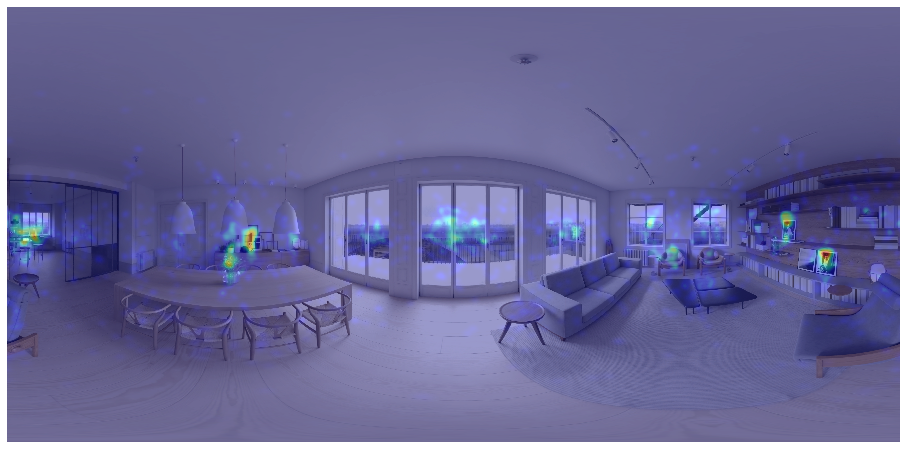

In [12]:
print(os.getcwd())
gaze_salmap = get_gaze_salmap(runs_files[0]['data'])
fig, ax = overlay_image_salmap('base_image.png', gaze_salmap)

## Get the head-position only approximation of the ground-truth saliency map

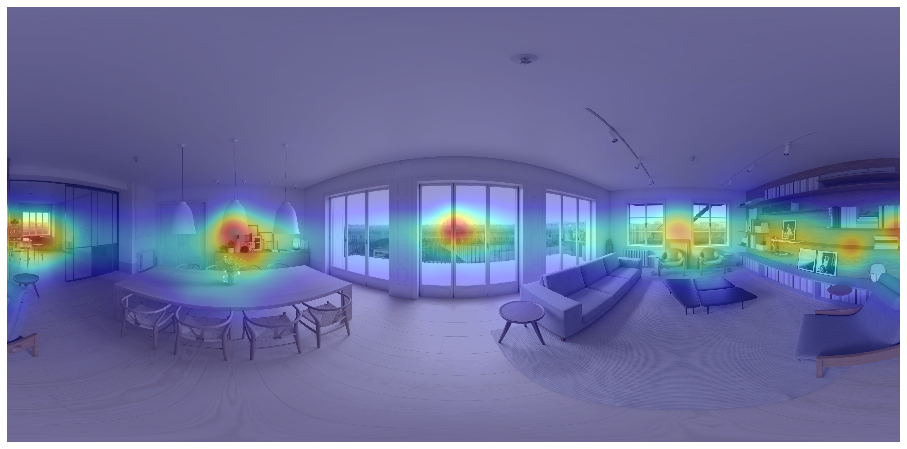

In [13]:
head_salmap = get_head_salmap(runs_files[0]['data'])
fig, ax = overlay_image_salmap('base_image.png', head_salmap)

## Compute the horizon bias baseline

In [14]:
def get_horizon_bias(list_of_runs):
    # We first filter out the fixations in the first few seconds around the starting point.
    # Filter the starting points
    filtered_list = filter_starting_point(list_of_runs)
    horizon_bias_salmap = get_gaze_salmap(filtered_list)

    # We now fit a laplacian to the data, where the longitudinal component is marginalized out.
    all_fix_lats = np.vstack([run['gaze_fixations_single'][run['gaze_fixations_single'][:,1]!=0] for run in filtered_list])[:, 1]*180.0

    param = scipy.stats.laplace.fit(all_fix_lats)

    fig = plt.figure(figsize=(24.0, 9.0))
    gs = matplotlib.gridspec.GridSpec(1,4)
    gs.update(wspace=0.05)

    ax1 = fig.add_subplot(gs[0, 1:4])
    ax2 = fig.add_subplot(gs[0, 0], sharey=ax1)

    ax1.imshow(horizon_bias_salmap, cmap=plt.cm.jet, extent=[0, 360, 0, 180])
    ax1.axis('off')

    ax2.hist(all_fix_lats, bins=90, normed=True, alpha=0.6, color='g', orientation='horizontal')

    ymin, ymax = ax2.get_ylim()
    y = np.arange(180)
    p = scipy.stats.laplace.pdf(y, *param[:-2], loc=param[-2], scale=param[-1])

    ax2.plot(p, y, 'k', linewidth=2)
    ax2.set_ylim([180, 0])
    ax2.axis('off')
    ax2.invert_xaxis()
    
    return param

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


(91.39140332659433, 17.91483857677794)


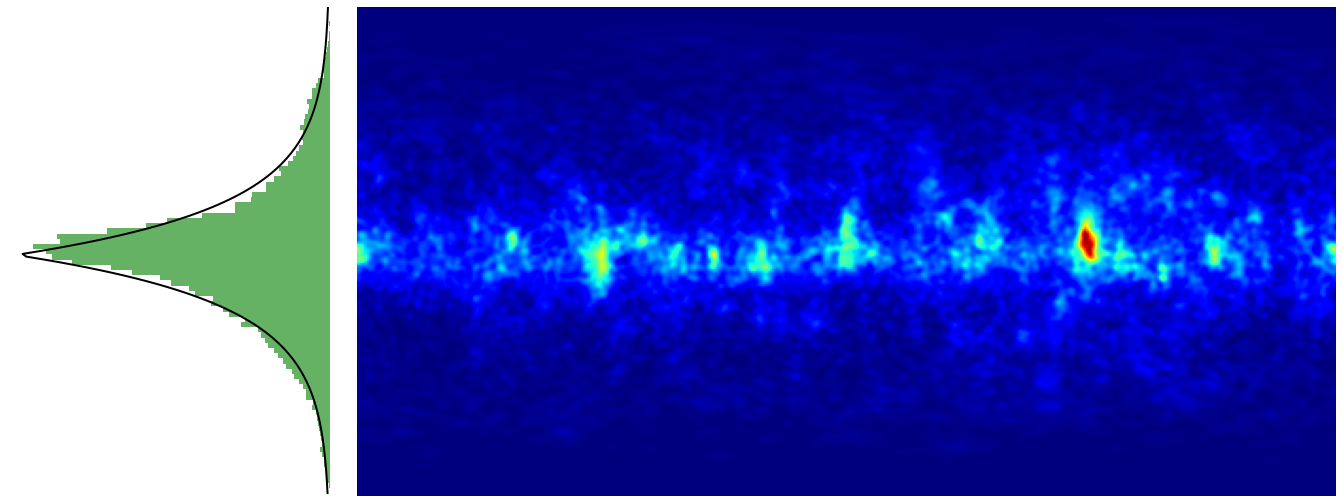

(91.22257198277276, 15.146517401350195)


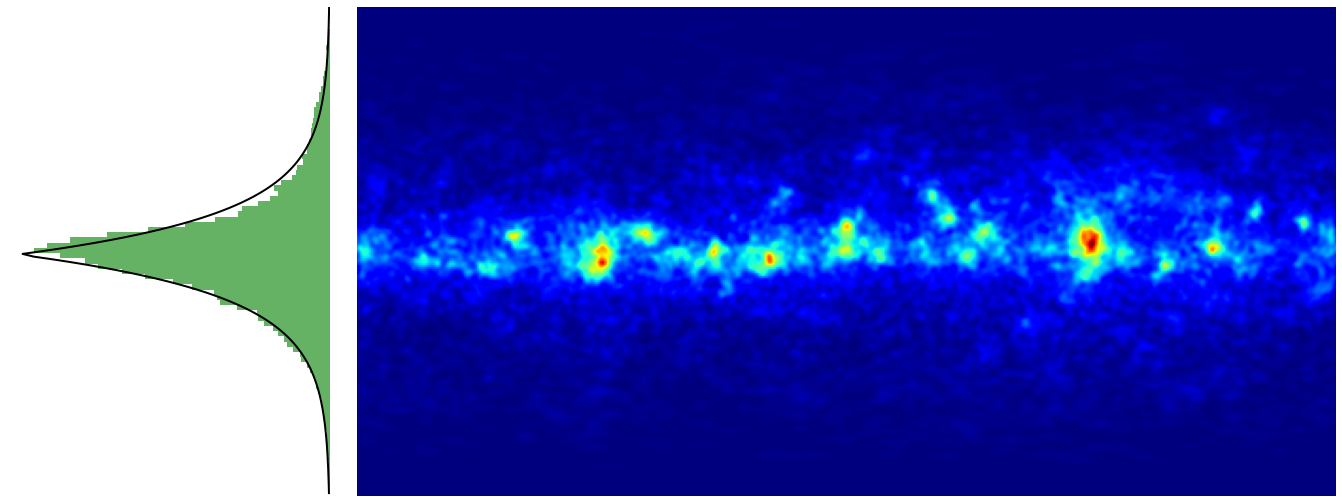

In [15]:
print(get_horizon_bias(all_runs_list))
plt.show()
print(get_horizon_bias(all_runs_list_browser))
plt.show()

## Gaze and head movement analysis

In [16]:
def get_full_df(list_of_runs, mode='vr'):
    # Build a matrix of *all* measurements
    data_matrix, pred_columns = get_data_matrix(list_of_runs, column_set=mode)
    df = pd.DataFrame(data_matrix, columns=pred_columns)

    # Reject measurements that are more than 10 standard deviations away from the mean.
    data_matrix_clean, means, stds = reject_gauss_outliers(data_matrix, pred_columns, m=10)
    df = pd.DataFrame(data_matrix_clean, columns=pred_columns)
    return df

def get_fix_no_fix_data(full_df):
    fix_df = full_df[full_df['gaze_fixations_ind']!=0]
    no_fix_df = full_df[full_df['gaze_fixations_ind']==0]
    fix_data = fix_df[['ang_head_velo_lon','ang_gaze_offset_velo_lon']].values
    no_fix_data = no_fix_df[['ang_head_velo_lon','ang_gaze_offset_velo_lon']].values
    return fix_df, no_fix_df, fix_data, no_fix_data

vr_df = get_full_df(all_runs_list)
fix_df, no_fix_df, fix_data, no_fix_data = get_fix_no_fix_data(vr_df)
browser_df = get_full_df(all_runs_list_browser, mode='browser')

Rejection percentages:
Column gaze_lat_lon_offset_lat: 0.0000
Column gaze_lat_lon_offset_lon: 0.0000
Column gaze_fixations_single_lat: 0.0040
Column gaze_fixations_single_lon: 0.0018
Column ang_gaze_offset_velo_lat: 0.0023
Column ang_gaze_offset_velo_lon: 0.0021
Column ang_head_velo_lat: 0.0003
Column ang_head_velo_lon: 0.0000
Column ang_gaze_velo_lat: 0.0022
Column ang_gaze_velo_lon: 0.0007
Column headTilt: 0.0002
Column gaze_fixations_ind: 0.0000


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:269: RuntimeWarning: invalid value encountered in greater


Rejection percentages:
Column gaze_lat_lon_offset_lat: 0.0000
Column gaze_lat_lon_offset_lon: 0.0000
Column gaze_fixations_single_lat: 0.0040
Column gaze_fixations_single_lon: 0.0056
Column ang_gaze_offset_velo_lat: 0.0003
Column ang_gaze_offset_velo_lon: 0.0002
Column ang_head_velo_lat: 0.0002
Column ang_head_velo_lon: 0.0002
Column ang_gaze_velo_lat: 0.0002
Column ang_gaze_velo_lon: 0.0001
Column gaze_fixations_ind: 0.0000


## Fixation statistics

In [ ]:
def get_fixation_stats(list_of_runs):
    fix_durs = []
    fix_counts = []
    for run in list_of_runs:
        fix_counts.append(len(run['gaze_fixations_raw']))
        for fixation in run['gaze_fixations_raw']:
            fix_durs.append(fixation['duration'])
            
    print(np.mean(fix_durs), np.std(fix_durs))
    print(np.mean(fix_counts), np.std(fix_counts))

    return fix_durs, fix_counts

print("VR")
_ = get_fixation_stats(all_runs_list)
print(np.mean(np.abs(vr_df['gaze_lat_lon_offset_lon'])))
print(np.std(np.abs(vr_df['gaze_lat_lon_offset_lon'])))
print('')

print("Browser")
_ = get_fixation_stats(all_runs_list_browser)
print(np.mean(np.abs(browser_df['gaze_lat_lon_offset_lon'])))
print(np.std(np.abs(browser_df['gaze_lat_lon_offset_lon'])))

VR
0.2661880806315424 0.1324995300646774
55.35897435897436 12.850695241068856
12.035565420942666
10.715029927515515

Browser


### Vestibolu-Ocular reflex

In [ ]:
# Formatting
font = {'family': 'sans',
        'weight': 'bold',
        'size': 10,
        }
hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}

# Fit a line to the fixation data - we should see the vestibulo-ocular reflex!
slope, intercept, r, p, _ = scipy.stats.linregress(fix_data[:, 0], fix_data[:, 1])

fig, ax = plt.subplots(1, 1)
ax.scatter(fix_data[:, 1], fix_data[:, 0], alpha = 0.01, facecolor=None)
ax.plot(fix_data[:, 0]*slope + intercept, fix_data[:, 0])
ax.text(100, 0.007, "Slope %0.2f\nIntercept %0.2f"%(slope, intercept), fontdict=font, horizontalalignment='left')

ax.set_xlabel(r'Longitudinal head velocity in $\frac{degree}{s}$')
ax.set_ylabel(r'Longitudinal gaze velocity in $\frac{degree}{s}$')

ax.set_xlim([-400,400])

In [ ]:
fix_velos = np.absolute(fix_df['ang_head_velo_lon'])
no_fix_velos = np.absolute(no_fix_df['ang_head_velo_lon'])

bins = np.arange(0, 200, 5)
ax = sns.distplot(fix_velos, kde=False, 
                  norm_hist=True, hist_kws=hist_kws, bins=bins, label='Fixating')
sns.distplot(no_fix_velos, 
                  kde=False, norm_hist=True, ax=ax, hist_kws=hist_kws, bins=bins, label='Not fixating')

ax.set_xlabel(r"Longitudinal head velocity $v$ in $\frac{deg}{s}$")
ax.set_ylabel(r"Normalized fixation count")
ax.set_xlim([-10, 200])

ax.legend()

font = {'family': 'sans',
        'color':  'black',
        'weight': 'bold',
        'size': 10,
        }

not_fixating = copy.deepcopy(font)
not_fixating.update({'color':sns.color_palette()[1]})

fixating = copy.deepcopy(font)
fixating.update({'color':sns.color_palette()[0]})

ax.text(20, 0.03, 
        "Mean $v$  %.3f\nStd           %.3f"%(np.mean(fix_velos), np.std(fix_velos)),
                                                fontdict=fixating, horizontalalignment='left')
ax.text(100, 0.007, 
        "Mean $v$  %.3f\nStd           %.3f"%(np.mean(no_fix_velos), np.std(no_fix_velos)),\
        fontdict=not_fixating, horizontalalignment='left')
ax.get_figure().savefig('head_velo_fix_distrib.pdf', bbox_inches='tight')

In [ ]:
fix_offs = np.absolute(fix_df['gaze_lat_lon_offset_lon'])
no_fix_offs = np.absolute(no_fix_df['gaze_lat_lon_offset_lon'])

bins = np.arange(0, 200, 2)
ax = sns.distplot(fix_offs, bins=bins, kde=False, 
                  norm_hist=True, hist_kws=hist_kws, label='Fixating')
sns.distplot(no_fix_offs, bins=bins, 
                  kde=False, norm_hist=True, ax=ax, hist_kws=hist_kws, label='Not fixating')

ax.set_xlabel(r"Longitudinal head-eye offset in degree")
ax.set_ylabel(r"Normalized fixation count")

ax.legend()
ax.set_xlim([-5, 100])

font = {'family': 'sans',
        'color':  'black',
        'weight': 'bold',
        'size': 10,
        }

not_fixating = copy.deepcopy(font)
not_fixating.update({'color':sns.color_palette()[1]})

fixating = copy.deepcopy(font)
fixating.update({'color':sns.color_palette()[0]})

ax.text(6, 0.065, 
        "Mean $v$  %.3f\nStd        %.3f"%(np.mean(fix_offs), np.std(fix_offs)),
         fontdict=fixating, horizontalalignment='left')
ax.text(30, 0.01, 
        "Mean $v$  %.3f\nStd         %.3f"%(np.mean(no_fix_offs), np.std(no_fix_offs)),
         fontdict=not_fixating, horizontalalignment='left')
ax.get_figure().savefig('gaze_off_distrib.pdf', bbox_inches='tight')

## Exploration time

In [ ]:
def get_exploration_times(all_runs):
    angles = np.arange(-360.0, 361.0)
    all_times = -1 * np.ones((len(angles), len(all_runs)))

    for run_idx, run in enumerate(all_runs):
        if run_idx % 100 == 0: print (run_idx)

        timestamps = np.squeeze(run['timestamp'])
        gaze_velos = np.squeeze(run['ang_gaze_velo'][:-1, 1])

        run_offsets = gaze_velos.reshape(-1,1) * np.diff(timestamps).reshape(-1, 1)
        
        # This filters out eyetracking measurement errors.
        bad_rows = np.squeeze(np.abs(run_offsets)>100)
        run_offsets = interpolate_nan_rows(run_offsets, bad_rows)

        offset_integral = np.zeros(len(run_offsets)+1)
        offset_integral[1:] = np.squeeze(np.cumsum(run_offsets, axis=0))

        for angle_idx, angle in enumerate(angles):
            if angle < 0:
                candidate_idcs = np.logical_and(angle > offset_integral, angle <= np.roll(offset_integral, 5, axis=0))
                if not np.any(candidate_idcs): 
                    continue

                min_idx = np.amin(np.where(candidate_idcs)[0])
                discovery_time = run['timestamp'][min_idx]
            else:
                candidate_idcs = np.logical_and(angle <= offset_integral, angle > np.roll(offset_integral, 5, axis=0))
                if not np.any(candidate_idcs):
                    continue

                min_idx = np.amin(np.where(candidate_idcs)[0])
                discovery_time = run['timestamp'][min_idx]

            all_times[angle_idx, run_idx] = discovery_time

    bad_idcs = all_times < 0
    all_times[bad_idcs] = np.NaN

    return all_times

def get_exploration_statistics(all_times):
    expl_times_avg = np.nanmean(all_times, axis=1)
    expl_times_std = np.nanstd(all_times, axis=1)
    expl_times_min = np.nanpercentile(all_times, q=10, axis=1 )
    expl_times_max = np.nanpercentile(all_times, q=90, axis=1 )

    # For linear regression: mirror the negative angles to fit a single line to both sides
    angles = np.arange(-360.0, 361.0)
    angles_linreg = np.copy(angles)
    angles_linreg[angles_linreg<0] *= -1

    # Fit linear regression to positive angles
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(angles_linreg,expl_times_avg)
    
    return slope, intercept, (expl_times_avg, expl_times_min, expl_times_max)

In [ ]:
all_times_vr = get_exploration_times(all_runs_list)

In [ ]:
slope_vr, intercept_vr, expl_time_stats_vr = get_exploration_statistics(all_times_vr)

In [ ]:
fig, ax = plt.subplots(1)

angles = np.arange(-360.0, 361.0)

ax.plot(angles, expl_time_stats_vr[0], color=sns.color_palette()[0])
# ax.plot(angles, expl_time_stats_bw[0], color=sns.color_palette()[1])

# ax.plot(angles, expl_times_min, angles, expl_times_max, color='lightblue', alpha=0.4)

ax.plot(angles, np.abs(angles*slope_vr) + intercept_vr, c=sns.color_palette()[0], label='VR')
# ax.plot(angles, np.abs(angles*slope_bw) + intercept_bw, c=sns.color_palette()[1], label='Browser')

font = {'family': 'sans',
        'weight': 'normal',
        'size': 13,
        }

vr_font = copy.deepcopy(font)
vr_font.update({'color':sns.color_palette()[0]})

# bw_font = copy.deepcopy(font)
# bw_font.update({'color':sns.color_palette()[1]})

props = dict(boxstyle='square', fc='white', lw=2, alpha=0.3)
props_vr = copy.copy(props)
# props_bw = copy.copy(props)
props_vr.update({'ec':sns.color_palette()[0]})
# props_bw.update({'ec':sns.color_palette()[1]})

ax.text(130, 4, "speed %0.2f [deg/s]\nintercept %0.2f [s]"%(1/slope_vr, intercept_vr), 
        fontdict=vr_font, horizontalalignment='left', bbox=props_vr)
# ax.text(130, 19, "speed %0.2f [deg/s]\nintercept %0.2f [s]"%(1/slope_bw, intercept_bw), 
#         fontdict=bw_font, horizontalalignment='left', bbox=props_bw)

std_region_vr = (expl_time_stats_vr[0] - expl_time_stats_vr[1], expl_time_stats_vr[0] + expl_time_stats_vr[1])
# std_region_bw = (expl_time_stats_bw[0] - expl_time_stats_bw[1], expl_time_stats_bw[0] + expl_time_stats_bw[1])

ax.fill_between(angles, std_region_vr[0], std_region_vr[1], facecolor=sns.color_palette()[0], alpha=0.2)
# ax.fill_between(angles, std_region_bw[0], std_region_bw[1], facecolor=sns.color_palette()[1], alpha=0.2)

ax.set_xlim([-361, 361])
ax.set_xlabel('Longitudinal distance to starting point in degree ', fontsize=15)
ax.set_ylabel('Time until first reached in seconds', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

ax.legend(frameon=True, fontsize=13, loc=2)

_ = ax.set_xticks(np.linspace(-360, 360, num=9))

fig.savefig('exploration_time.pdf', bbox_inches='tight')
print("Done",os.getcwd())